# Pre-processing - Denoising 

In this dataset, the noise is considered to be residing in the higher frequency bands of the spectral bandwidth of the acquisition system. 

The acquisition system has a bandwidth of 0.5 Hz to 85 Hz which captures unstable gamma and high frequency fluctuations which can have the EEG-based epilepsy detection to fail. Thus these higher order noise components need to be removed. 

Methods to use:

[1] Low Pass Filtering - Analyse the impact of Low-Pass Filter for the EEG-based Epilepsy Detection.
    
    Parameters to consider:
      1. FIR Filters
      2. Window type and related parameters (Window size and filter order are same)
      3. Filter Order
      4. Cut-off Frequency
     
[2] Discrete Waivelet based Denoising - The row epochs will be decomposed into sub-bands and attenuate the higher spectral components based on thresholding method.

    Parameters to consider:
      1. Type of Waivelet Filter
      2. Number of Bands
      3. Threshold
      4. Operating resolution

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q mne
!pip install -q wfdb pyEDFlib PyWavelets

In [ ]:
import sys, os

sys.path.append(os.path.join(os.getcwd(), "drive/MyDrive/BME1473_Project"))

### Step 01: Load the Dataset

In [ ]:
import glob            # for file locations
import pandas as pd     # dataframes
import numpy as np
import pickle

import scipy.signal as signal
from pylab import *
from scipy.fft import fft, fftfreq, fftshift
import matplotlib.pyplot as plt

In [ ]:
def dump_results(data_, file_name, results_dir, trans_type):
  sub_dir = os.path.join(results_dir, trans_type)
  os.makedirs(sub_dir, exist_ok = True)

  file_name = os.path.join(sub_dir, file_name + '.pickle')

  with open(file_name, 'wb') as file_:
    pickle.dump(data_, file_, protocol=pickle.HIGHEST_PROTOCOL)
  return

In [ ]:
DATA_DIR = './drive/MyDrive/BME1473_Project/Dataset'
RESULTS_DIR = './drive/MyDrive/BME1473_Project/Results'

Sub_Dir = ['F', 'S'] # Where F - Baseline Signals, S - Seizure Signal

data_dict = {}; 

for i, data_dir in enumerate(Sub_Dir):
  files_list = sorted(glob.glob(os.path.join(DATA_DIR, data_dir, '*.txt')));
  print(files_list[0])
  data_dict[data_dir] = {};
  signal_array = [];

  for file_ in files_list:
    signal_ = np.loadtxt(file_)
    signal_array.append(signal_)
  signal_array = np.array(signal_array)
  data_dict[data_dir] = signal_array
 
print(f'Inter-Ictal Signal Data : {data_dict[Sub_Dir[0]].shape}')
print(f'Ictal Signal Data : {data_dict[Sub_Dir[1]].shape}')

./drive/MyDrive/BME1473_Project/Dataset/F/F001.txt
./drive/MyDrive/BME1473_Project/Dataset/S/S001.txt
Inter-Ictal Signal Data : (100, 4097)
Ictal Signal Data : (100, 4097)


In [ ]:
# dump_results(data_dict, 'dataset', RESULTS_DIR, 'original')

In [ ]:
import random

np.random.seed(0)

nSignals, nSamples = data_dict[Sub_Dir[0]].shape

train_dict = {}
test_dict = {}

id_list = np.arange(nSignals)
train_data_ids = np.array(random.sample(list(id_list), k = int(nSignals * 0.8)))
test_data_ids = np.array(list(set(id_list) - set(train_data_ids)))

for i, data_dir in enumerate(Sub_Dir):
  train_dict[data_dir] = data_dict[data_dir][train_data_ids, :]
  test_dict[data_dir] = data_dict[data_dir][test_data_ids, :]

  print(f'Train Dataset {data_dir}: {train_dict[data_dir].shape[0]} signals')
  print(f'Test Dataset {data_dir}: {test_dict[data_dir].shape[0]} signals')

Train Dataset F: 80 signals
Test Dataset F: 20 signals
Train Dataset S: 80 signals
Test Dataset S: 20 signals


In [ ]:
# dump_results(train_dict, 'traindata', RESULTS_DIR, 'original')
# dump_results(test_dict, 'testdata', RESULTS_DIR, 'original')

### Step 02: Data Detrending and Unit Variance

In [ ]:
sampling_freq = 173.73
nyq_rate = sampling_freq / 2

t_vect = np.arange(0, nSamples) / sampling_freq
f_vect = np.fft.fftshift(np.fft.fftfreq(nSamples)) * sampling_freq

def plot_eeg_samples(dataset, sample_no, nSamples, dataset_name = 'Train'):
  figure(figsize=(20, 10))
  subplot(2, 2, 1) 
  plot(t_vect, dataset['S'][sample_no])
  xlabel('Time (s)'); ylabel(r'Sigal Value ($\mu$ V)')
  title(f'Ictal Signal Sample - {dataset_name} Set (Time Domain)')

  subplot(2, 2, 2) 
  plot(f_vect, np.abs(np.fft.fftshift(np.fft.fft(dataset['S'][sample_no])) / nSamples))
  xlabel('Freq (Hz)'); ylabel('Magnitude')
  title(f'Ictal Signal Sample - {dataset_name} Set (Frequency Domain)')

  subplot(2, 2, 3) 
  plot(t_vect, dataset['F'][sample_no])
  xlabel('Time (s)'); ylabel(r'Sigal Value ($\mu$ V)')
  title(f'Inter-Ictal Signal Sample - {dataset_name} Set (Time Domain)')

  subplot(2, 2, 4) 
  plot(f_vect, np.abs(np.fft.fftshift(np.fft.fft(dataset['F'][sample_no])) / nSamples))
  xlabel('Freq (Hz)'); ylabel('Magnitude')
  title(f'Inter-Ictal Signal Sample - {dataset_name} Set (Frequency Domain)')

  return

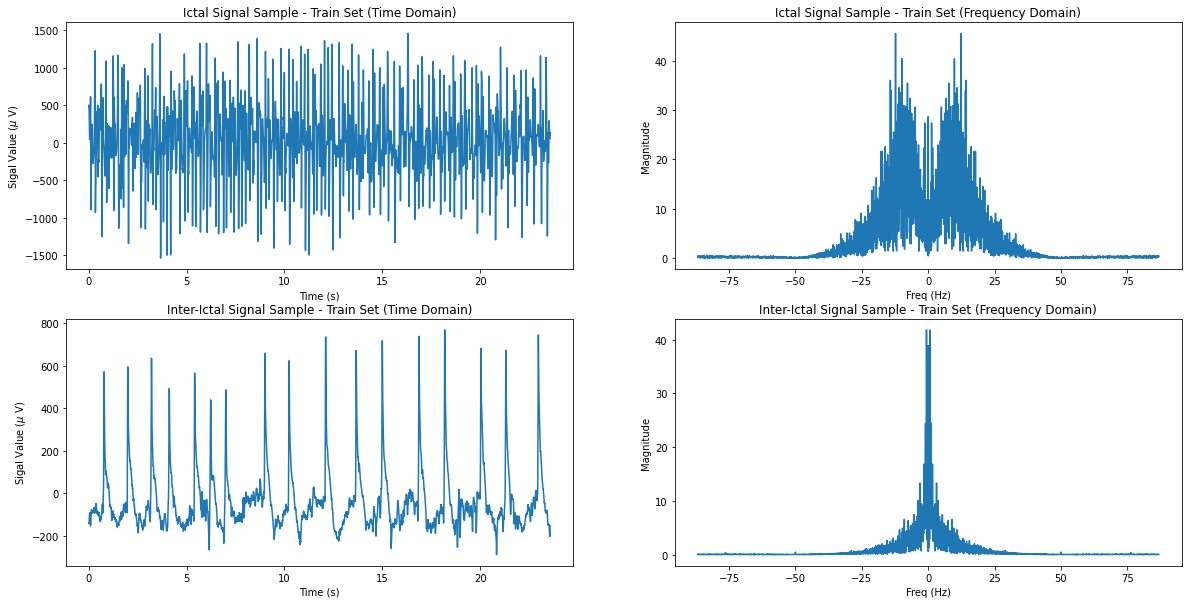

In [ ]:
plot_eeg_samples(train_dict, 20, nSamples, dataset_name = 'Train')

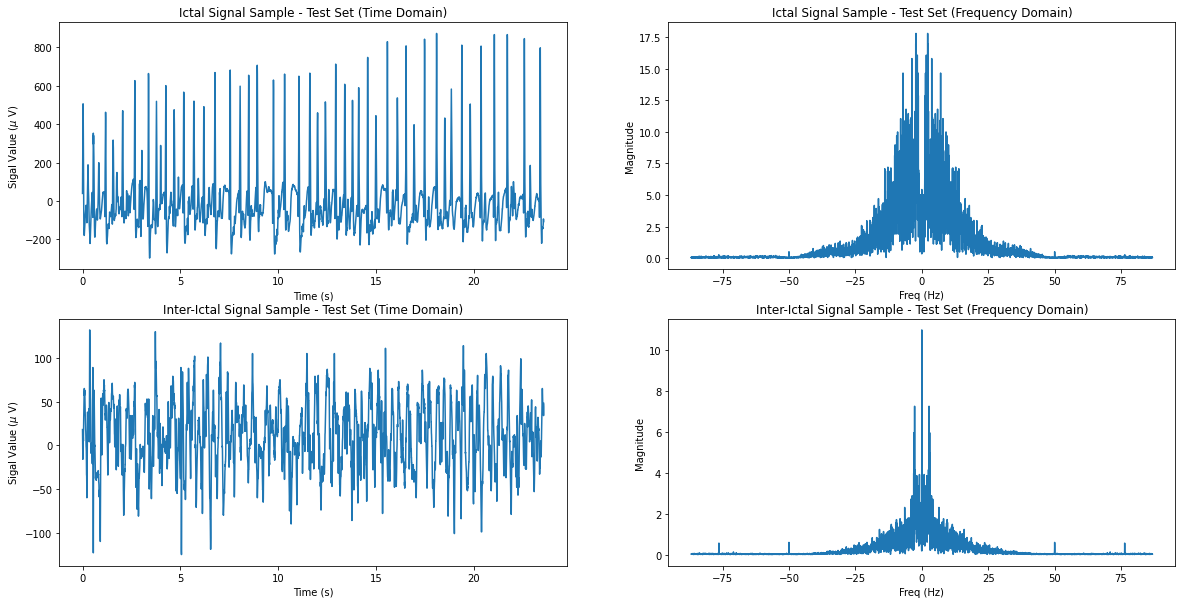

In [ ]:
plot_eeg_samples(test_dict, 10, nSamples, dataset_name = 'Test')

In [ ]:
def data_whiten(eeg_dataset, scaling):
  """
    This function performs the EEG whitening where the signal is centered around
    0 mean and unit variance. The signal is first detrended by deducting mean 
    and then dividing by the variance to whiten the data.

    Args:
      Inputs: 
        eeg_signal: np.darray of size N x T (N - No. of signals, T - Samples)
        scaling: int (scaling of the signals to convert from V to uV)

      Outputs:
        centered_eeg: detrended eeg signal
        eeg_pca: eeg signals whitened with PCA
        eeg_zca: eeg signals whitened with ZCA
  """

  eeg_dataset = eeg_dataset * scaling
  eeg_mean = np.mean(eeg_dataset, axis = 1)   # Get the mean value of each signal

  centered_eeg = eeg_dataset - np.expand_dims(eeg_mean, axis = 1)       # Detrending by removing the mean value
   
  # Calculate covariance matrix
  eeg_cov = np.cov(centered_eeg)

  # Calculate Eigenvalues and Eigenvectors
  eigen_values, eigen_vectors = np.linalg.eig(eeg_cov)
 
  # Calculate inverse square root of Eigenvalues
  # Add '.1e5' to avoid division errors if needed
  # Create a diagonal matrix
  diag_lambda = np.diag(1 / ((eigen_values + + .1e-5) ** 0.5)) 
  diag_lambda = diag_lambda.real # convert to real and round off
 
  # Whitening transform using PCA (Principal Component Analysis)
  eeg_pca = np.dot(np.dot(diag_lambda, eigen_vectors.T), centered_eeg)
 
  # Whitening transform using ZCA (Zero Component Analysis)
  eeg_zca = np.dot(np.dot(np.dot(eigen_vectors, diag_lambda), eigen_vectors.T), centered_eeg) 

  return centered_eeg, eeg_pca, eeg_zca

In [ ]:
detrend_train = {'F': [], 'S': []}
pca_train = {'F': [], 'S': []}
zca_train = {'F': [], 'S': []}

detrend_test = {'F': [], 'S': []}
pca_test = {'F': [], 'S': []}
zca_test = {'F': [], 'S': []}

for i, data_dir in enumerate(Sub_Dir):
  detrend_train[data_dir], pca_train[data_dir], zca_train[data_dir] = data_whiten(train_dict[data_dir], 1)
  detrend_test[data_dir], pca_test[data_dir], zca_test[data_dir] = data_whiten(test_dict[data_dir], 1)

In [ ]:
# dump_results(detrend_train, 'train_detrend', RESULTS_DIR, 'denoised')
# dump_results(pca_train, 'train_pca', RESULTS_DIR, 'denoised')
# dump_results(zca_train, 'train_zca', RESULTS_DIR, 'denoised')

# dump_results(detrend_test, 'test_detrend', RESULTS_DIR, 'denoised')
# dump_results(pca_test, 'test_pca', RESULTS_DIR, 'denoised')
# dump_results(zca_test, 'test_zca', RESULTS_DIR, 'denoised')

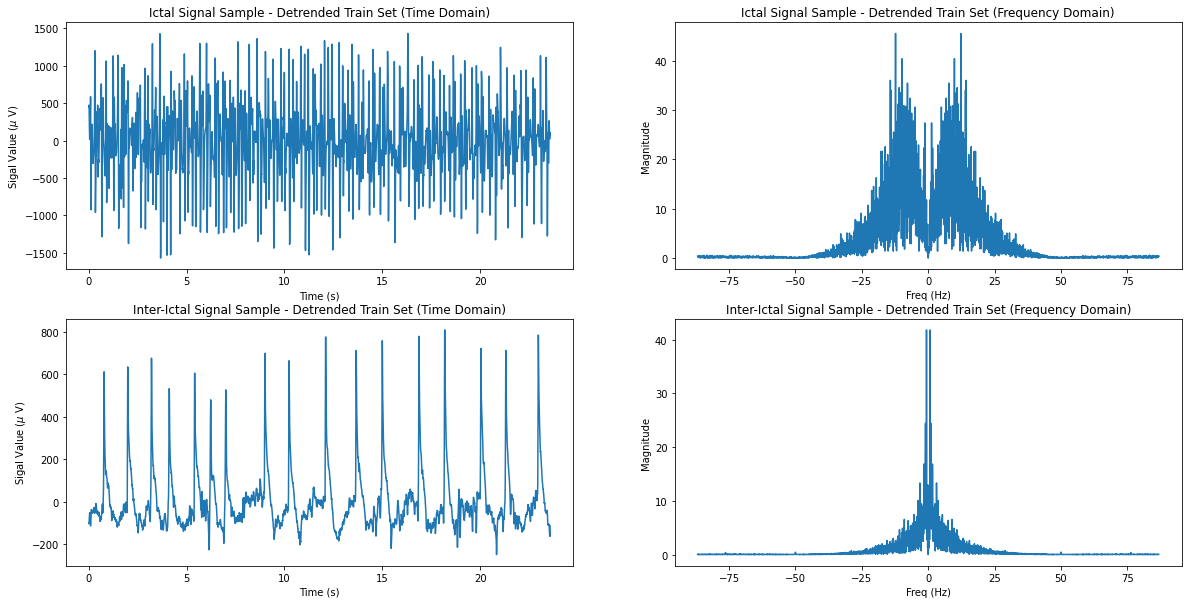

In [ ]:
plot_eeg_samples(detrend_train, 20, nSamples, dataset_name = 'Detrended Train')

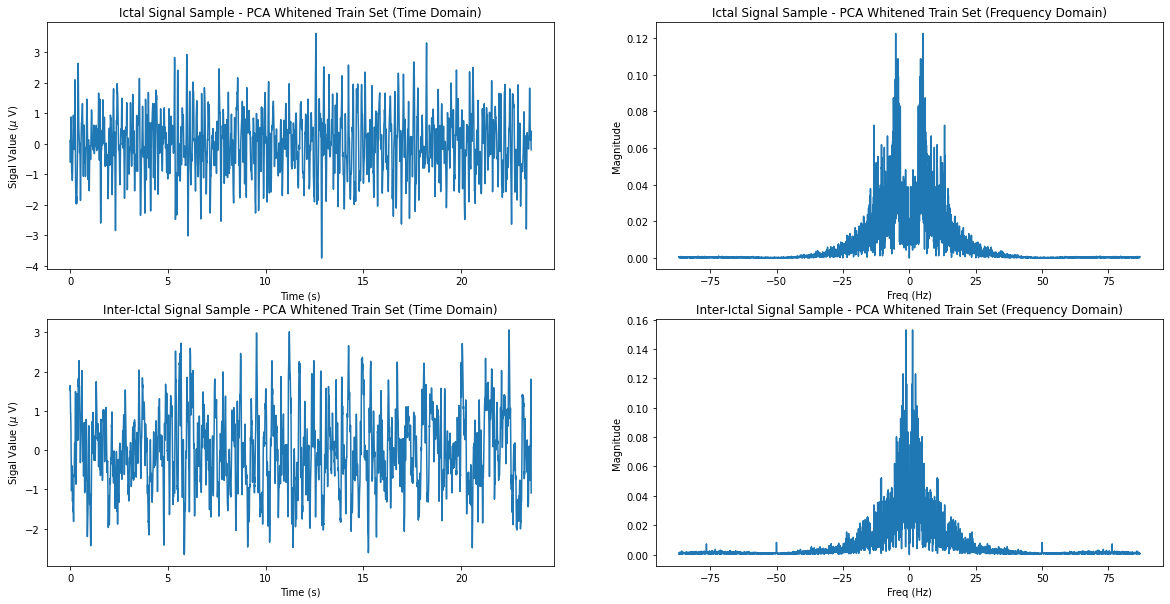

In [ ]:
plot_eeg_samples(pca_train, 20, nSamples, dataset_name = 'PCA Whitened Train')

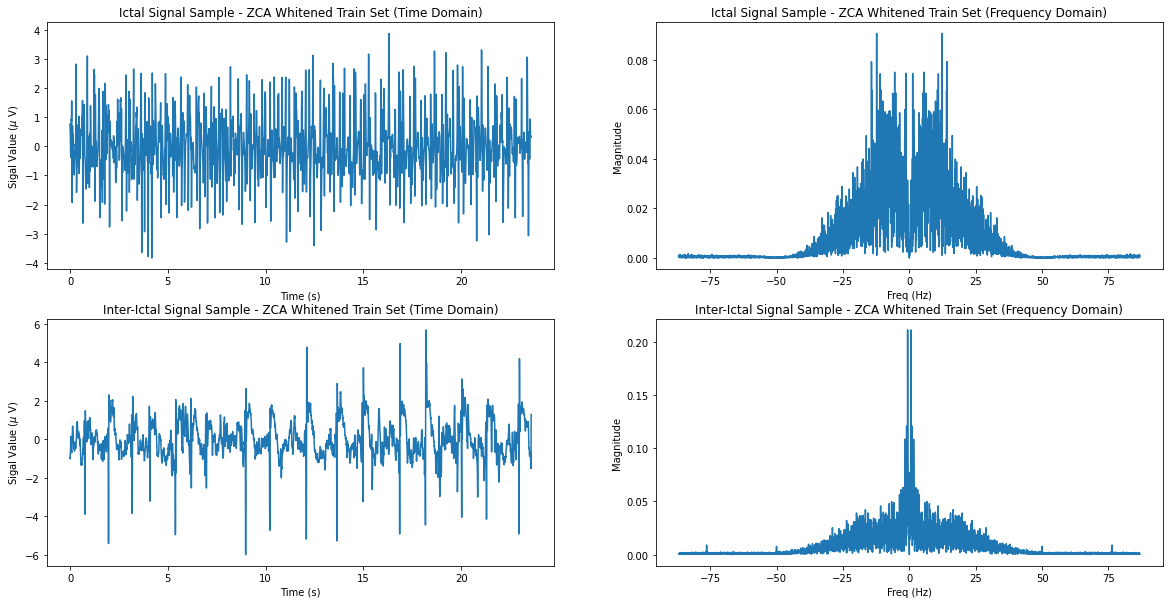

In [ ]:
plot_eeg_samples(zca_train, 20, nSamples, dataset_name = 'ZCA Whitened Train')

### Step 03: Low-Pass Filtering - Primary Method

***FIR Filtering***

As the primary method, FIR filters will be used to filter out the high-frequency noise components. For this, the signals will be filtered with FIR filters where the effect of the following parameters will be explored:
1. Type of window function (and related window parameters)
2. Filter Order (Window Length - 1)
3. Cut-off frequency

In [ ]:
# FIR Filter Plotting Helper Functions

def plot_impulse(b, a = 1, window_name = 'rectangle'):
  filter_length = len(b)

  figure(figsize=(10, 5))
  stem(arange(filter_length), b, 'bo-')
  ylabel('Amplitude')
  xlabel(r'n (samples)')
  title(f'Impulse Response ({window_name} window of order {filter_length})')
  return 

def freqres_magnitude(b, a = 1, nyq_rate = 250, cutoff = 40, window_name = 'rectangle'):
  filter_length = len(b)
  defaultCut = 40
  omega, freq_ = signal.freqz(b)
  f_vector = (omega / pi) * nyq_rate

  figure(figsize=(10, 5))
  plot(f_vector, absolute(freq_), linewidth = 2)
  xlabel('Frequency (Hz)'); ylabel('Magnitude')
  title(f'Magnitude Response ({window_name} window of order {filter_length})')
  ylim(-0.05, 1.1)
  grid(True)

  # Upper inset plot.
  ax1 = axes([0.55 + (cutoff - defaultCut) * 0.01, 0.6, .4, .2])
  plot(f_vector, absolute(freq_), linewidth = 2)
  xlim(0, 40 + (cutoff - defaultCut)); ylim(0.5, 1.1)
  title('Passband Riple')
  grid(True)

  # Lower inset plot
  ax2 = axes([0.55 + (cutoff - defaultCut) * 0.01, 0.25, .4, .2])
  plot(f_vector, absolute(freq_), linewidth = 2)
  xlim(50 + (cutoff - defaultCut), 80.0 + (cutoff - defaultCut)); ylim(0.0, 0.05)
  title('Stopband Riple')
  grid(True)

def freqres_phase(b, a = 1, nyq_rate = 250, window_name = 'rectangle'):
  filter_length = len(b)
  omega, freq_ = signal.freqz(b)
  f_vector = (omega / pi) * nyq_rate

  phase_res = unwrap(arctan2(imag(freq_), real(freq_)))

  figure(figsize=(10, 5))
  plot(f_vector, phase_res)
  xlim(0, nyq_rate)
  xlabel('Frequency (Hz)'); ylabel('Phase (rad)')
  title(f'Phase Response ({window_name} window of order {filter_length})')

def group_delay_plot(b, a = 1, nyq_rate = 250, window_name = 'rectangle'):
  filter_length = len(b)
  omega, gdelay = signal.group_delay((b, a))
  f_vector = (omega / pi) * nyq_rate
  
  figure(figsize=(10, 5))
  plot(f_vector, gdelay)
  xlim(0, nyq_rate); ylim(max(gdelay) - 50, max(gdelay) + 50)
  xlabel('Frequency (Hz)'); ylabel('Group Delay (samples)')
  tight_layout()
  title(f'Group Delay ({window_name} window of order {filter_length})')

In [ ]:
cut_off = [35, 40, 45, 50]                        # Cut-off Frequencies
filter_order = [16, 32, 64, 128]             # Different Filter order
window_names = ['boxcar', 'hamming', 'blackman']  # Different Window Functions

In [ ]:
fir_filters = {}

for passfreq in cut_off:
  fir_filters[passfreq] = {}

  for forder in filter_order:
    fir_filters[passfreq][forder] = {}

    for windname in window_names:
      b = signal.firwin(forder, cutoff = passfreq / nyq_rate, window = windname)
      fir_filters[passfreq][forder][windname] = b

In [ ]:
# dump_results(fir_filters, 'fir_filters', RESULTS_DIR, 'fir_filtering')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  import sys


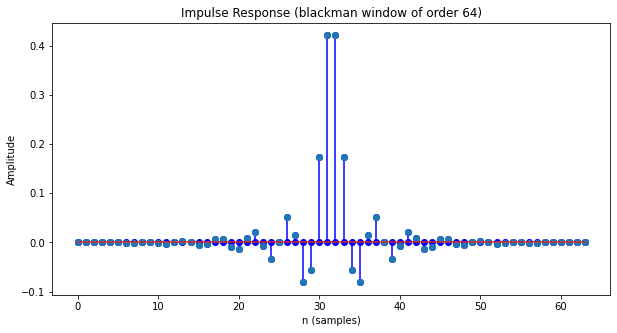

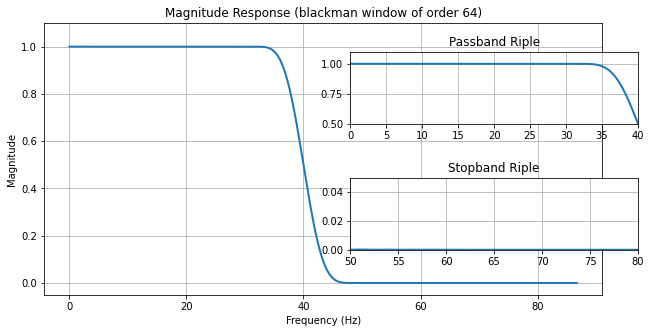

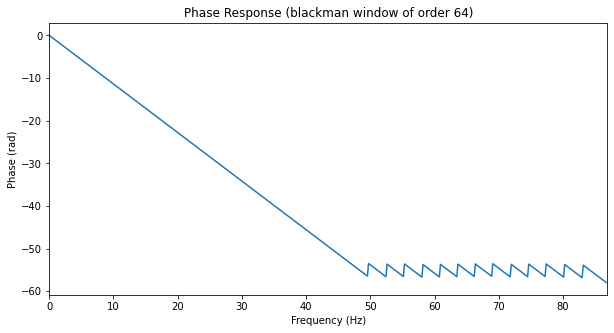

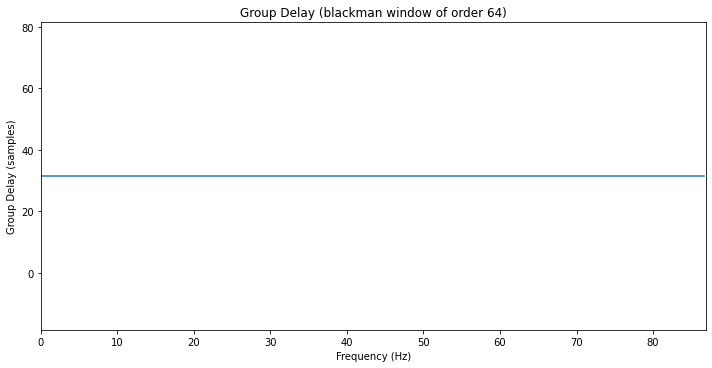

In [ ]:
# Plotting characteristics of some of the FIR filters

b = fir_filters[40][64]['blackman']

plot_impulse(b, a = 1, window_name = 'blackman')
freqres_magnitude(b, a = 1, nyq_rate = nyq_rate, cutoff = 40, window_name = 'blackman')
freqres_phase(b, a = 1, nyq_rate = nyq_rate, window_name = 'blackman')
group_delay_plot(b, a = 1, nyq_rate = nyq_rate, window_name = 'blackman')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  import sys


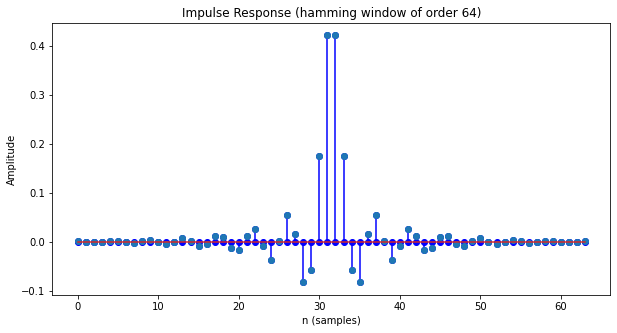

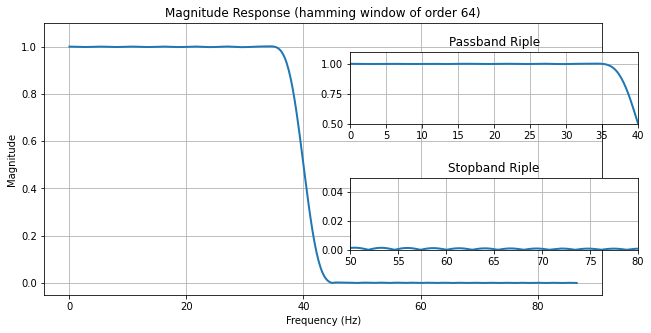

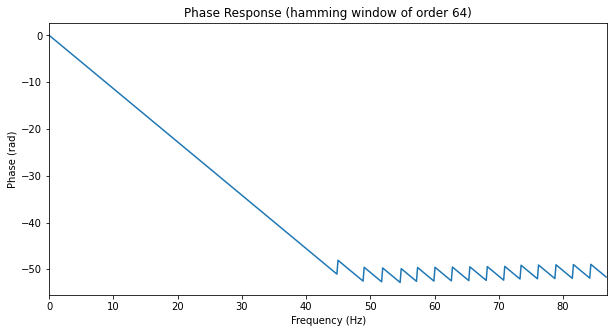

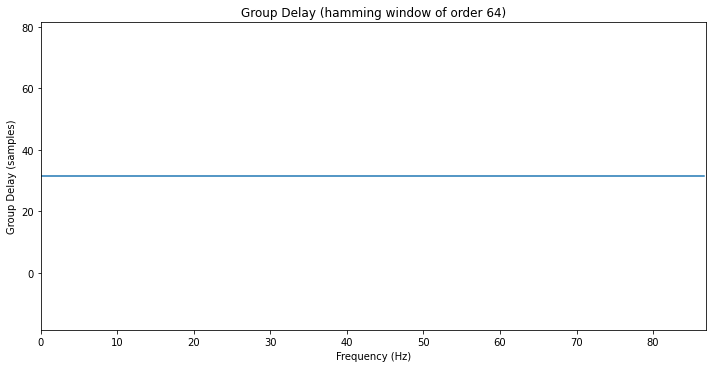

In [ ]:
b = fir_filters[40][64]['hamming']

plot_impulse(b, a = 1, window_name = 'hamming')
freqres_magnitude(b, a = 1, nyq_rate = nyq_rate, cutoff = 40, window_name = 'hamming')
freqres_phase(b, a = 1, nyq_rate = nyq_rate, window_name = 'hamming')
group_delay_plot(b, a = 1, nyq_rate = nyq_rate, window_name = 'hamming')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  import sys


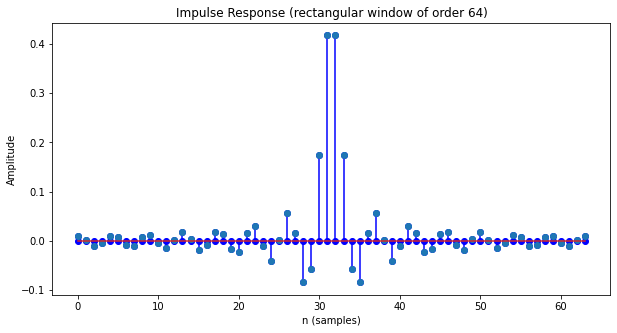

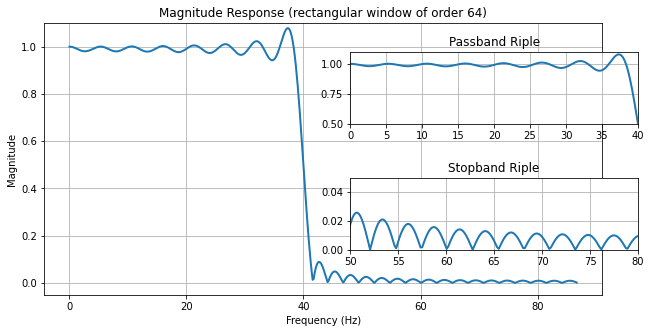

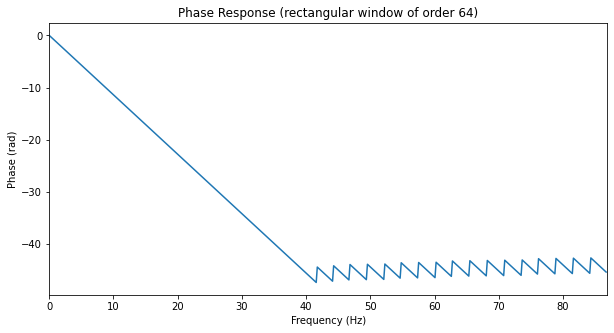

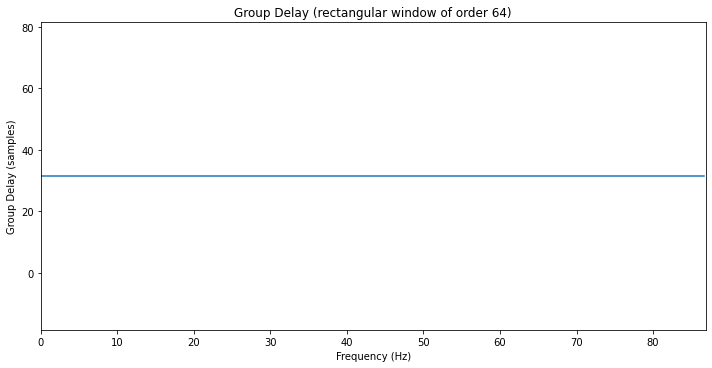

In [ ]:
b = fir_filters[40][64]['boxcar']

plot_impulse(b, a = 1, window_name = 'rectangular')
freqres_magnitude(b, a = 1, nyq_rate = nyq_rate, cutoff = 40, window_name = 'rectangular')
freqres_phase(b, a = 1, nyq_rate = nyq_rate, window_name = 'rectangular')
group_delay_plot(b, a = 1, nyq_rate = nyq_rate, window_name = 'rectangular')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  import sys


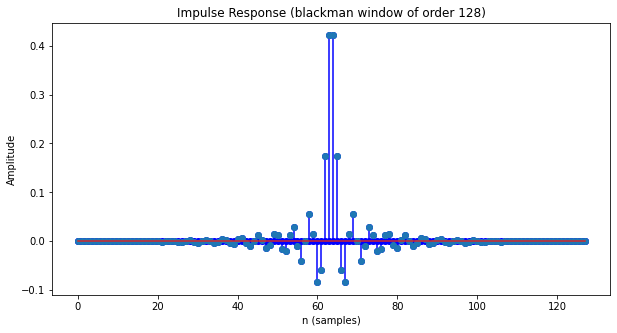

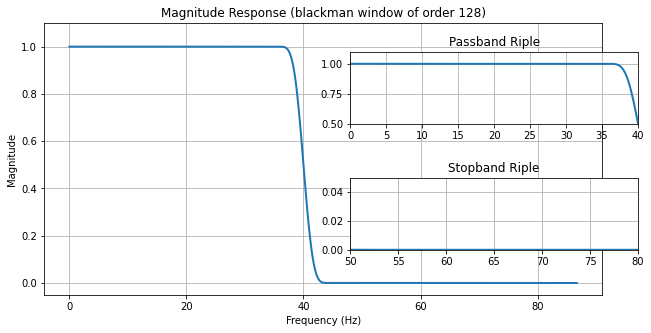

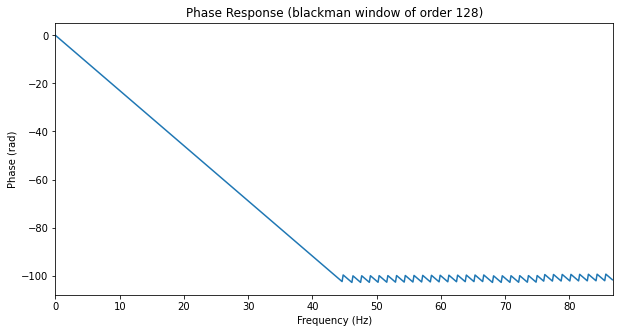

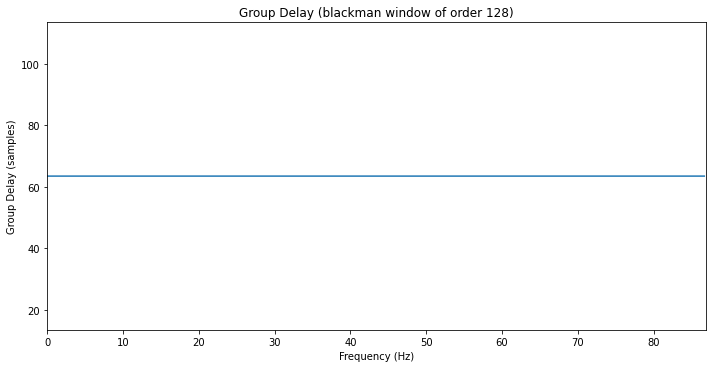

In [ ]:
b = fir_filters[40][128]['blackman']

plot_impulse(b, a = 1, window_name = 'blackman')
freqres_magnitude(b, a = 1, nyq_rate = nyq_rate, cutoff = 40, window_name = 'blackman')
freqres_phase(b, a = 1, nyq_rate = nyq_rate, window_name = 'blackman')
group_delay_plot(b, a = 1, nyq_rate = nyq_rate, window_name = 'blackman')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  import sys


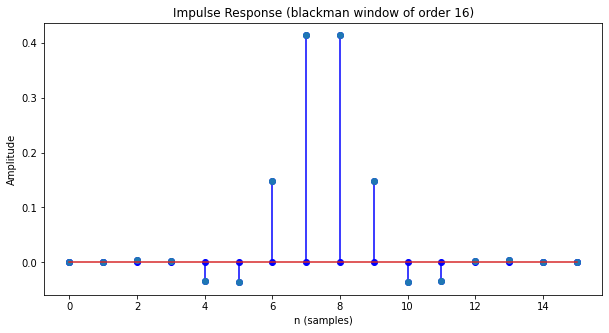

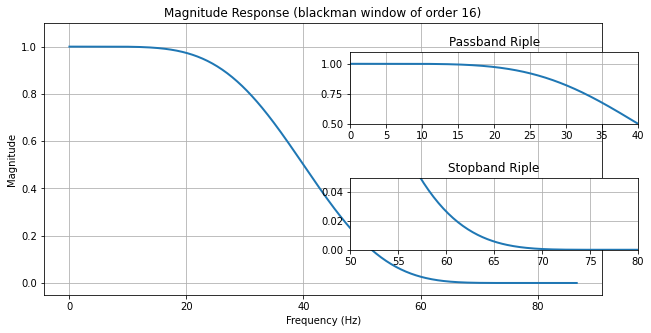

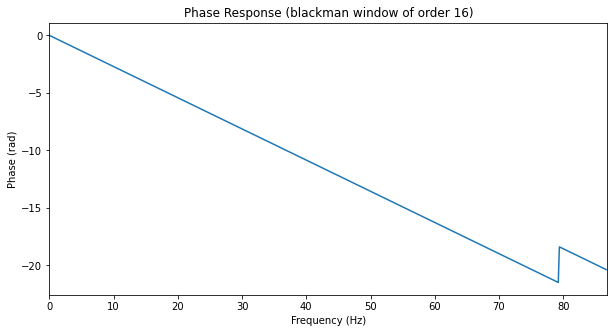

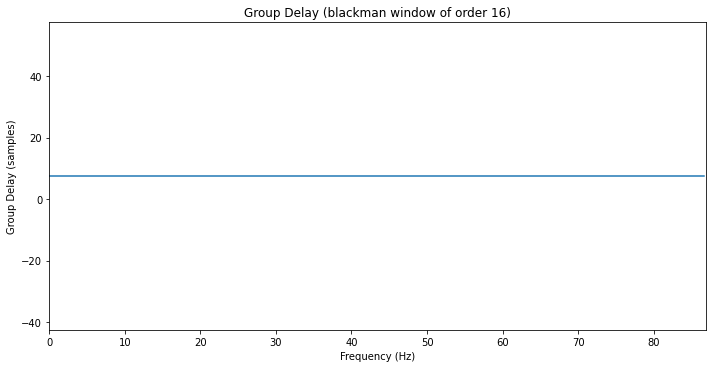

In [ ]:
b = fir_filters[40][16]['blackman']

plot_impulse(b, a = 1, window_name = 'blackman')
freqres_magnitude(b, a = 1, nyq_rate = nyq_rate, cutoff = 40, window_name = 'blackman')
freqres_phase(b, a = 1, nyq_rate = nyq_rate, window_name = 'blackman')
group_delay_plot(b, a = 1, nyq_rate = nyq_rate, window_name = 'blackman')

In [ ]:
def eval_filtering(orig_signal, filt_signal, nSamples, f_vect, cutoff = 40):
  orig_spectrum = fftshift(fft(orig_signal)) / nSamples;
  filt_spectrum = fftshift(fft(filt_signal)) / nSamples;

  noise_band_id = np.where((f_vect > 40) | (f_vect < -40))
  signal_band_id = np.where((f_vect < 40) & (f_vect > -40))

  orig_noisepower = 10 * np.log10(sum(abs(orig_spectrum[:, noise_band_id]) ** 2))  # in dB
  filt_noisepower = 10 * np.log10(sum(abs(filt_spectrum[:, noise_band_id]) ** 2))  # in dB

  orig_signalpower = 10 * np.log10(sum(abs(orig_spectrum[:, signal_band_id]) ** 2))  # in dB
  filt_signalpower = 10 * np.log10(sum(abs(filt_spectrum[:, signal_band_id]) ** 2))  # in dB

  delta_noisepower = filt_noisepower - orig_noisepower
  delta_signalpower = filt_signalpower - orig_signalpower

  return np.mean(delta_signalpower), np.mean(delta_noisepower)

In [ ]:
def fir_filtering(Sub_Dir, original_dict, detrend_dict, pca_dict, zca_dict):
  fir_filt_original = {}
  fir_filt_detrend = {}
  fir_filt_pca = {}
  fir_filt_zca = {}

  for i, data_dir in enumerate(Sub_Dir):
    fir_filt_original[data_dir] = {}
    fir_filt_detrend[data_dir] = {}
    fir_filt_pca[data_dir] = {}
    fir_filt_zca[data_dir] = {}

    for passfreq in cut_off:
      fir_filt_original[data_dir][passfreq] = {}
      fir_filt_detrend[data_dir][passfreq] = {}
      fir_filt_pca[data_dir][passfreq] = {}
      fir_filt_zca[data_dir][passfreq] = {}

      for forder in filter_order:
        fir_filt_original[data_dir][passfreq][forder] = {}
        fir_filt_detrend[data_dir][passfreq][forder] = {}
        fir_filt_pca[data_dir][passfreq][forder] = {}
        fir_filt_zca[data_dir][passfreq][forder] = {}

        for windname in window_names:
          fir_filt_original[data_dir][passfreq][forder][windname] = {}
          fir_filt_detrend[data_dir][passfreq][forder][windname] = {}
          fir_filt_pca[data_dir][passfreq][forder][windname] = {}
          fir_filt_zca[data_dir][passfreq][forder][windname] = {}

          filter_ = fir_filters[passfreq][forder][windname]
          fir_filt_original[data_dir][passfreq][forder][windname] = signal.lfilter(b = filter_, a = 1.0, x = original_dict[data_dir])
          fir_filt_detrend[data_dir][passfreq][forder][windname] = signal.lfilter(b = filter_, a = 1.0, x = detrend_dict[data_dir])
          fir_filt_pca[data_dir][passfreq][forder][windname] = signal.lfilter(b = filter_, a = 1.0, x = pca_dict[data_dir])
          fir_filt_zca[data_dir][passfreq][forder][windname] = signal.lfilter(b = filter_, a = 1.0, x = zca_dict[data_dir])

  return fir_filt_original, fir_filt_detrend, fir_filt_pca, fir_filt_zca

In [ ]:
fir_filt_original_train, fir_filt_detrend_train, fir_filt_pca_train, fir_filt_zca_train = fir_filtering(Sub_Dir, train_dict, detrend_train, pca_train, zca_train)
fir_filt_original_test, fir_filt_detrend_test, fir_filt_pca_test, fir_filt_zca_test = fir_filtering(Sub_Dir, test_dict, detrend_test, pca_test, zca_test)

In [ ]:
# dump_results(fir_filt_original_train, 'fir_filt_original_train', RESULTS_DIR, 'fir_filtering')
# dump_results(fir_filt_detrend_train, 'fir_filt_detrend_train', RESULTS_DIR, 'fir_filtering')
# dump_results(fir_filt_pca_train, 'fir_filt_pca_train', RESULTS_DIR, 'fir_filtering')
# dump_results(fir_filt_zca_train, 'fir_filt_zca_train', RESULTS_DIR, 'fir_filtering')

# dump_results(fir_filt_original_test, 'fir_filt_original_test', RESULTS_DIR, 'fir_filtering')
# dump_results(fir_filt_detrend_test, 'fir_filt_detrend_test', RESULTS_DIR, 'fir_filtering')
# dump_results(fir_filt_pca_test, 'fir_filt_pca_test', RESULTS_DIR, 'fir_filtering')
# dump_results(fir_filt_zca_test, 'fir_filt_zca_test', RESULTS_DIR, 'fir_filtering')

In [ ]:
t_vect = np.arange(0, nSamples) / sampling_freq
f_vect = np.fft.fftshift(np.fft.fftfreq(nSamples)) * sampling_freq

def plot_filteeg_samples(dataset, passfreq, forder, windname, sample_no, nSamples, dataset_name = 'Train'):
  figure(figsize=(20, 10))
  subplot(2, 2, 1) 
  plot(t_vect, dataset['S'][passfreq][forder][windname][sample_no])
  xlabel('Time (s)'); ylabel(r'Sigal Value ($\mu$ V)')
  title(f'Ictal Signal Sample - {dataset_name} Set - Cut-off = {passfreq} - Filt Order = {forder} - Window = {windname}')

  subplot(2, 2, 2) 
  plot(f_vect, np.abs(np.fft.fftshift(np.fft.fft(dataset['S'][passfreq][forder][windname][sample_no])) / nSamples))
  xlabel('Freq (Hz)'); ylabel('Magnitude')
  title(f'Ictal Signal Sample - {dataset_name} Set - Cut-off = {passfreq} - Filt Order = {forder} - Window = {windname}')

  subplot(2, 2, 3) 
  plot(t_vect, dataset['F'][passfreq][forder][windname][sample_no])
  xlabel('Time (s)'); ylabel(r'Sigal Value ($\mu$ V)')
  title(f'Inter-Ictal Signal Sample - {dataset_name} Set - Cut-off = {passfreq} - Filt Order = {forder} - Window = {windname}')

  subplot(2, 2, 4) 
  plot(f_vect, np.abs(np.fft.fftshift(np.fft.fft(dataset['F'][passfreq][forder][windname][sample_no])) / nSamples))
  xlabel('Freq (Hz)'); ylabel('Magnitude')
  title(f'Inter-Ictal Signal Sample - {dataset_name} Set - Cut-off = {passfreq} - Filt Order = {forder} - Window = {windname}')

  return

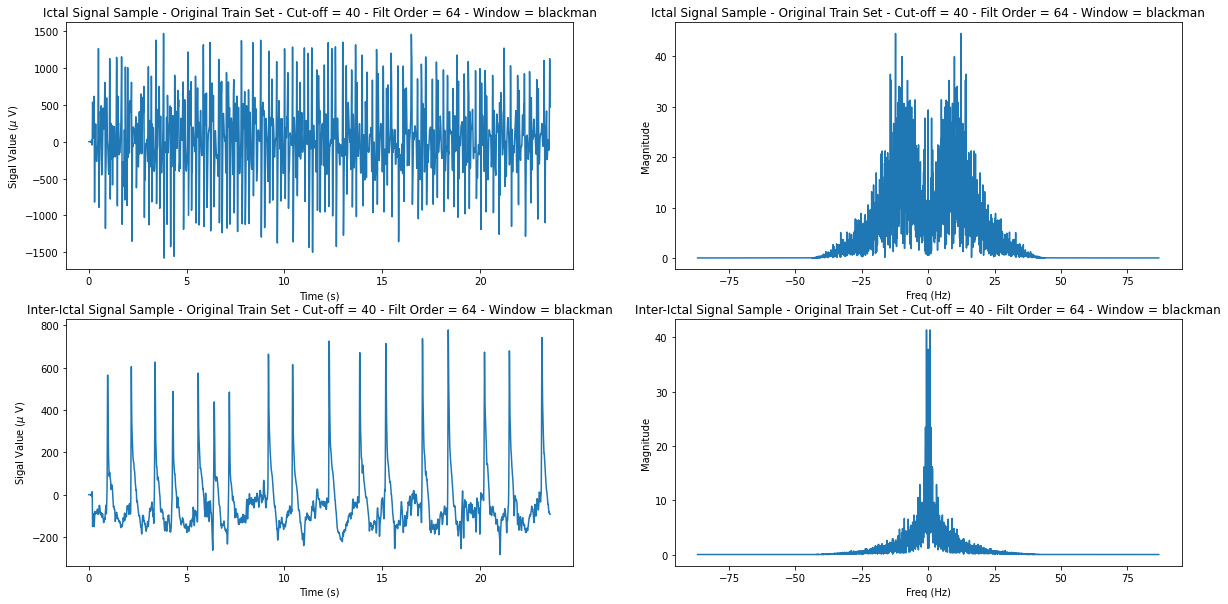

In [ ]:
plot_filteeg_samples(fir_filt_original_train, 40, 64, 'blackman', 20, nSamples, dataset_name = 'Original Train')

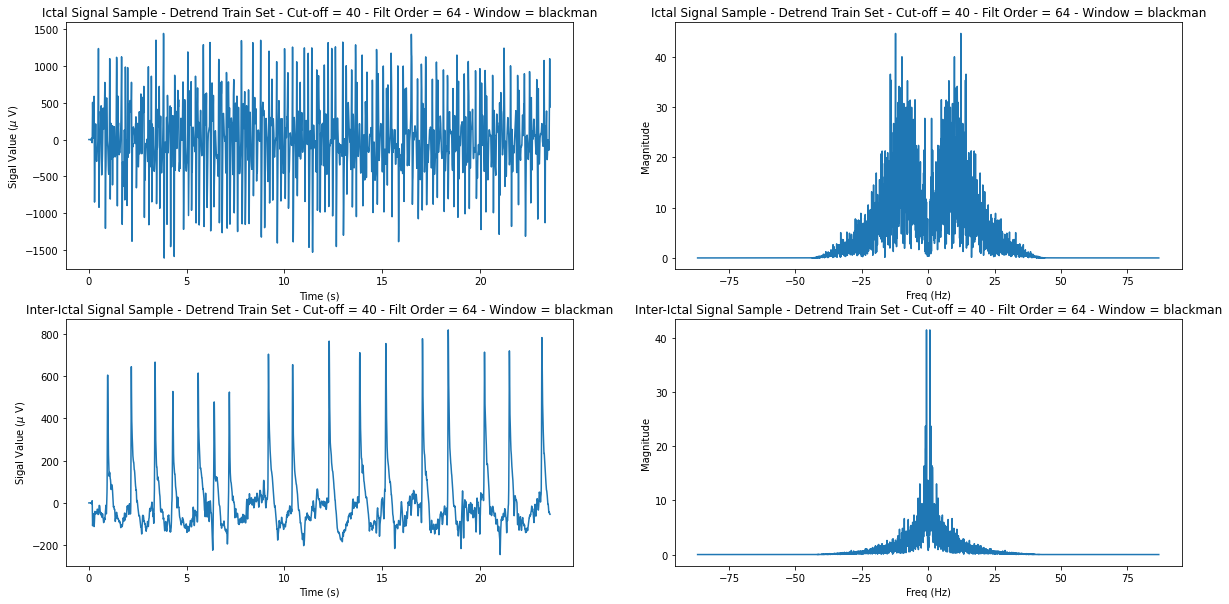

In [ ]:
plot_filteeg_samples(fir_filt_detrend_train, 40, 64, 'blackman', 20, nSamples, dataset_name = 'Detrend Train')

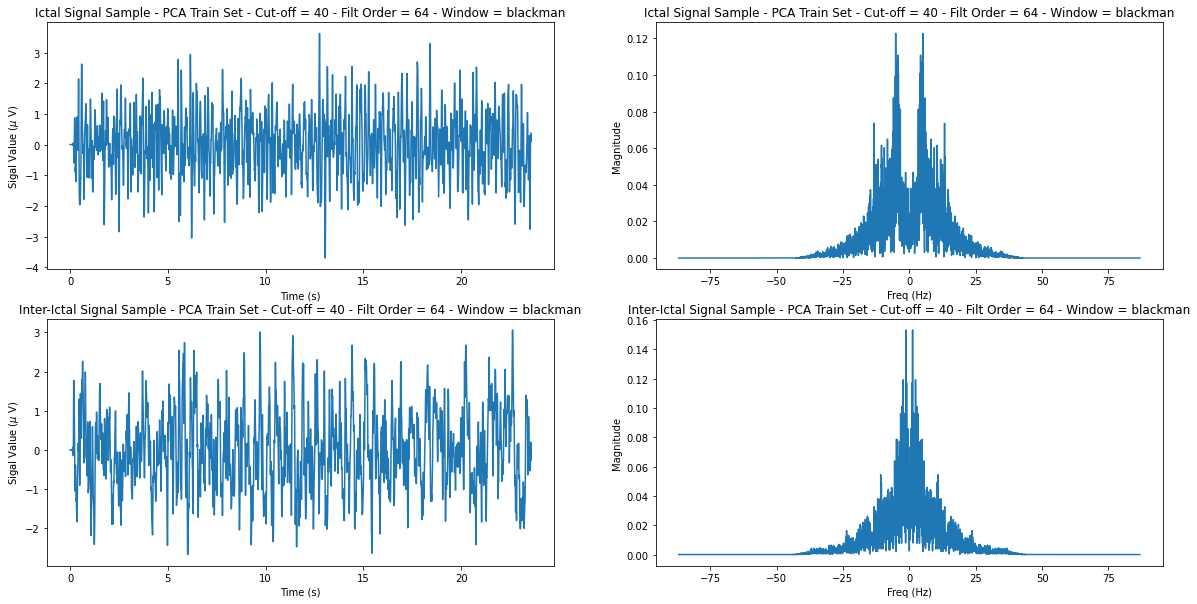

In [ ]:
plot_filteeg_samples(fir_filt_pca_train, 40, 64, 'blackman', 20, nSamples, dataset_name = 'PCA Train')

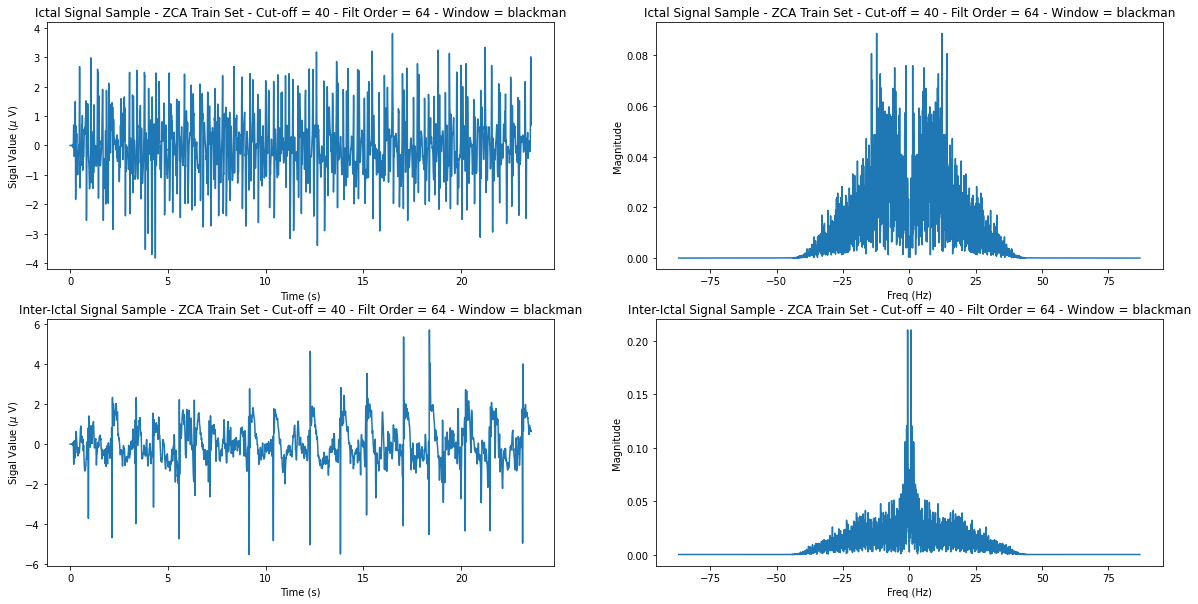

In [ ]:
plot_filteeg_samples(fir_filt_zca_train, 40, 64, 'blackman', 20, nSamples, dataset_name = 'ZCA Train')

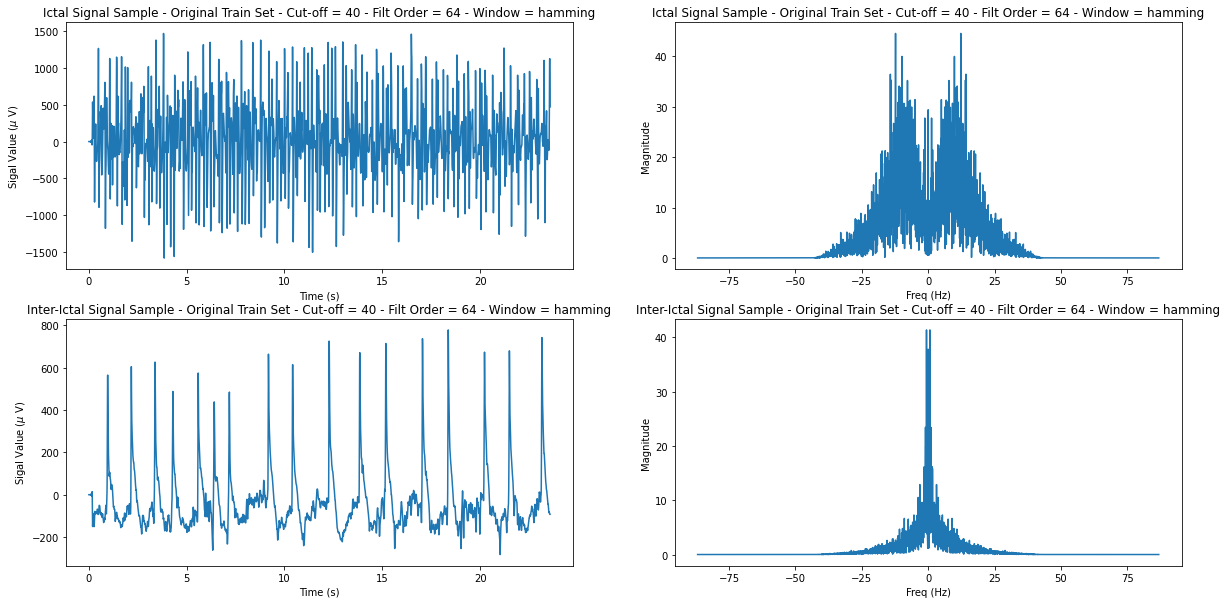

In [ ]:
plot_filteeg_samples(fir_filt_original_train, 40, 64, 'hamming', 20, nSamples, dataset_name = 'Original Train')

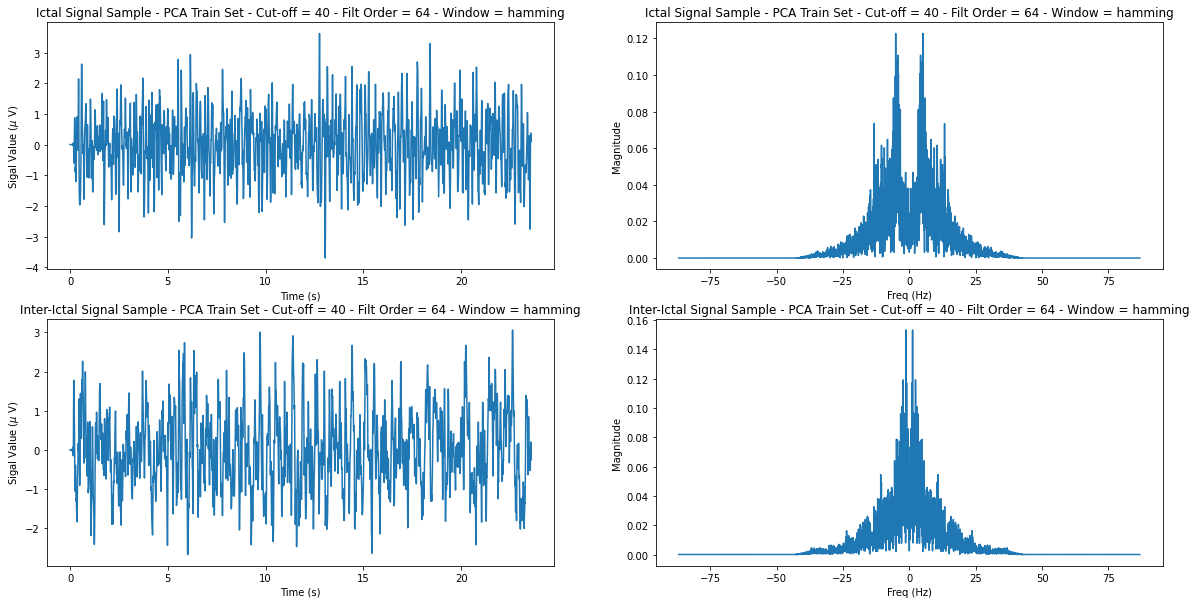

In [ ]:
plot_filteeg_samples(fir_filt_pca_train, 40, 64, 'hamming', 20, nSamples, dataset_name = 'PCA Train')

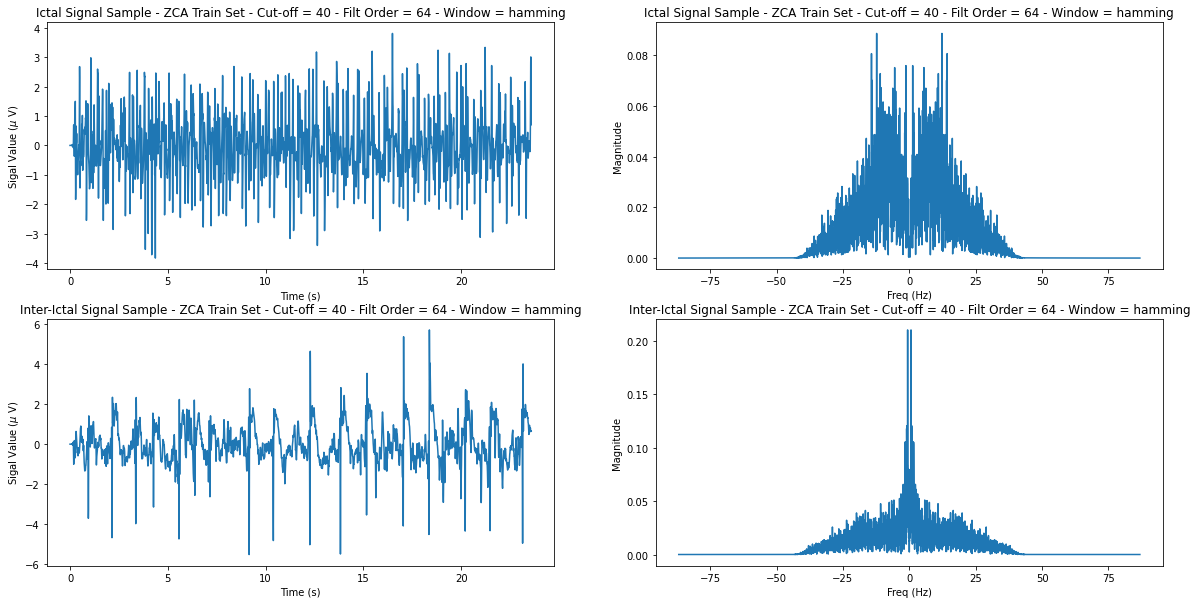

In [ ]:
plot_filteeg_samples(fir_filt_zca_train, 40, 64, 'hamming', 20, nSamples, dataset_name = 'ZCA Train')

In [ ]:
def eval_dict_create(orig_filt, filt_dict, Sub_Dir, cut_off, filter_order, window_names, nSamples, f_vect):
  results_dict = {}
  for i, data_dir in enumerate(Sub_Dir):
    results_dict[data_dir] = {}

    for passfreq in cut_off:
      results_dict[data_dir][passfreq] = {}

      for forder in filter_order:
        results_dict[data_dir][passfreq][forder] = {}

        for windname in window_names:
          results_dict[data_dir][passfreq][forder][windname] = {'SD': 0, 'NR': 0}

          filt_signal_set = filt_dict[data_dir][passfreq][forder][windname]
          sig_dist, noise_red = eval_filtering(orig_filt[data_dir], filt_signal_set, nSamples, f_vect, cutoff = 40)

          results_dict[data_dir][passfreq][forder][windname]['SD'] = sig_dist
          results_dict[data_dir][passfreq][forder][windname]['NR'] = noise_red
  return results_dict

In [ ]:
fir_filt_original_train_eval = eval_dict_create(train_dict, fir_filt_original_train, Sub_Dir, cut_off, filter_order, window_names, nSamples, f_vect)
fir_filt_detrend_train_eval = eval_dict_create(detrend_train, fir_filt_detrend_train, Sub_Dir, cut_off, filter_order, window_names, nSamples, f_vect)
fir_filt_pca_train_eval = eval_dict_create(pca_train, fir_filt_pca_train, Sub_Dir, cut_off, filter_order, window_names, nSamples, f_vect)
fir_filt_zca_train_eval = eval_dict_create(zca_train, fir_filt_zca_train, Sub_Dir, cut_off, filter_order, window_names, nSamples, f_vect)

fir_filt_original_test_eval = eval_dict_create(train_dict, fir_filt_original_test, Sub_Dir, cut_off, filter_order, window_names, nSamples, f_vect)
fir_filt_detrend_test_eval = eval_dict_create(detrend_train, fir_filt_detrend_test, Sub_Dir, cut_off, filter_order, window_names, nSamples, f_vect)
fir_filt_pca_test_eval = eval_dict_create(pca_train, fir_filt_pca_test, Sub_Dir, cut_off, filter_order, window_names, nSamples, f_vect)
fir_filt_zca_test_eval = eval_dict_create(zca_train, fir_filt_zca_test, Sub_Dir, cut_off, filter_order, window_names, nSamples, f_vect)

In [ ]:
# dump_results(fir_filt_original_train_eval, 'fir_filt_original_train_eval', RESULTS_DIR, 'fir_filtering')
# dump_results(fir_filt_detrend_train_eval, 'fir_filt_detrend_train_eval', RESULTS_DIR, 'fir_filtering')
# dump_results(fir_filt_pca_train_eval, 'fir_filt_pca_train_eval', RESULTS_DIR, 'fir_filtering')
# dump_results(fir_filt_zca_train_eval, 'fir_filt_zca_train_eval', RESULTS_DIR, 'fir_filtering')

# dump_results(fir_filt_original_test_eval, 'fir_filt_original_test_eval', RESULTS_DIR, 'fir_filtering')
# dump_results(fir_filt_detrend_test_eval, 'fir_filt_detrend_test_eval', RESULTS_DIR, 'fir_filtering')
# dump_results(fir_filt_pca_test_eval, 'fir_filt_pca_test_eval', RESULTS_DIR, 'fir_filtering')
# dump_results(fir_filt_zca_test_eval, 'fir_filt_zca_test_eval', RESULTS_DIR, 'fir_filtering')

In [ ]:
def graph_filt_eval(eval_dict, dataset, filter_orders, window_name, cutoff = 40):
  eval_s = []
  eval_n = []

  for forder in filter_orders:
    values = eval_dict[dataset][cutoff][forder][window_name]
    eval_s.append(values['SD'])
    eval_n.append(values['NR'])
  
  fig = plt.figure(figsize = (5, 5))
  ax = fig.add_subplot(111)

  ax.scatter(eval_n, eval_s)
  ax.set_ylabel('Signal Distortion (dB)')
  ax.set_xlabel('Noise Reduction (dB)')
  ax.set_title(f'FIR Evaluation for dataset {dataset}: {window_name} window')

  for n, x, y in zip(filter_order, eval_n, eval_s):                                       
      ax.annotate('N = %d' % n, xy=(x, y), textcoords = 'data')
  ax.grid()
  plt.show()
  return

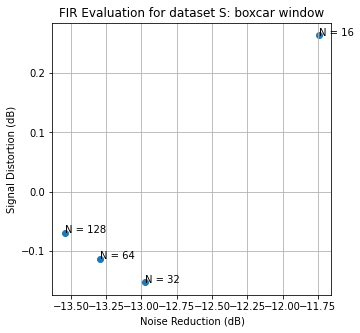

In [ ]:
graph_filt_eval(fir_filt_original_train_eval, 'S', filter_order, 'boxcar', cutoff = 40)

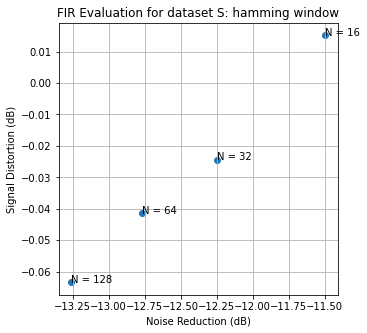

In [ ]:
graph_filt_eval(fir_filt_original_train_eval, 'S', filter_order, 'hamming', cutoff = 40)

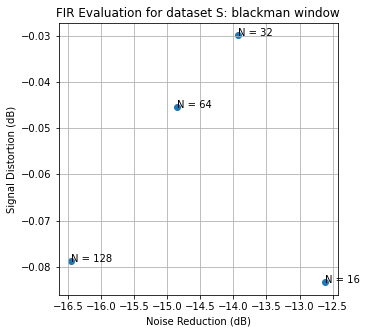

In [ ]:
graph_filt_eval(fir_filt_pca_train_eval, 'S', filter_order, 'blackman', cutoff = 40)

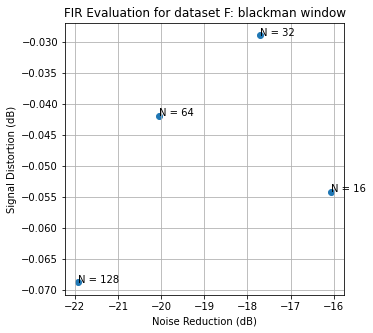

In [ ]:
graph_filt_eval(fir_filt_pca_train_eval, 'F', filter_order, 'blackman', cutoff = 40)

### Step 04: Alternative Method

***DWT Filtering***

As an alternative method, Discrete Wavelet Transformation will be used to filter out the high-frequency noise components. For this, the signals will be filtered with DWT Filter Bank where the effect of the following parameters will be explored:
1. Analysis Filter Type (Wavlet)

For denoising purpose, I am keeping the number of levels a constant as the change of levels do not change the high resolution components that are used for denoising. 

__Decimation at 173.61hz with a Daubechies 4 wavelet__

- D1: 43.40 - 86.805 (Gamma)

- D2: 21.7 - 43.40 (Beta/Gamma)

- D3: 10.85 - 21.7 (Beta)

- D4: 5.43 - 10.85 (Alpha)

- D5: 2.71 - 5.43 (Theta)

- D6: 1.36 - 2.71 (Delta)

- A6: >1.36 (Delta/DC)

In [ ]:
from pywt import wavedec, waverec, Wavelet

wavelets = ['db2', 'db4', 'db6', 'db8', 'haar']

# number of levels we are interested in
level = 6

def plot_dwts(analys_wave, denoise_wave, data_dir, wavelet, sample_no):
  
  if data_dir == 'S':
    title_str = f'Ictal Signal'
  else:
    title_str = f'Inter-Ictal Signal'
  
  figure(figsize = (10, 10))
  subplot(2,2,1)
  plot(analys_wave[-1][sample_no])
  title(title_str + f' DWT Analysis with {wavelet}\n(Highest Resolution)')
  xlabel('Samples (n)'); ylabel(r'DWT COefficients ($\mu$ V)')

  subplot(2,2,2)
  plot(denoise_wave[-1][sample_no])
  title(title_str + f' DWT Denoised with {wavelet}\n(Highest Resolution)')
  xlabel('Samples (n)'); ylabel(r'DWT COefficients ($\mu$ V)')

  subplot(2,2,3)
  plot(analys_wave[-2][sample_no])
  title(title_str + f' DWT Analysis with {wavelet}\n(Next Highest Resolution)')
  xlabel('Samples (n)'); ylabel(r'DWT COefficients ($\mu$ V)')

  subplot(2,2,4)
  plot(denoise_wave[-2][sample_no])
  title(title_str + f' DWT Denoised with {wavelet}\n(Next Highest Resolution)')
  xlabel('Samples (n)'); ylabel(r'DWT COefficients ($\mu$ V)')
  plt.tight_layout()
  return

In [ ]:
from copy import deepcopy
def plot_wavelet(wavelets, level = 6):

    fig, axs = plt.subplots(1, 5, figsize=(20,5), squeeze =True, sharex=True, sharey=True)
    axs = axs.flatten()
    for i, wavelet_name in enumerate(wavelets):
      wavelet = Wavelet(wavelet_name)
      try:
          [psi, x] = wavelet.wavefun(level = level)
      except:
          [phi, psi, x] = wavelet.wavefun(level = level)

      axs[i].plot(x, psi)
      axs[i].set_title(f'{wavelet_name} at level = {level}')

    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.tight_layout()
    plt.show()
    return

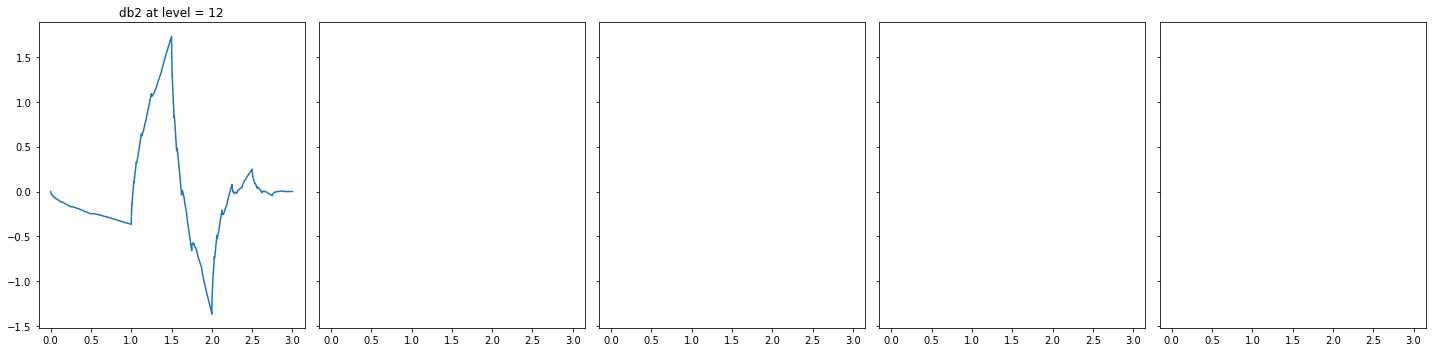

In [ ]:
plot_wavelet(wavelets, 12)

In [ ]:
import copy

def dwt_denoising_synthesis(Sub_Dir, data_dict, wavelets, sample_no, level = 6):
  dwt_synth = {}

  for data_dir in Sub_Dir:
    dwt_synth[data_dir] = {}
    for wavlet in wavelets:
      # get the wavelet coefficients at each level in a list
      analysis_coeff = wavedec(data_dict[data_dir], wavelet = wavlet, mode = 'zero', level = level)
      threshold1 = 7 * np.std(analysis_coeff[-1], axis=1)
      threshold1 = np.expand_dims(threshold1, axis=1)

      threshold2 = 7 * np.std(analysis_coeff[-2], axis=1)
      threshold2 = np.expand_dims(threshold2, axis=1)

      denoised_coeff = copy.deepcopy(analysis_coeff)

      # Assuming highest resolution, remove the noise
      denoised_coeff[-1][denoised_coeff[-1] <= threshold1] = 0
      denoised_coeff[-2][denoised_coeff[-2] <= threshold2] = 0

      plot_dwts(analysis_coeff, denoised_coeff, data_dir, wavlet, sample_no)
      dwt_synth[data_dir][wavlet] = np.array(waverec(denoised_coeff, wavelet = wavlet, mode = 'zero'))[:, :nSamples]
  return dwt_synth

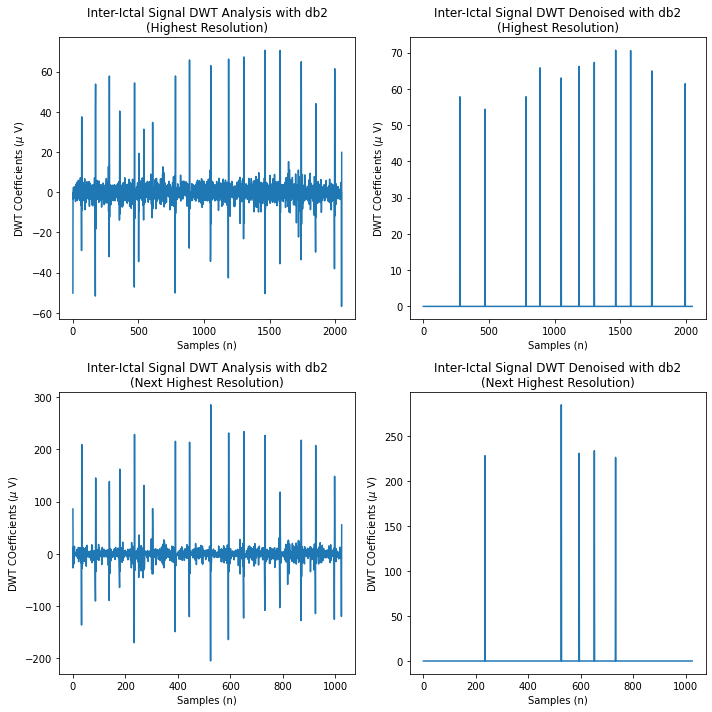

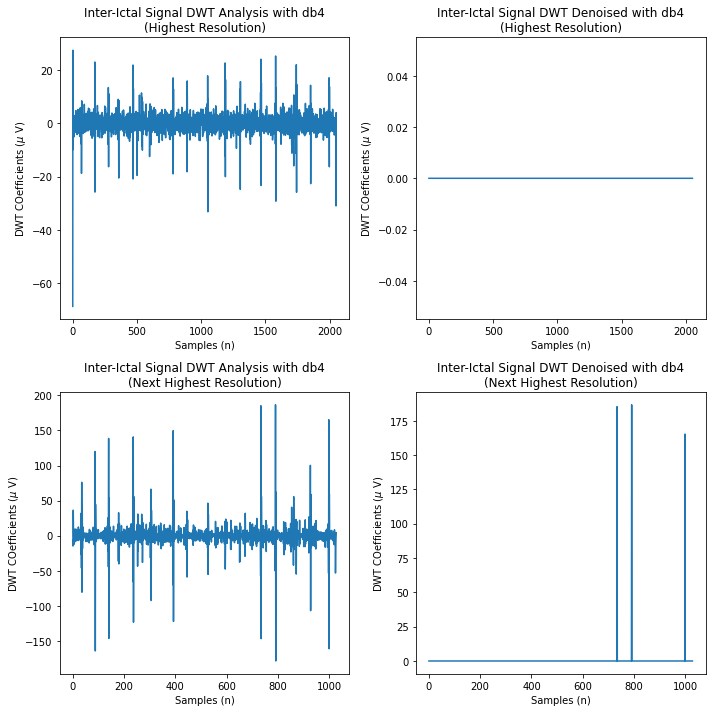

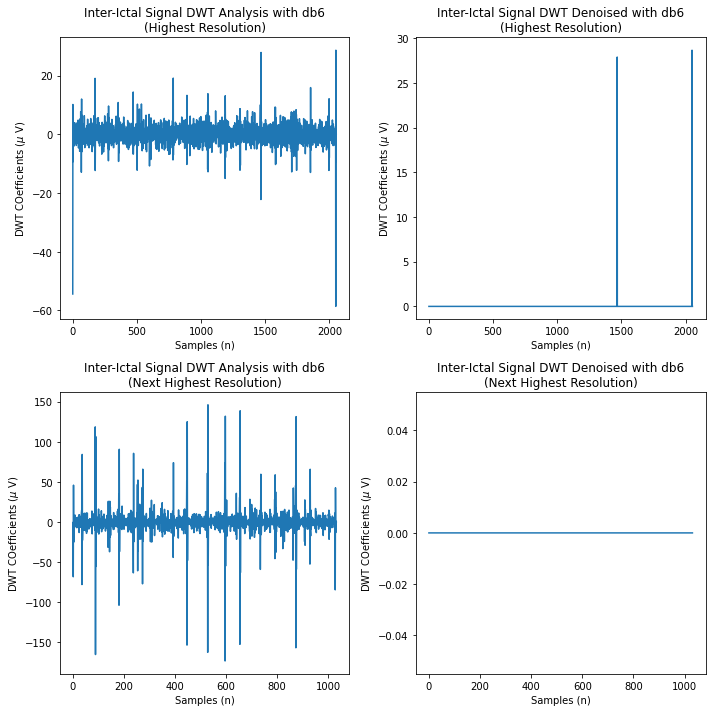

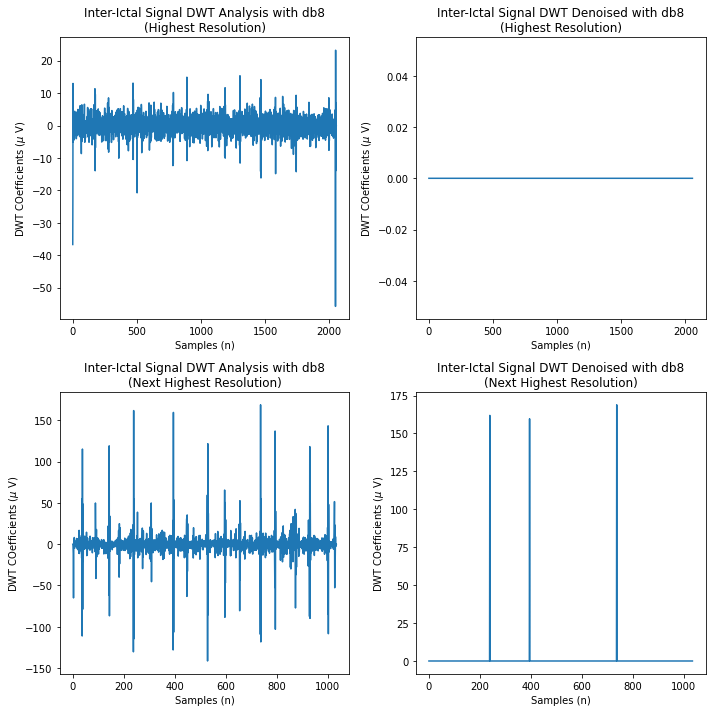

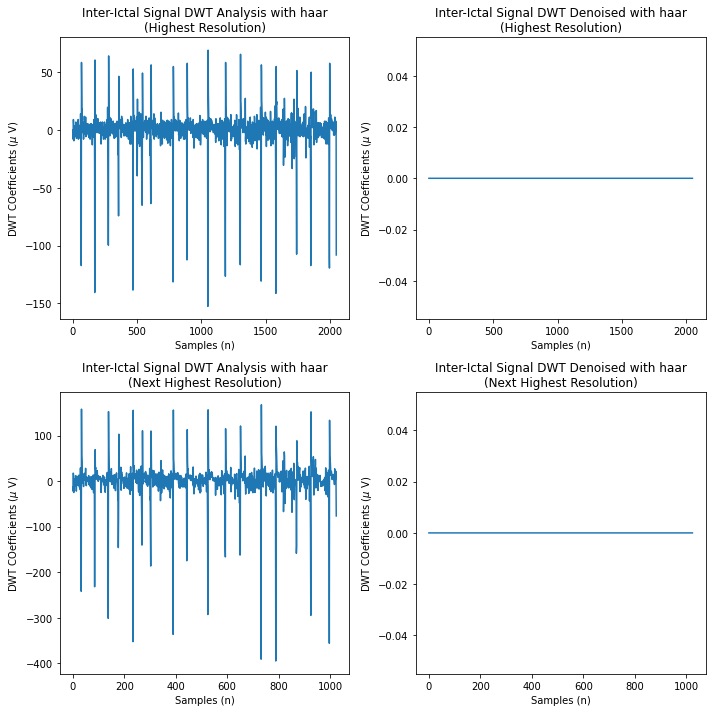

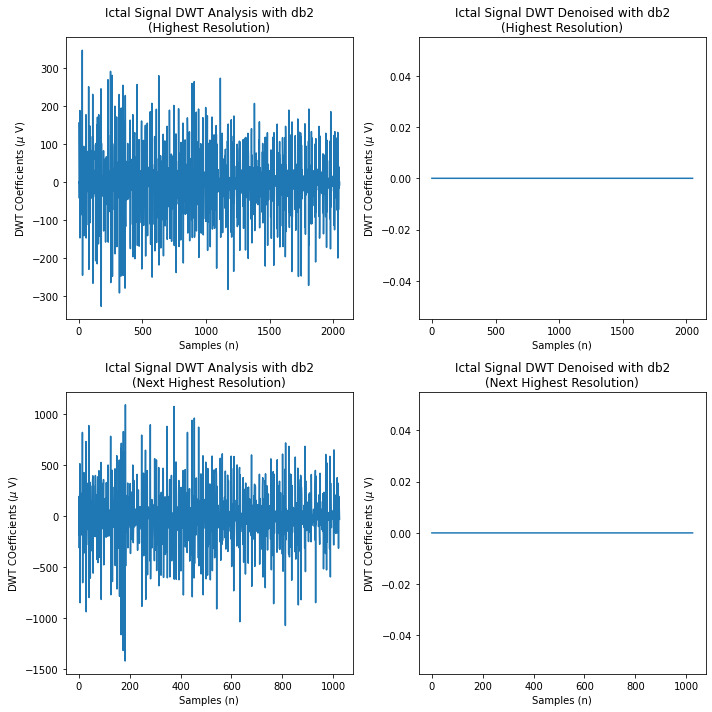

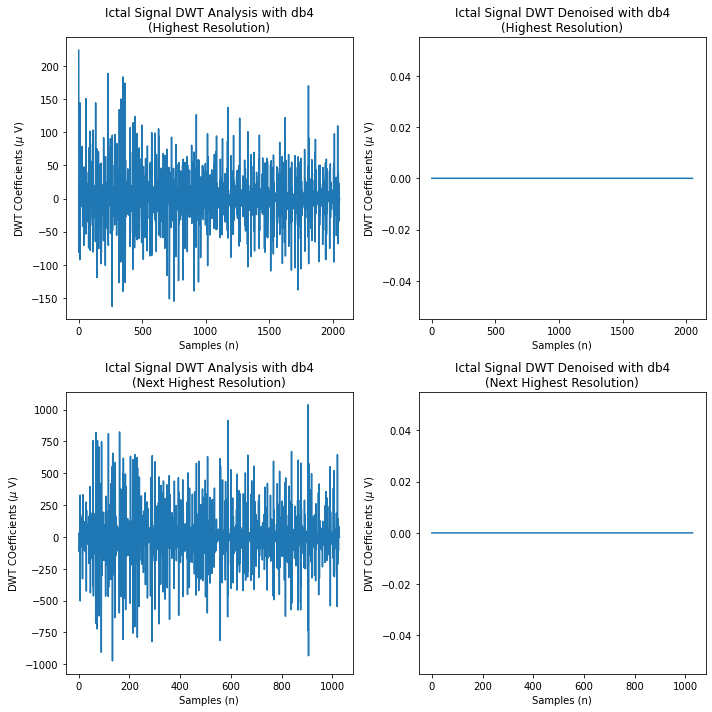

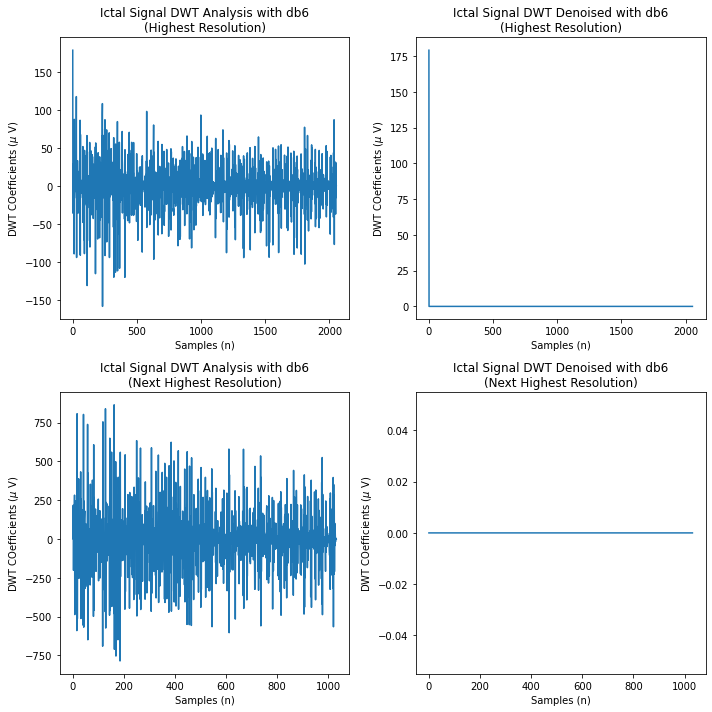

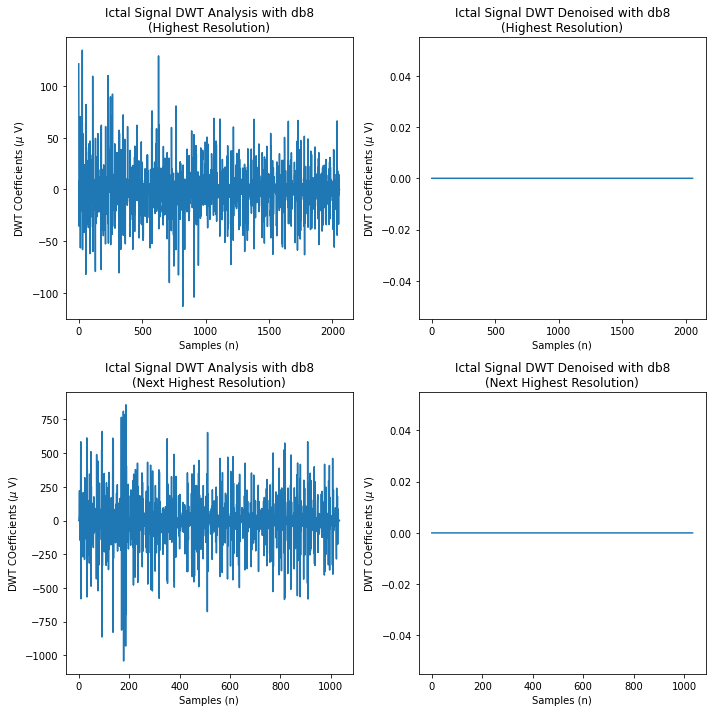

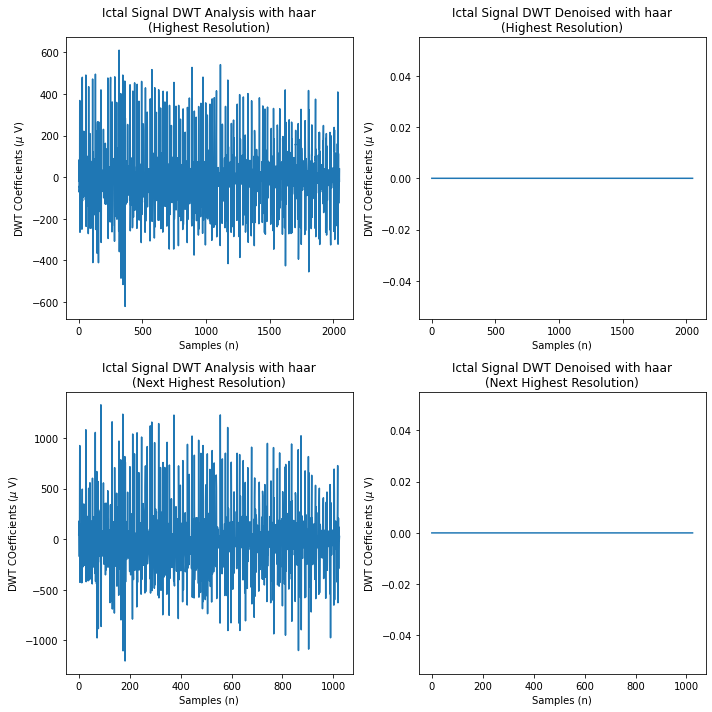

In [ ]:
dwt_synth_original_train = dwt_denoising_synthesis(Sub_Dir, train_dict, wavelets, sample_no = 20, level = 6)

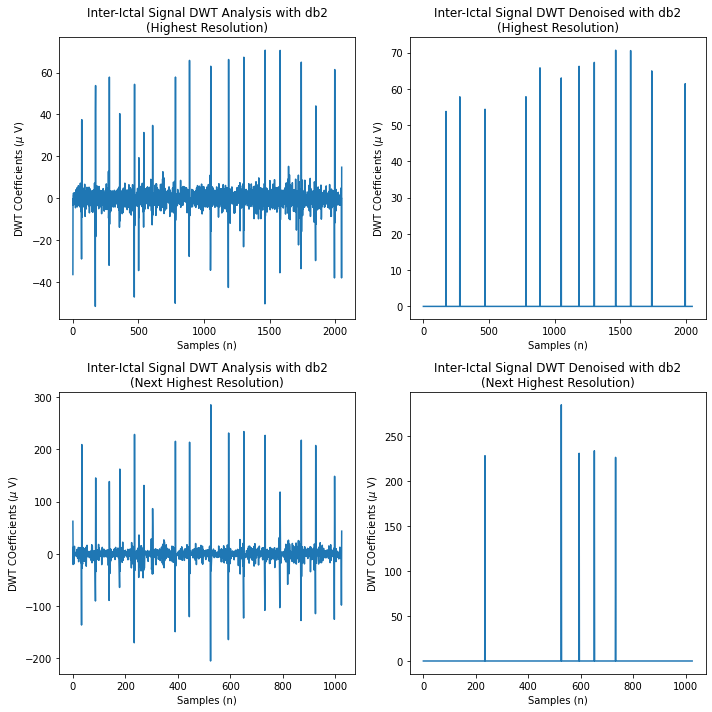

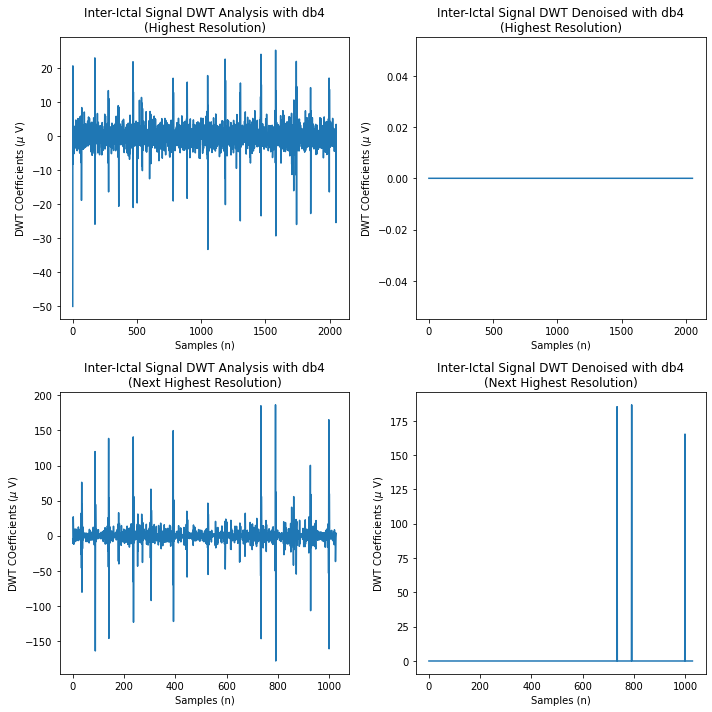

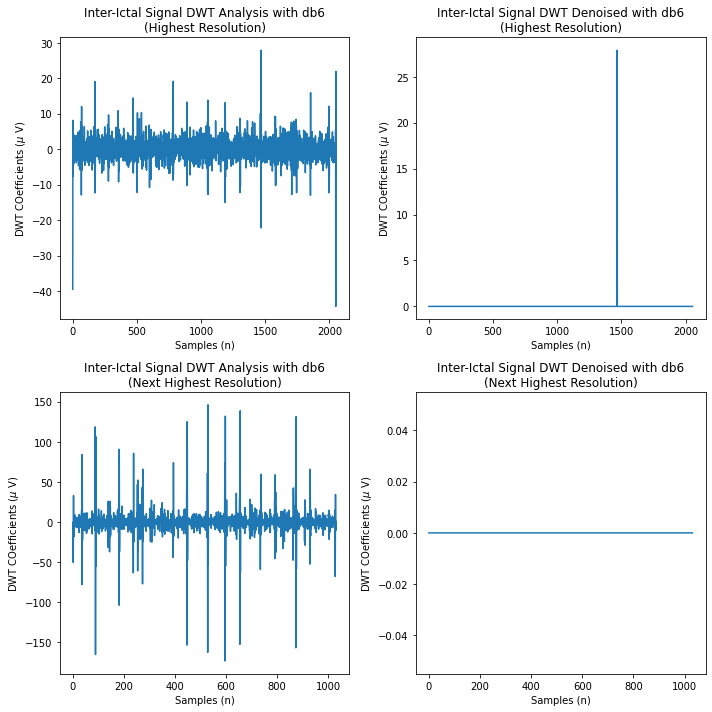

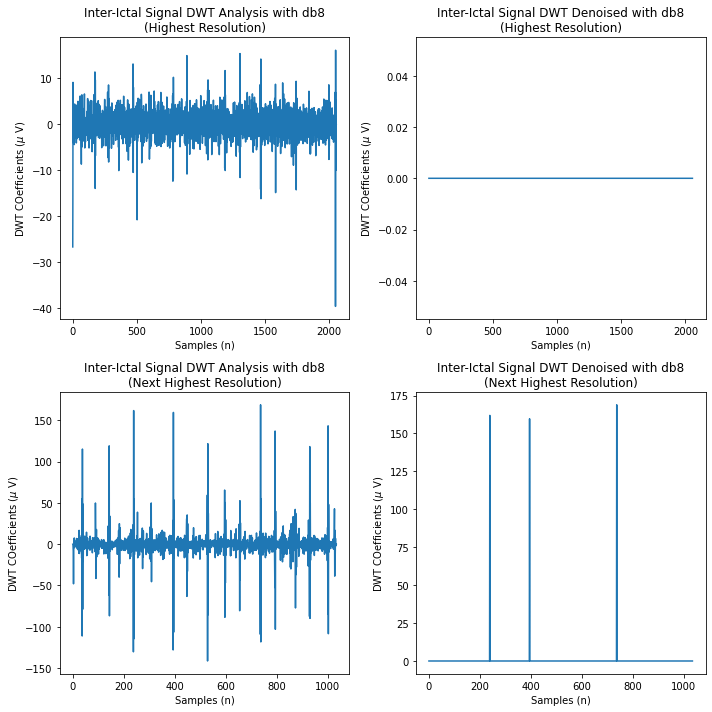

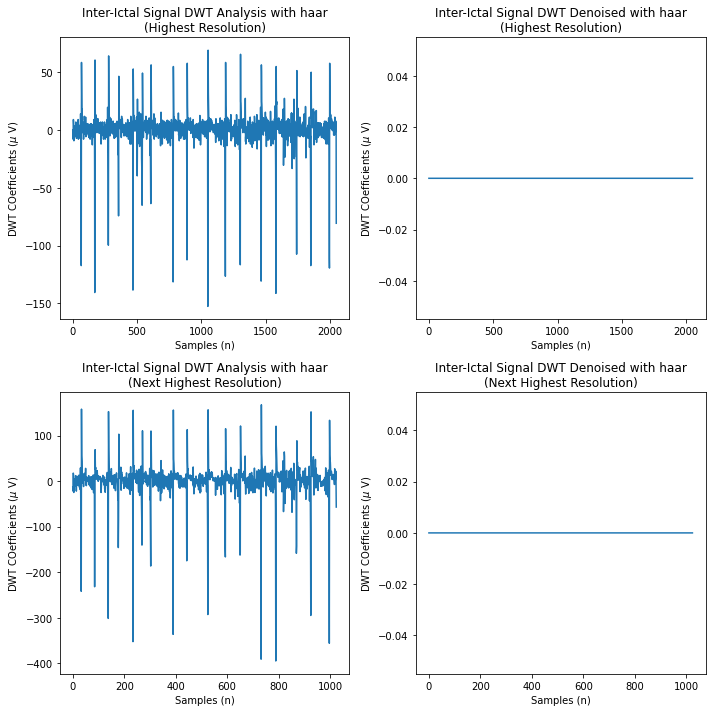

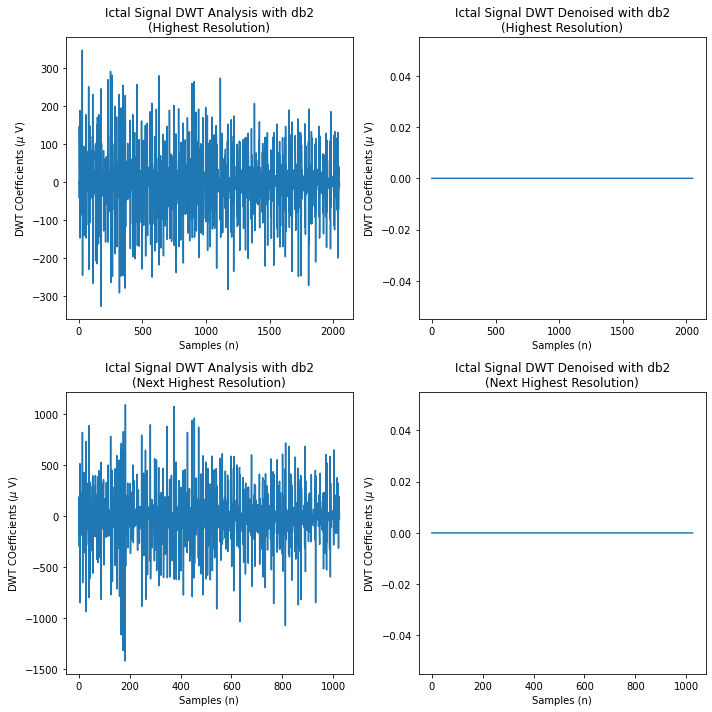

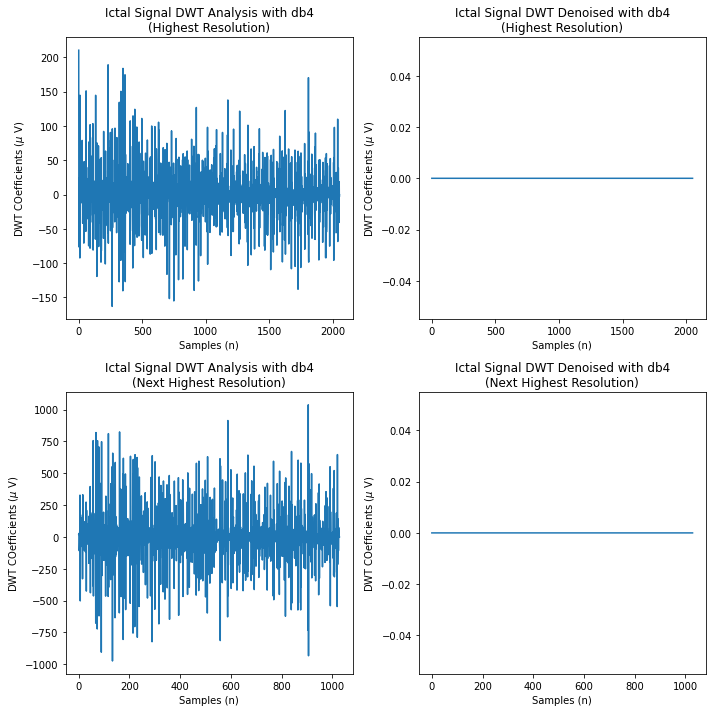

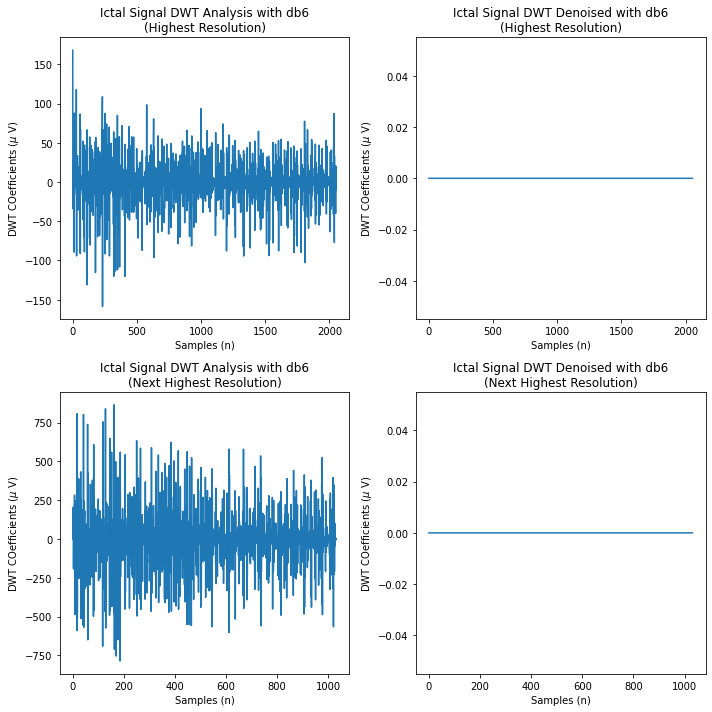

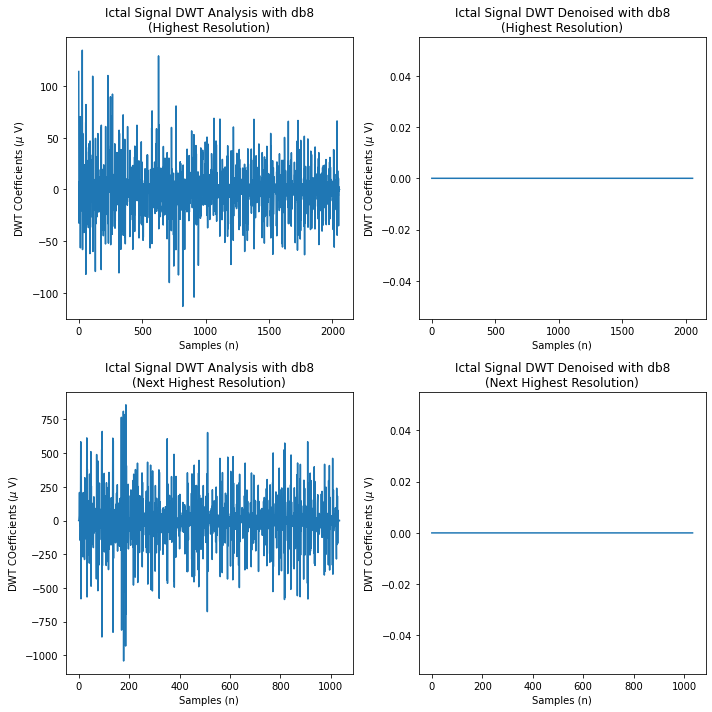

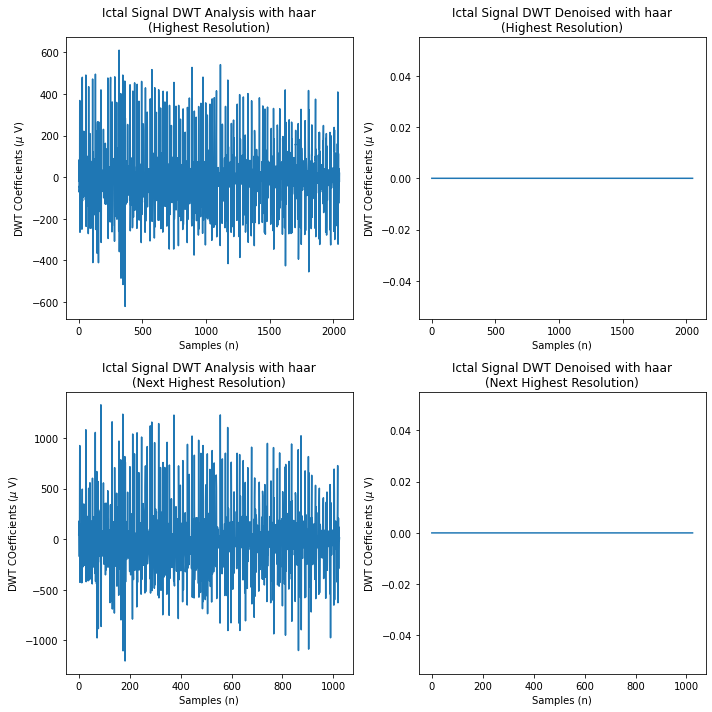

In [ ]:
dwt_synth_detrend_train = dwt_denoising_synthesis(Sub_Dir, detrend_train, wavelets, sample_no = 20, level = 6)

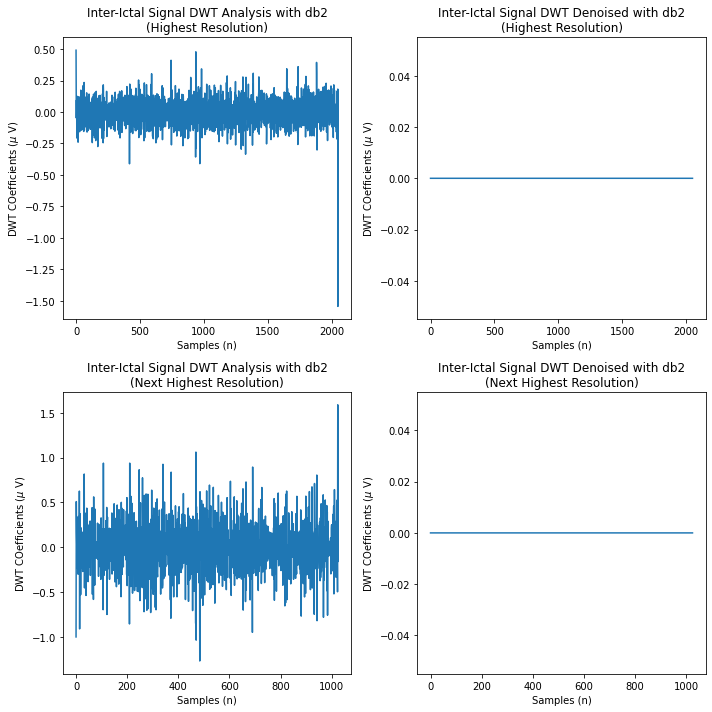

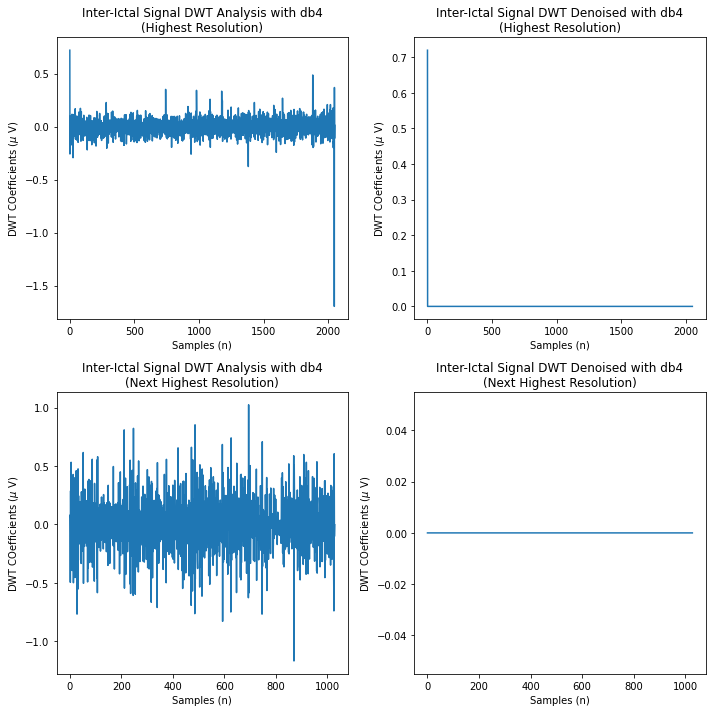

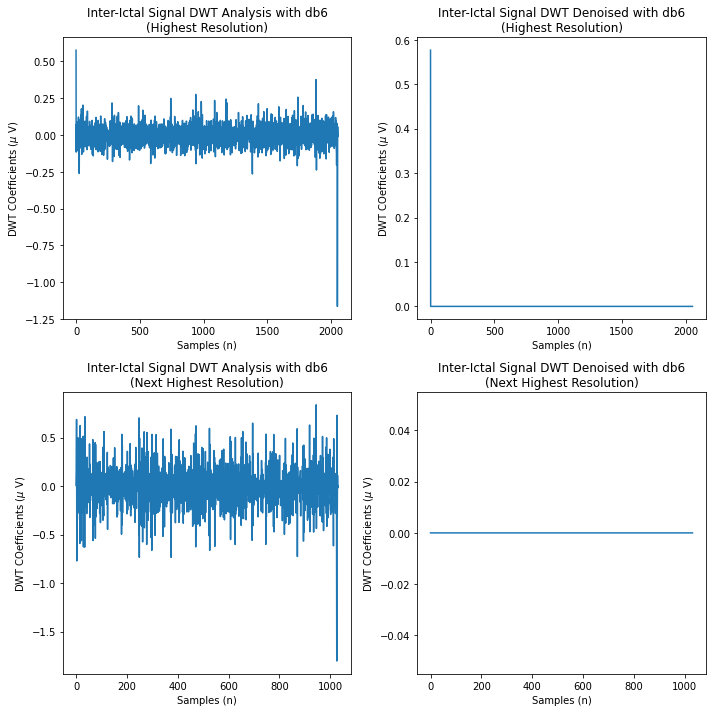

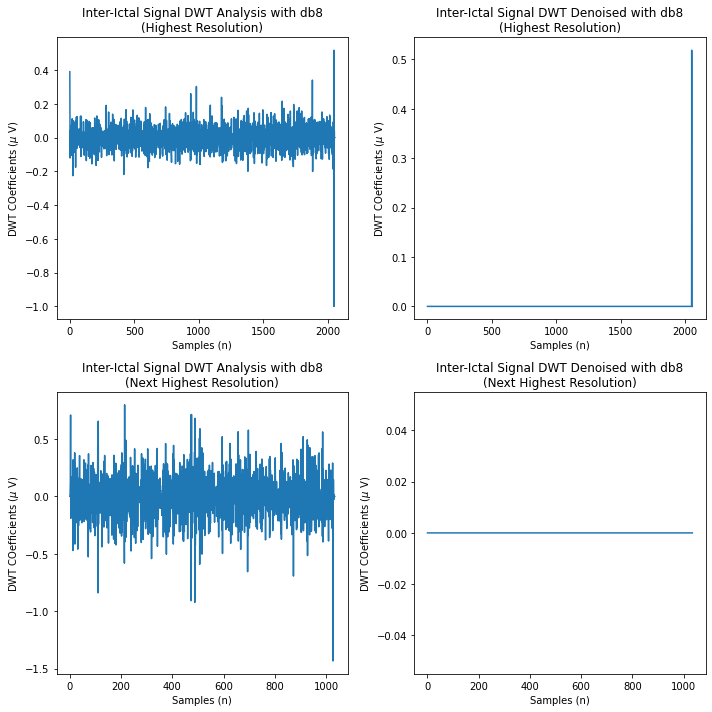

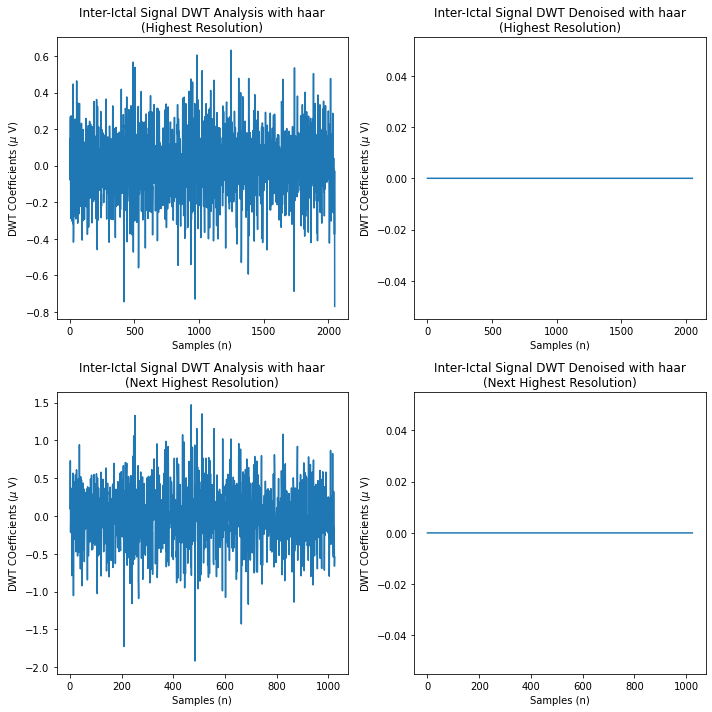

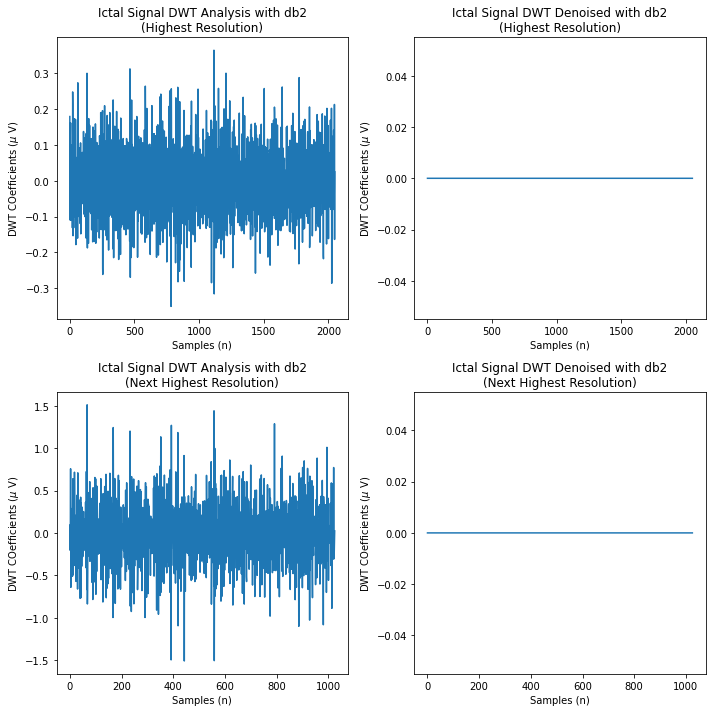

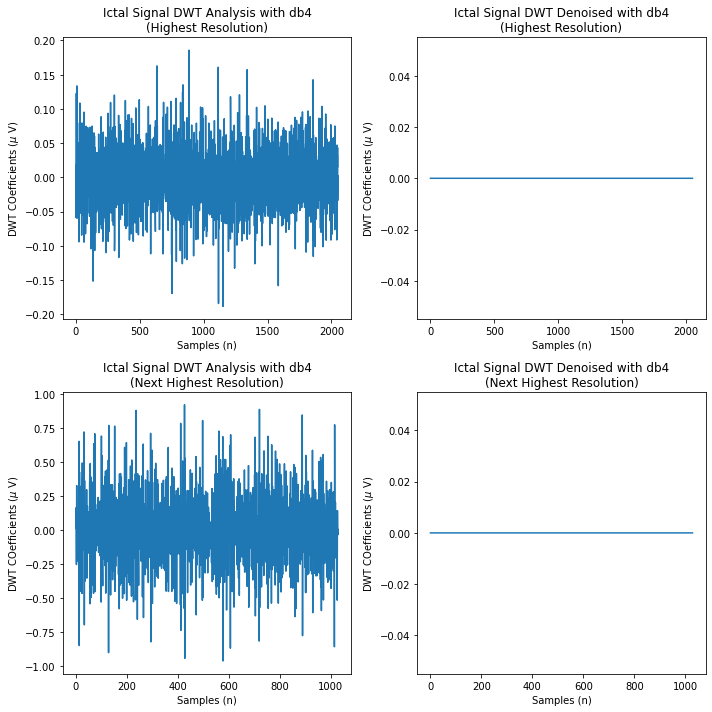

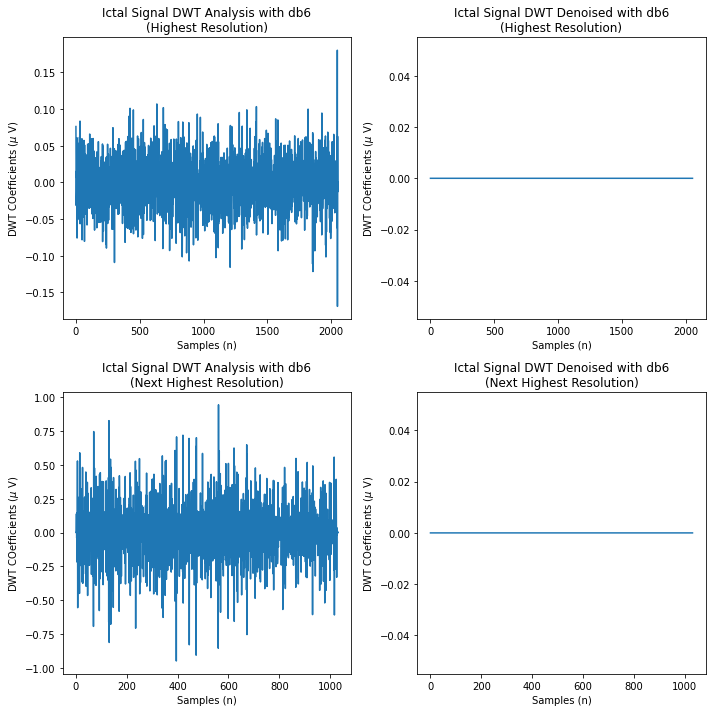

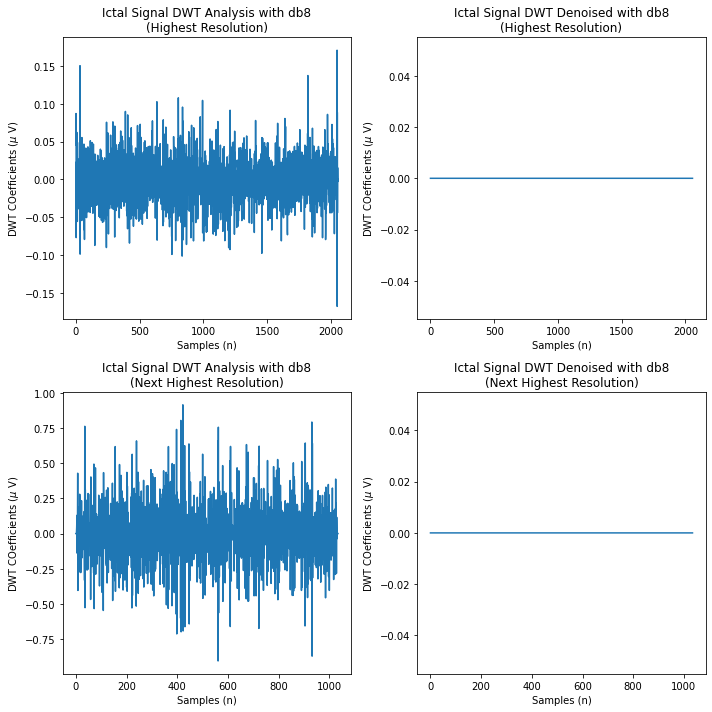

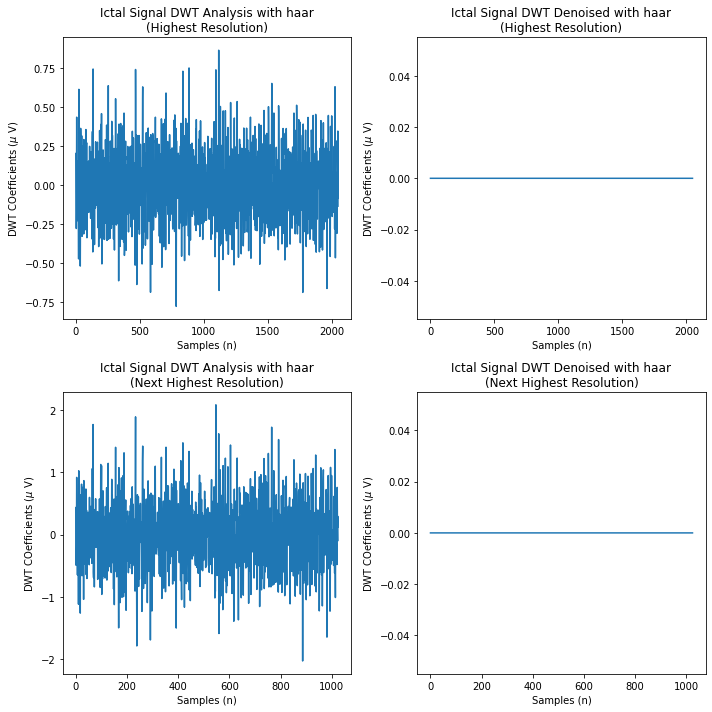

In [ ]:
dwt_synth_pca_train = dwt_denoising_synthesis(Sub_Dir, pca_train, wavelets, sample_no = 20, level = 6)

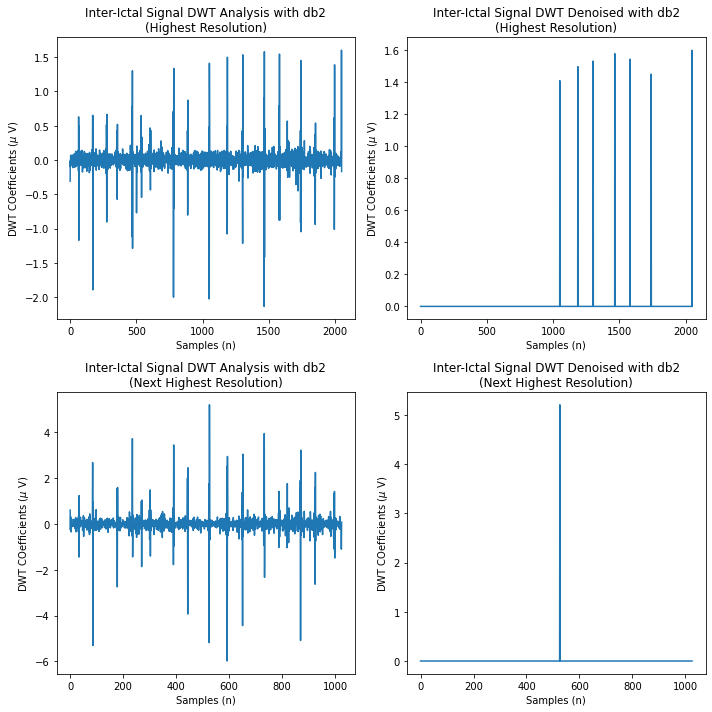

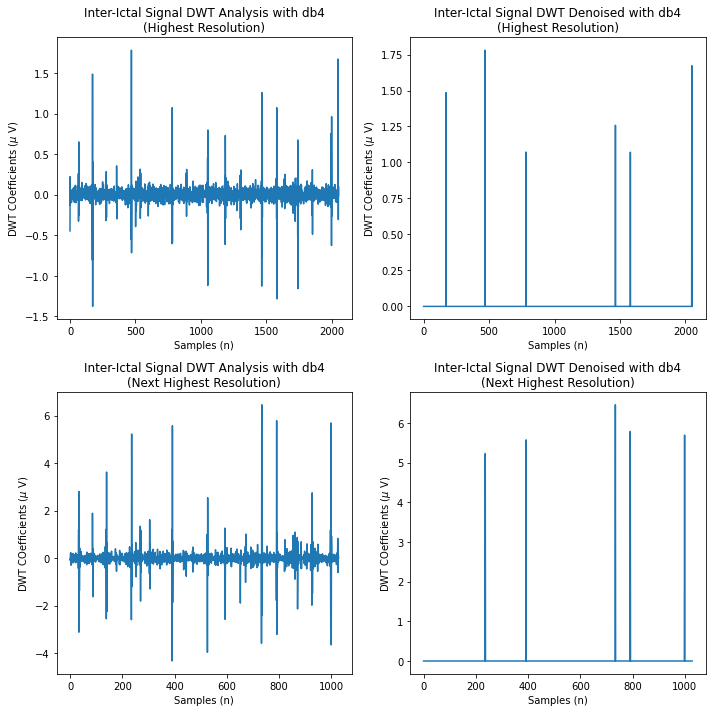

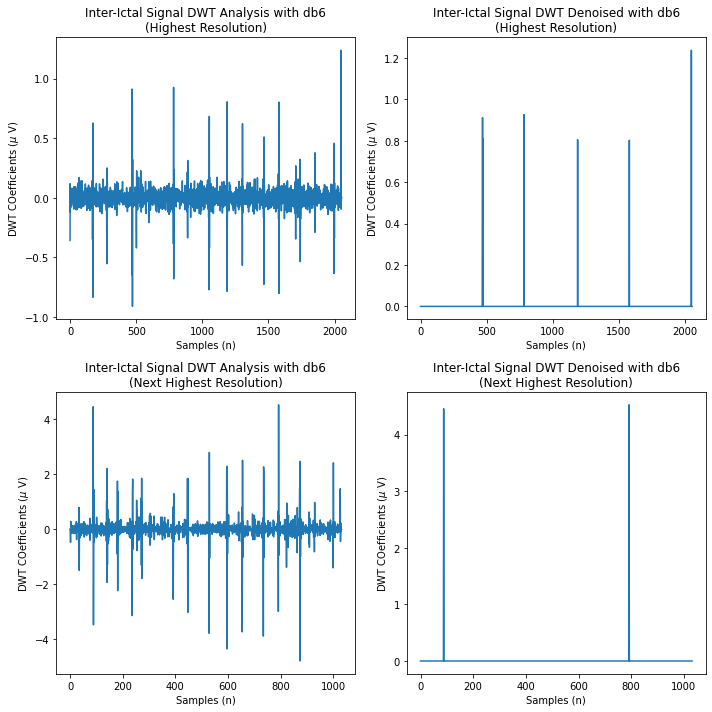

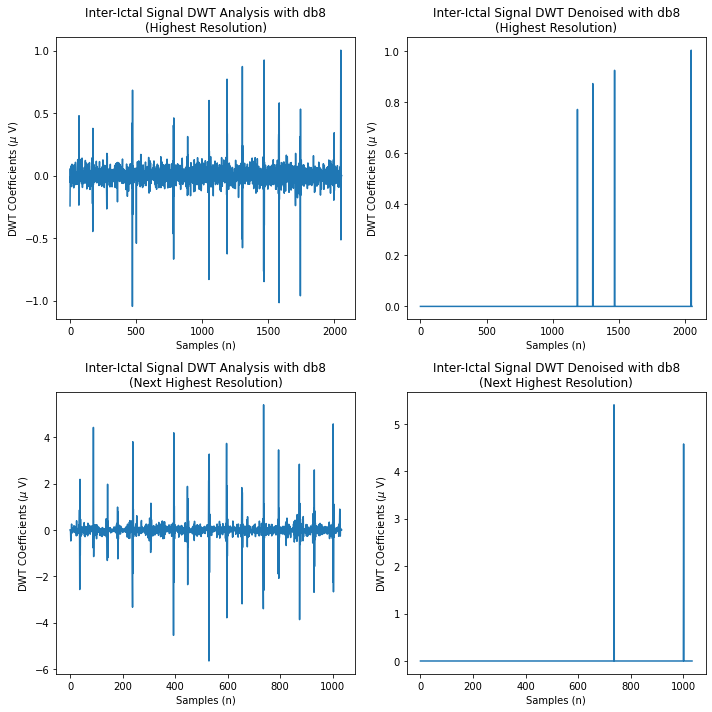

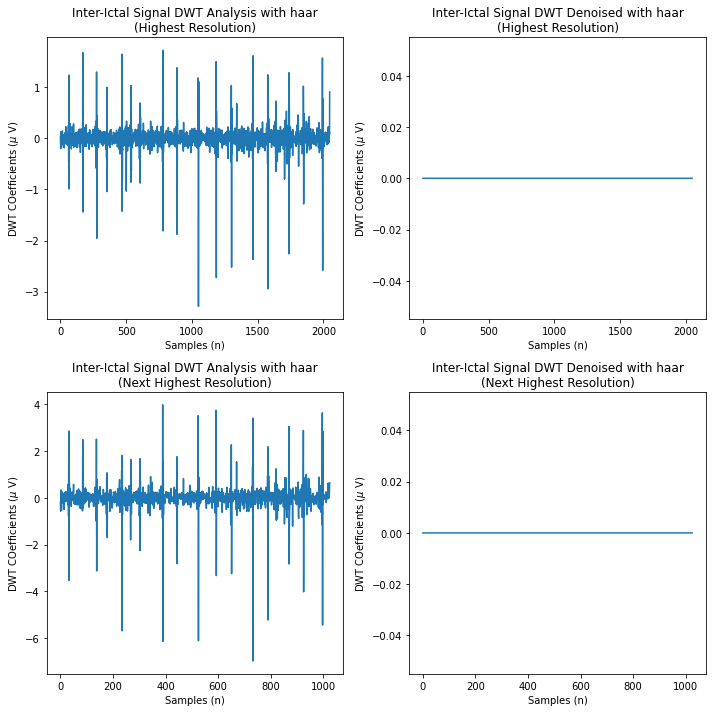

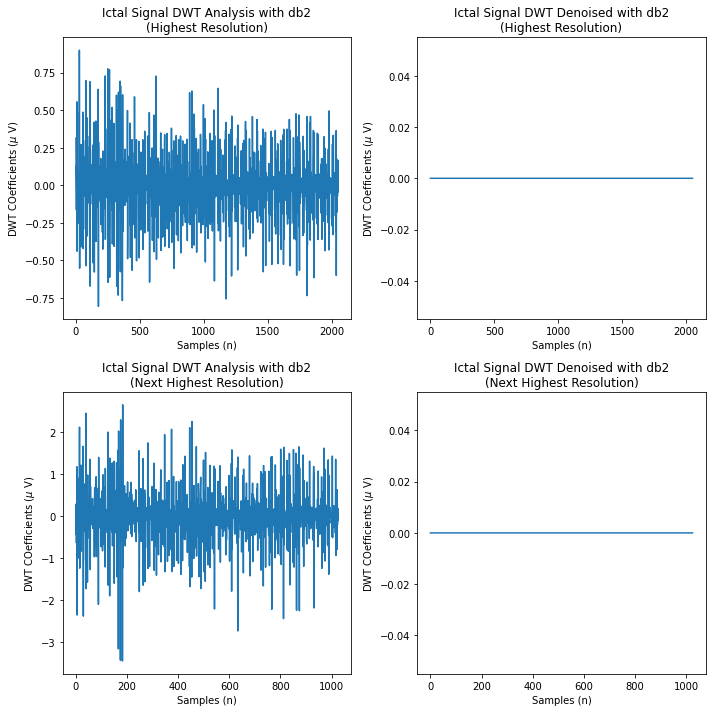

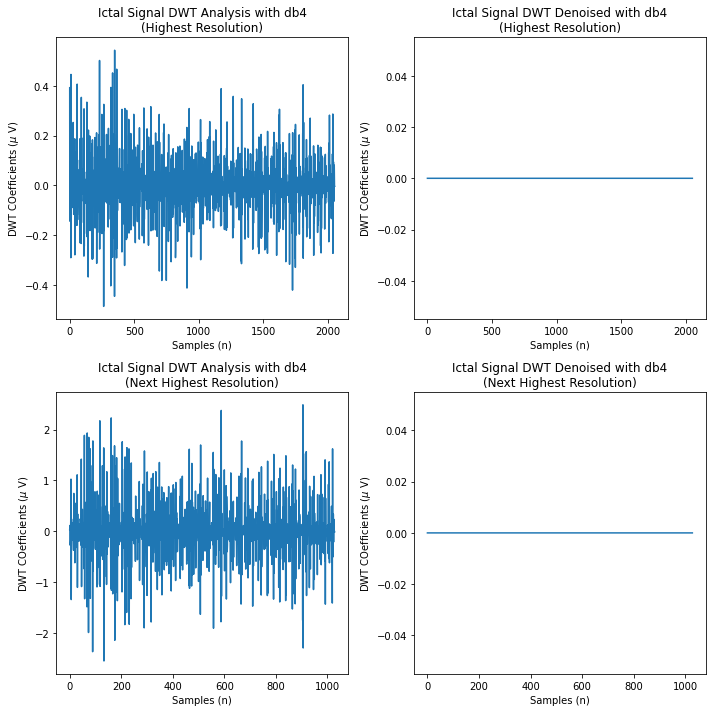

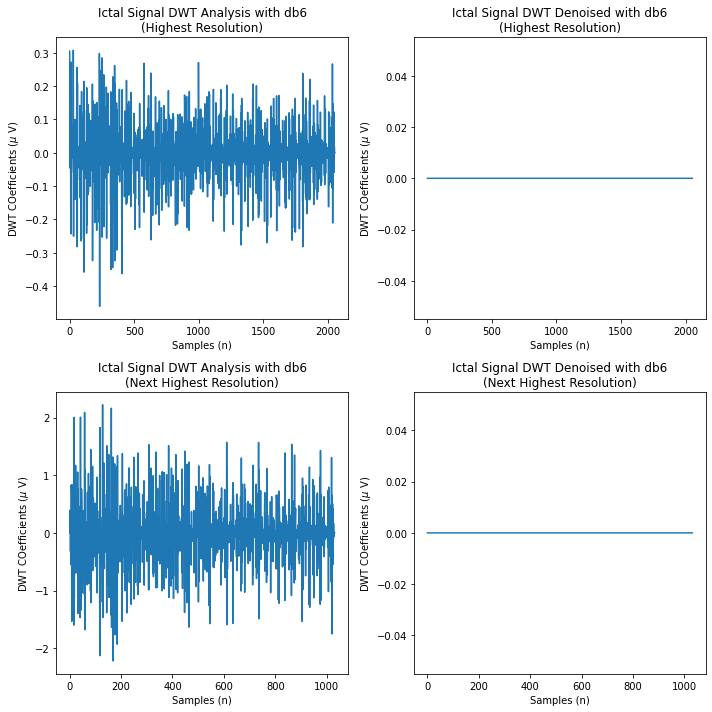

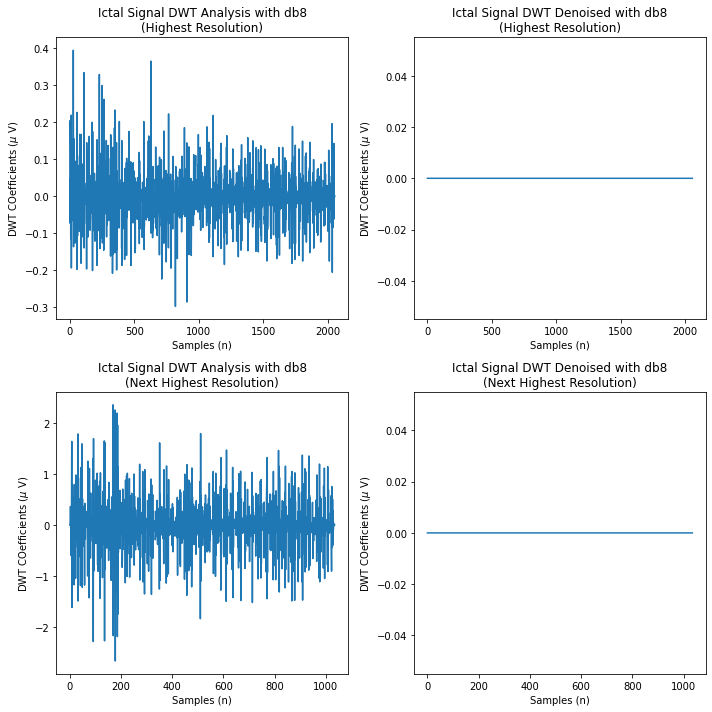

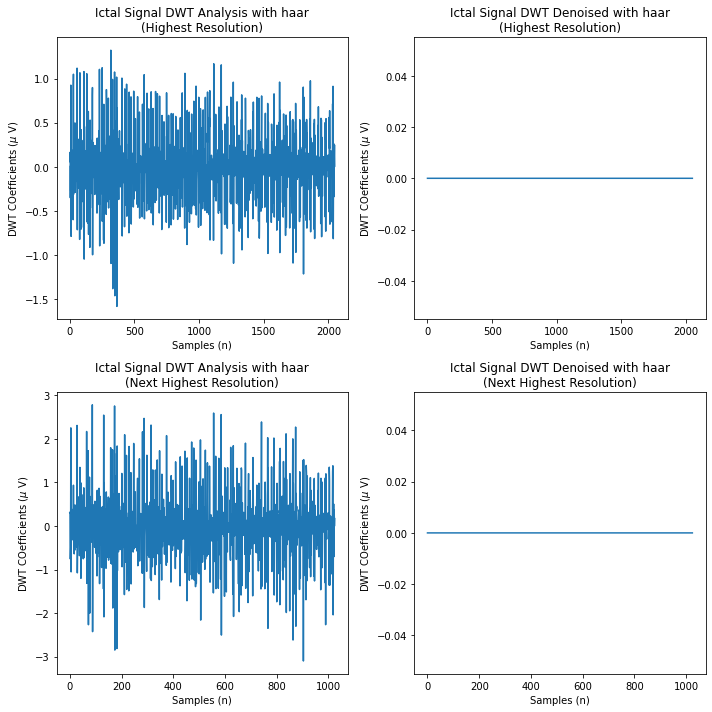

In [ ]:
dwt_synth_zca_train = dwt_denoising_synthesis(Sub_Dir, zca_train, wavelets, sample_no = 20, level = 6)

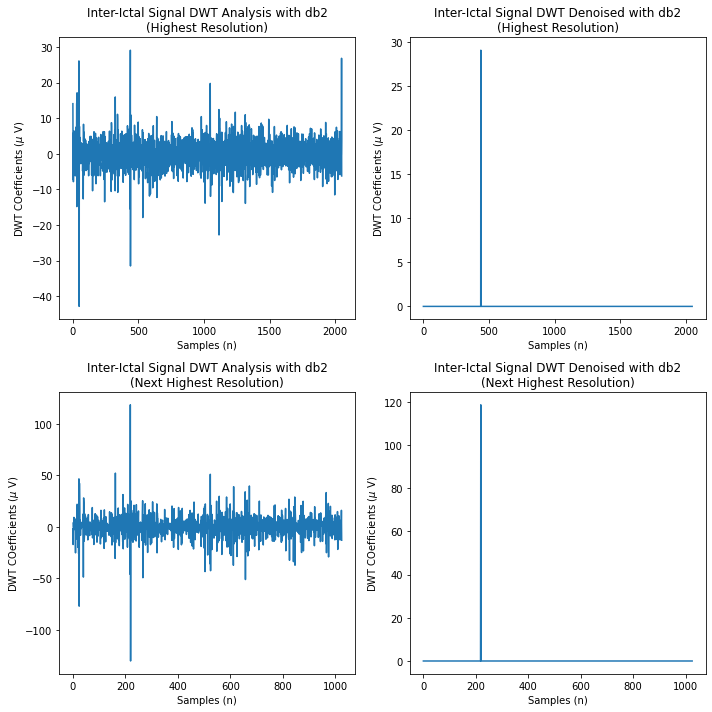

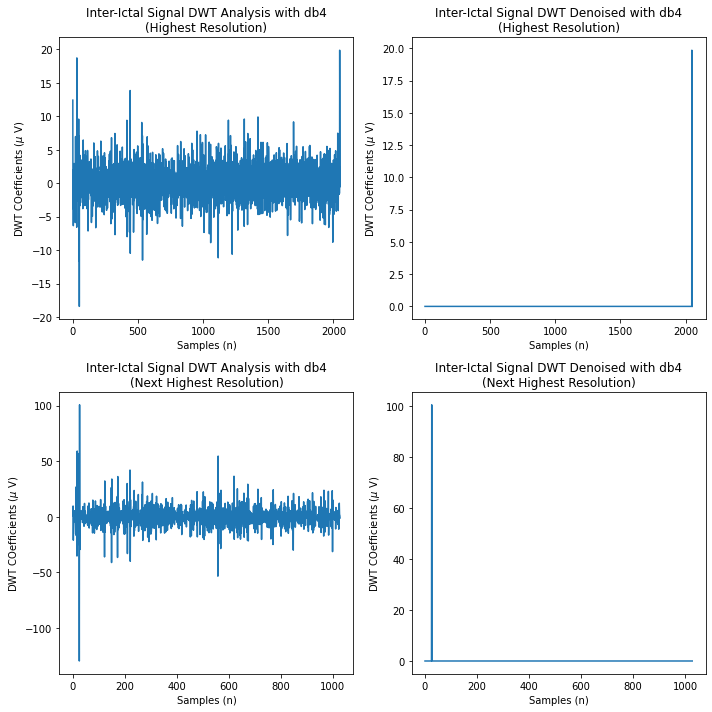

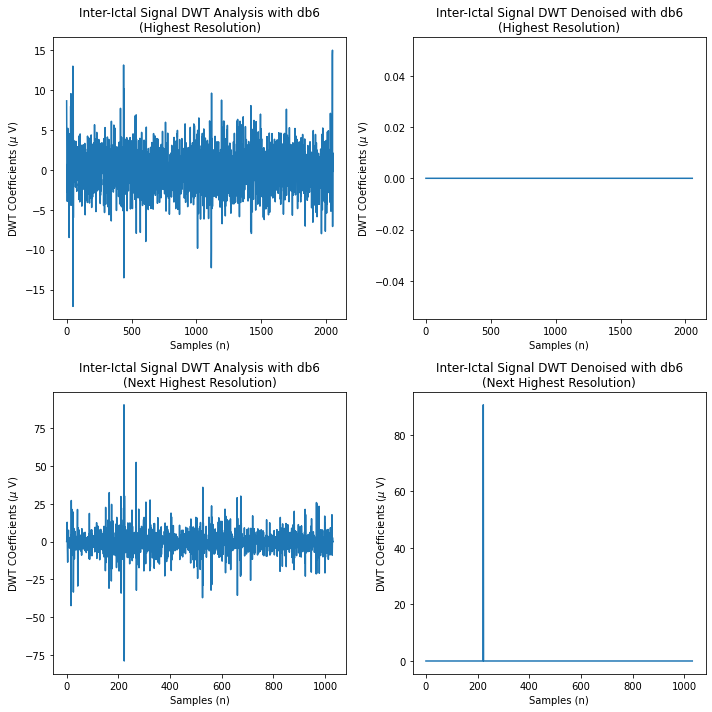

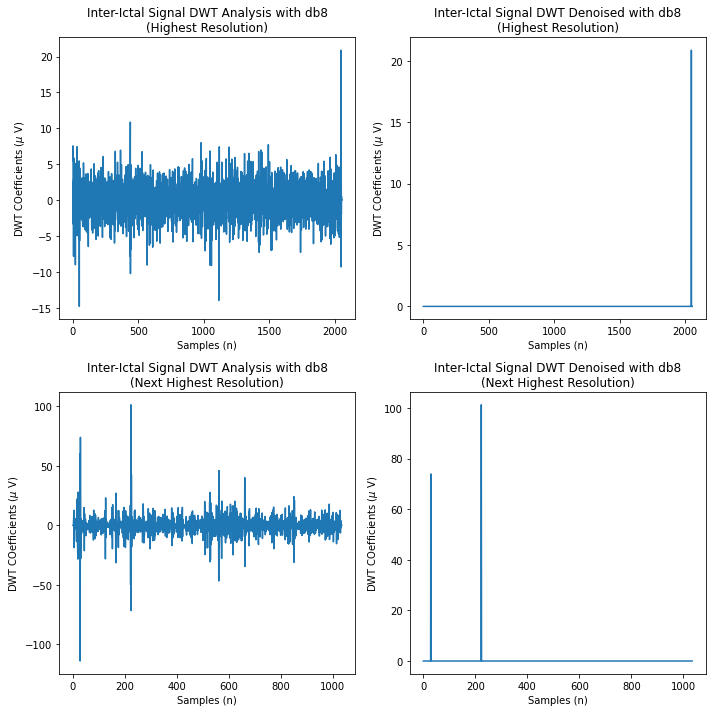

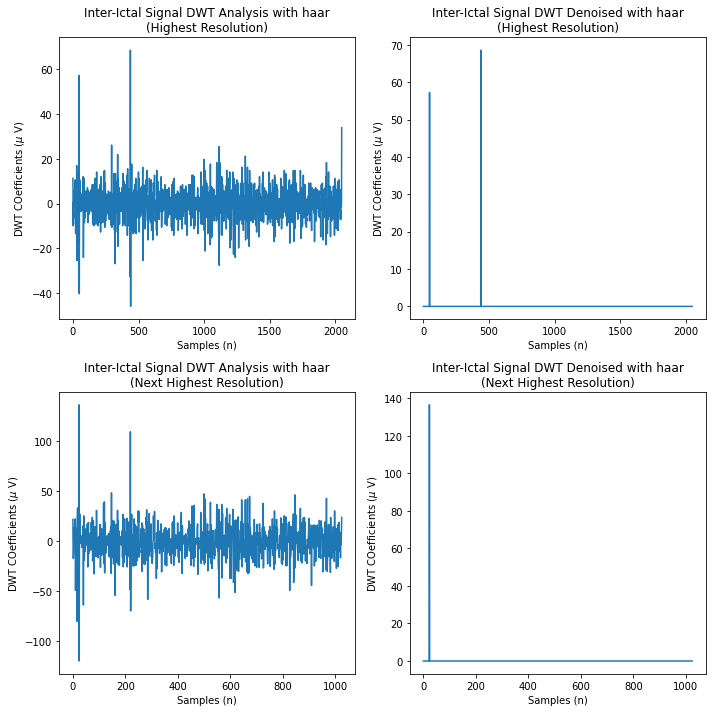

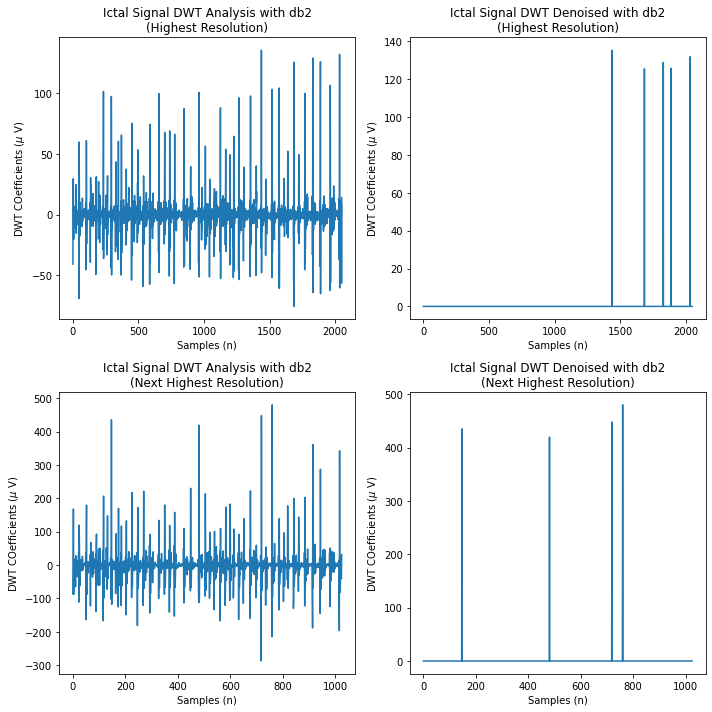

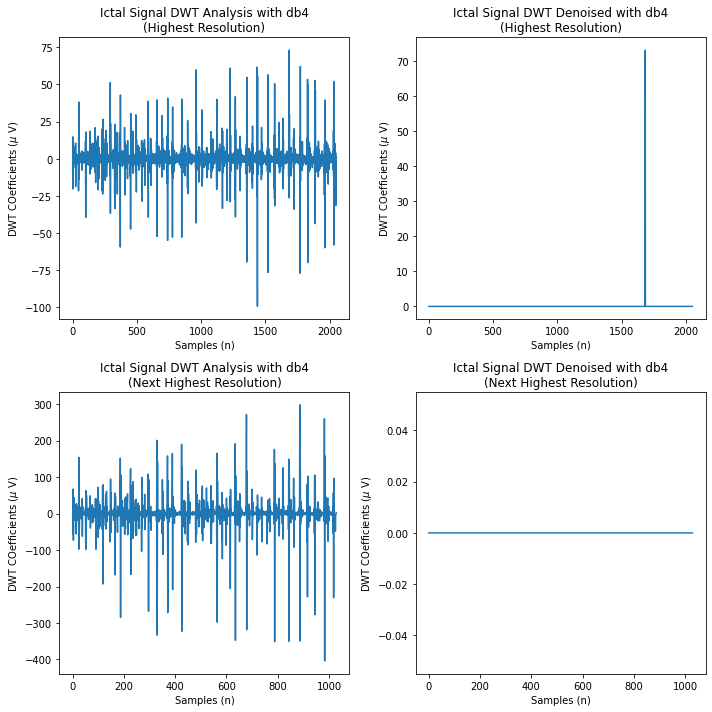

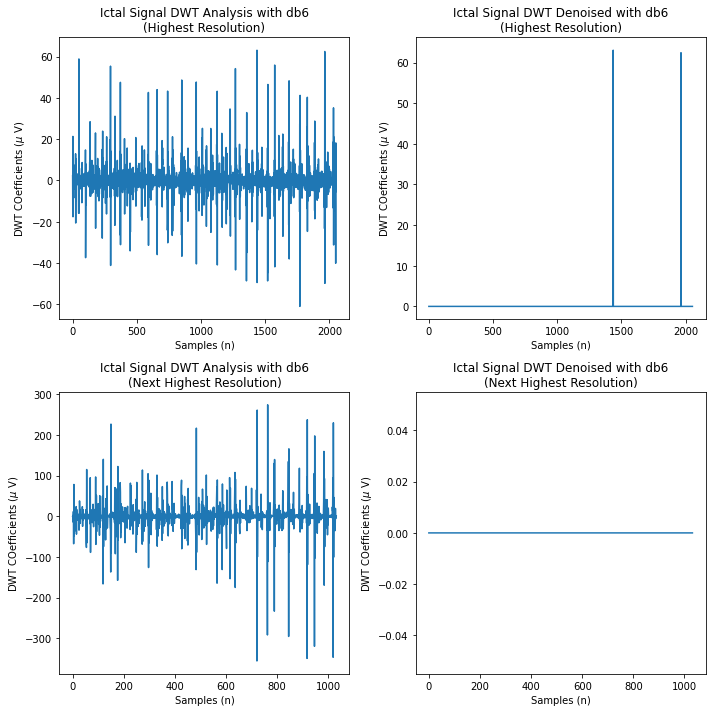

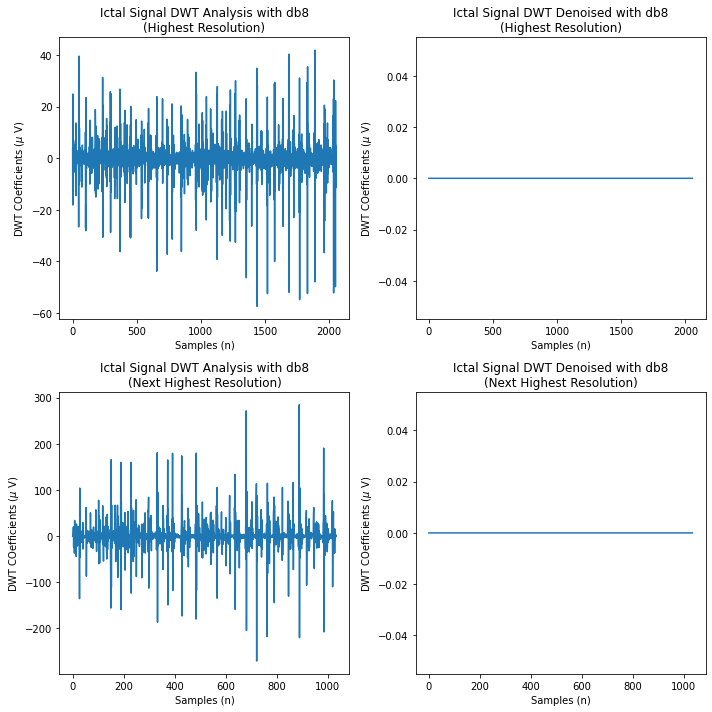

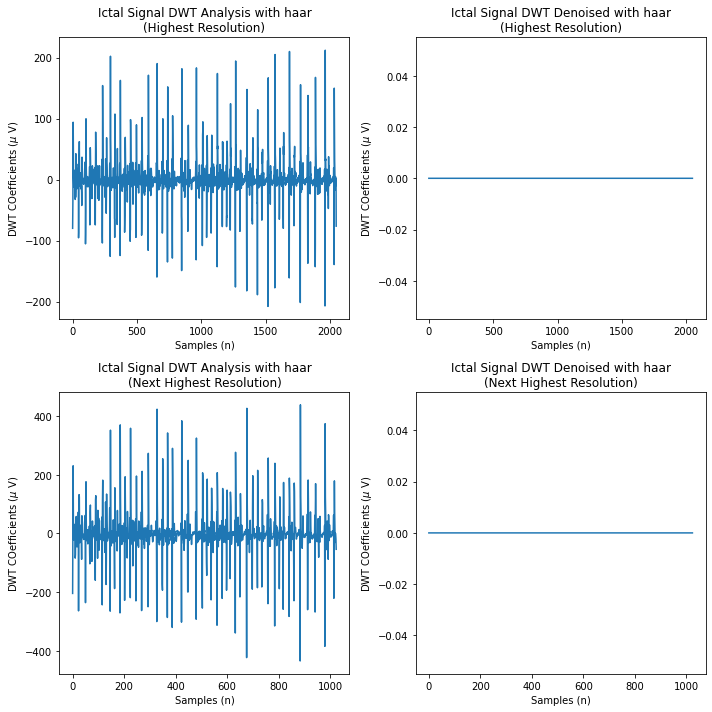

In [ ]:
dwt_synth_original_test = dwt_denoising_synthesis(Sub_Dir, test_dict, wavelets, sample_no = 10, level = 6)

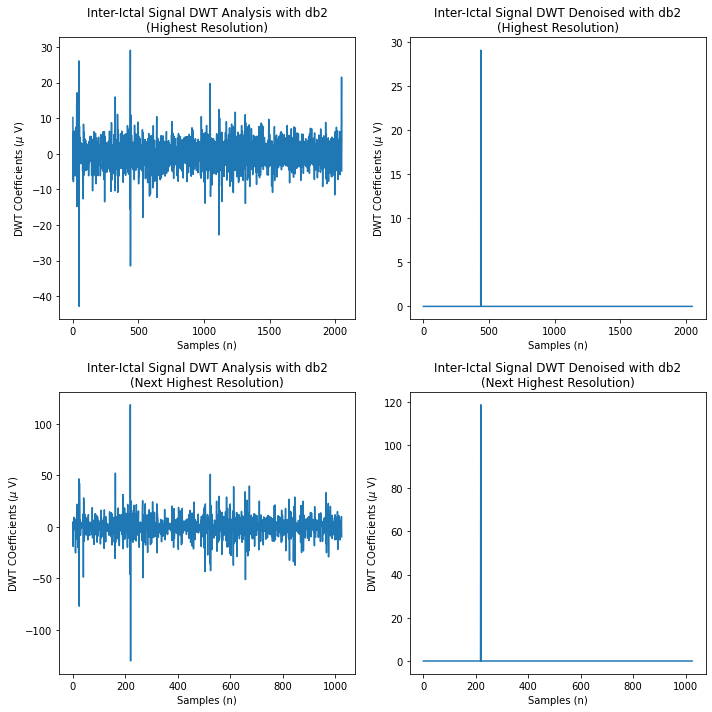

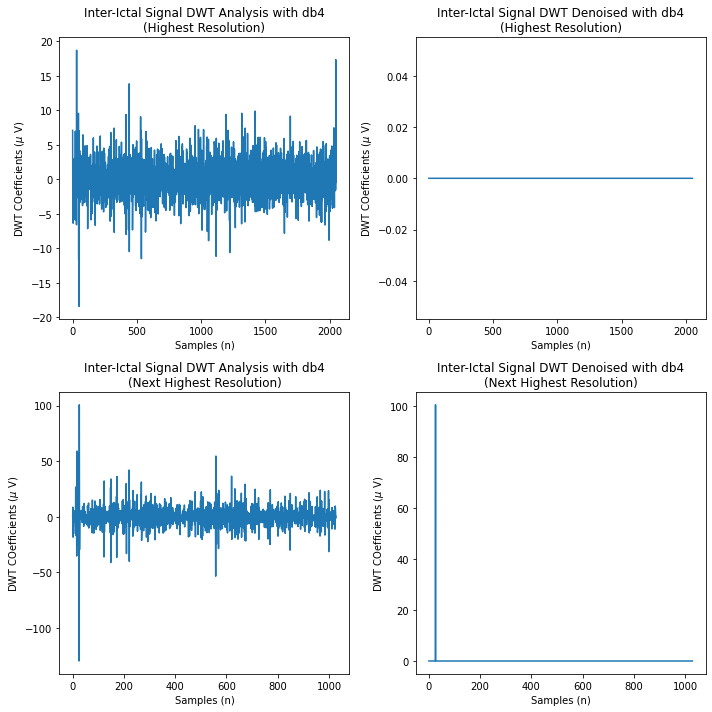

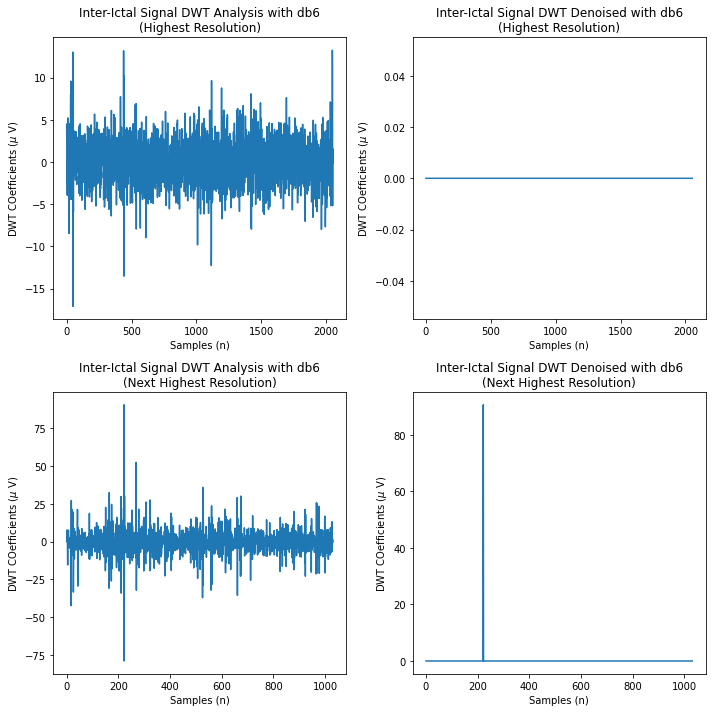

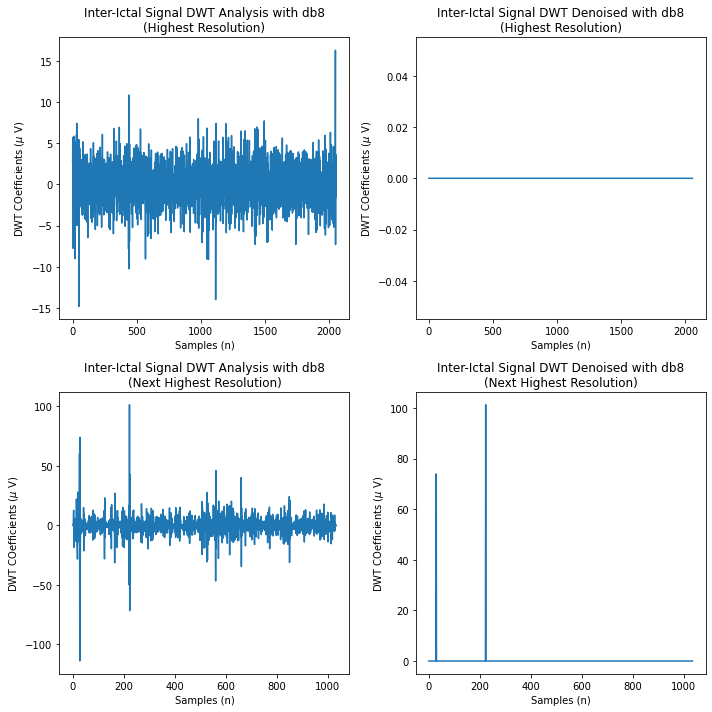

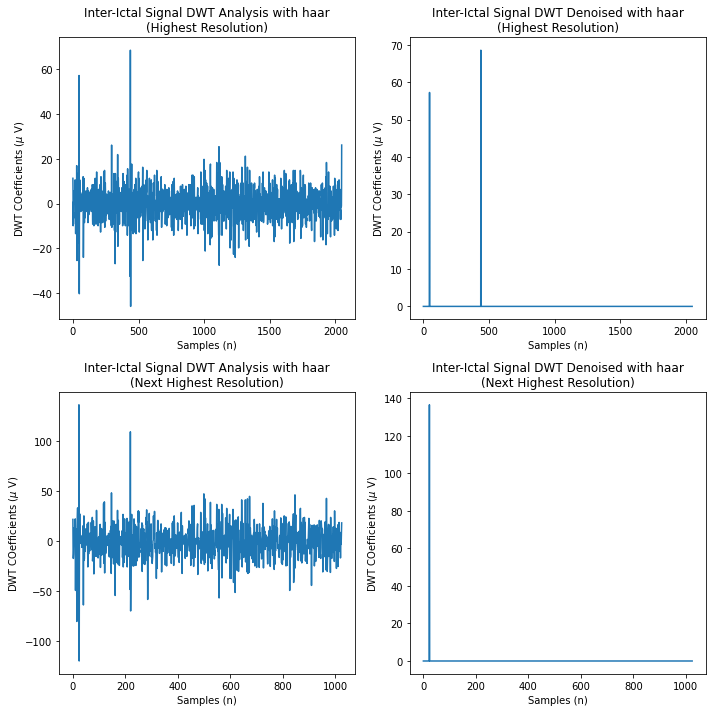

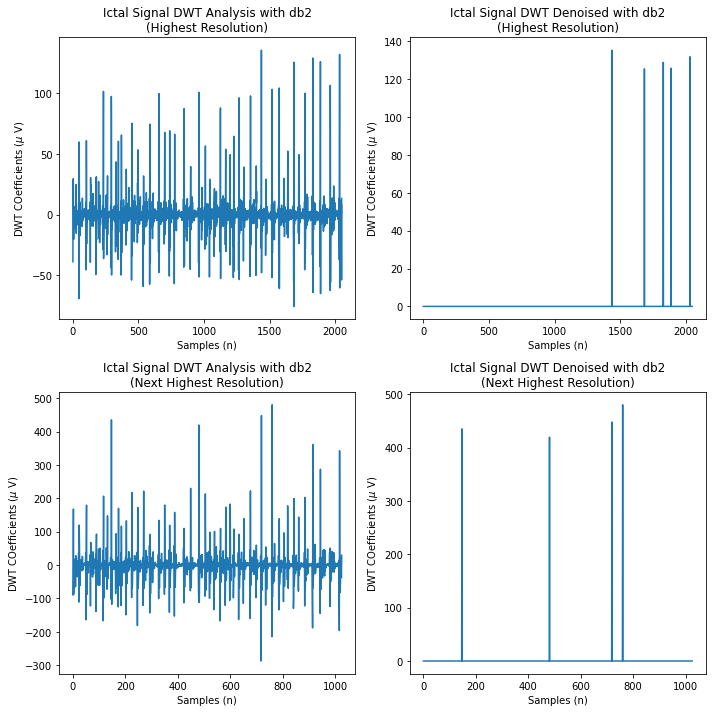

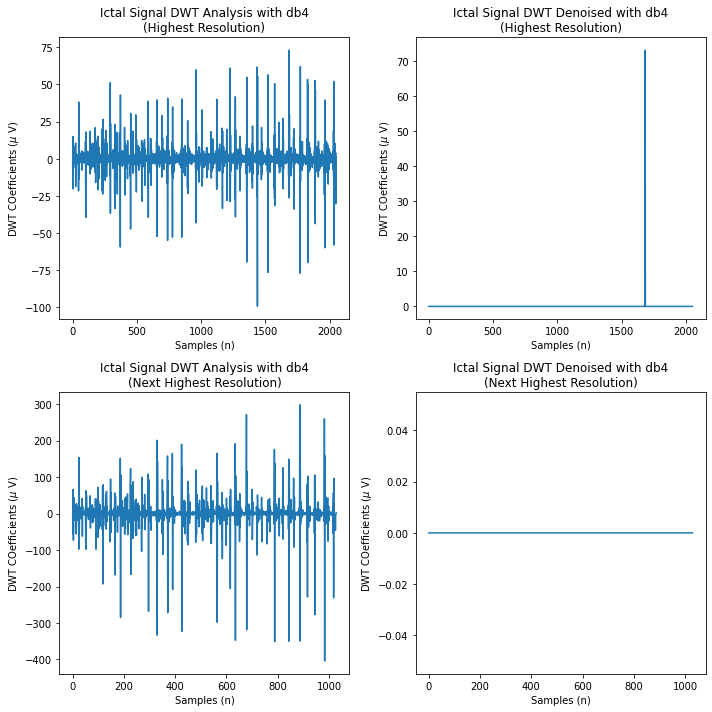

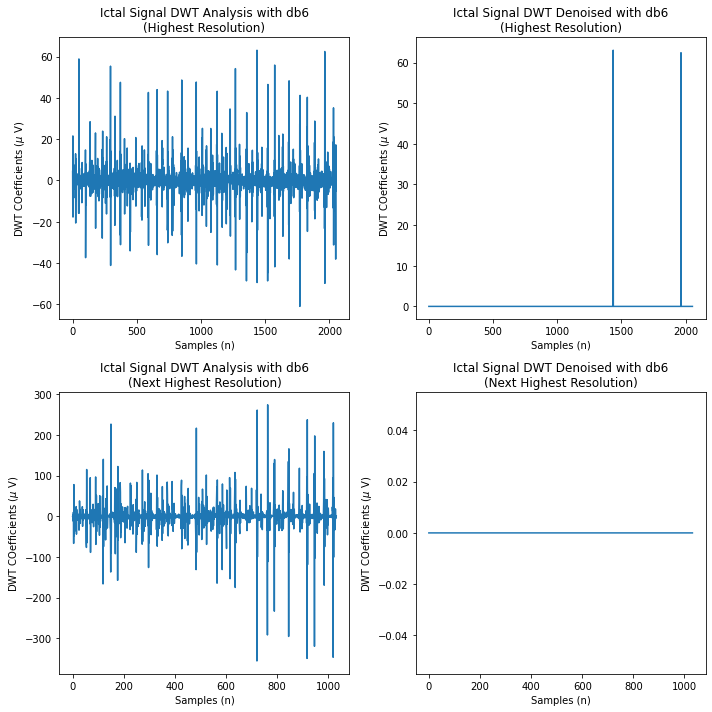

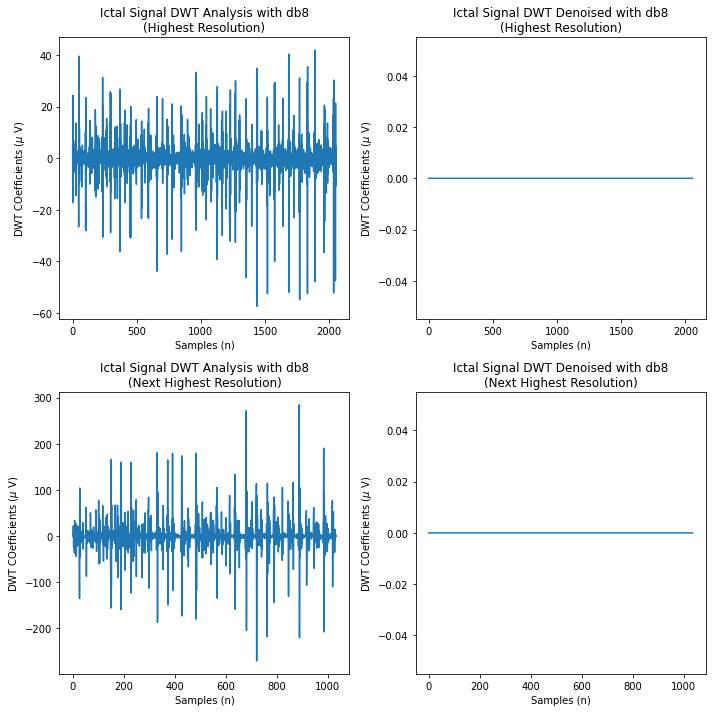

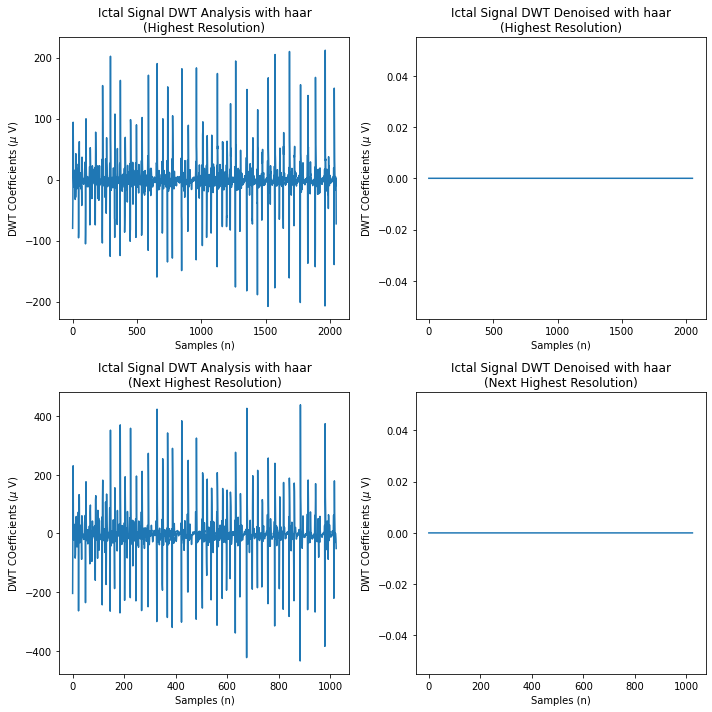

In [ ]:
dwt_synth_detrend_test = dwt_denoising_synthesis(Sub_Dir, detrend_test, wavelets, sample_no = 10, level = 6) 

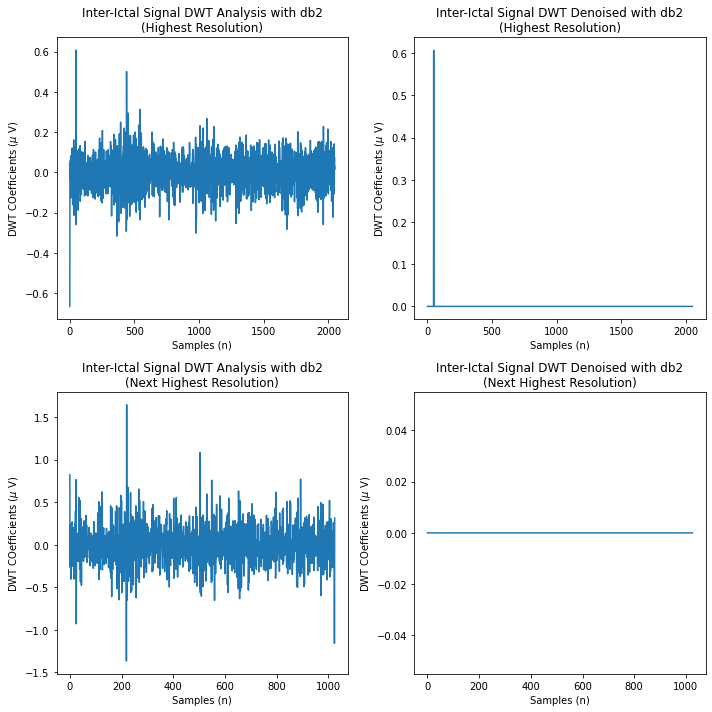

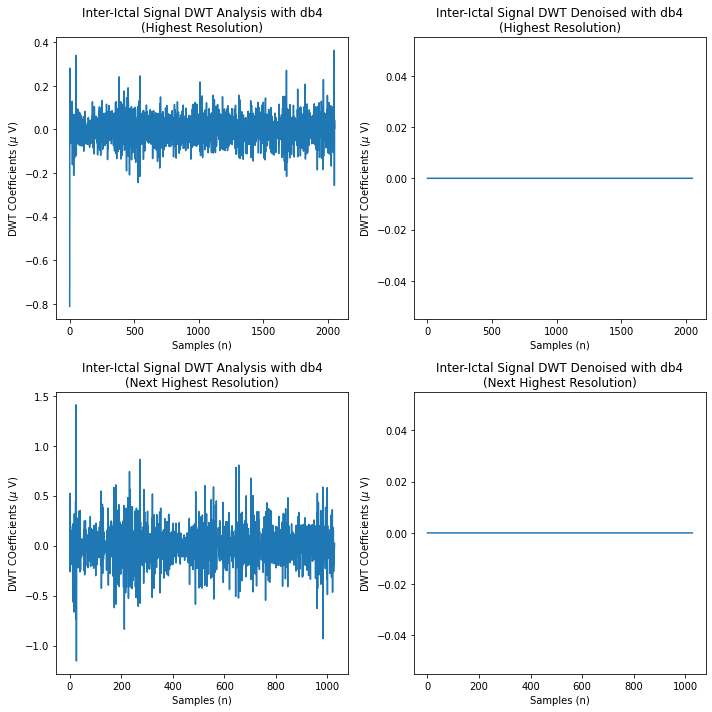

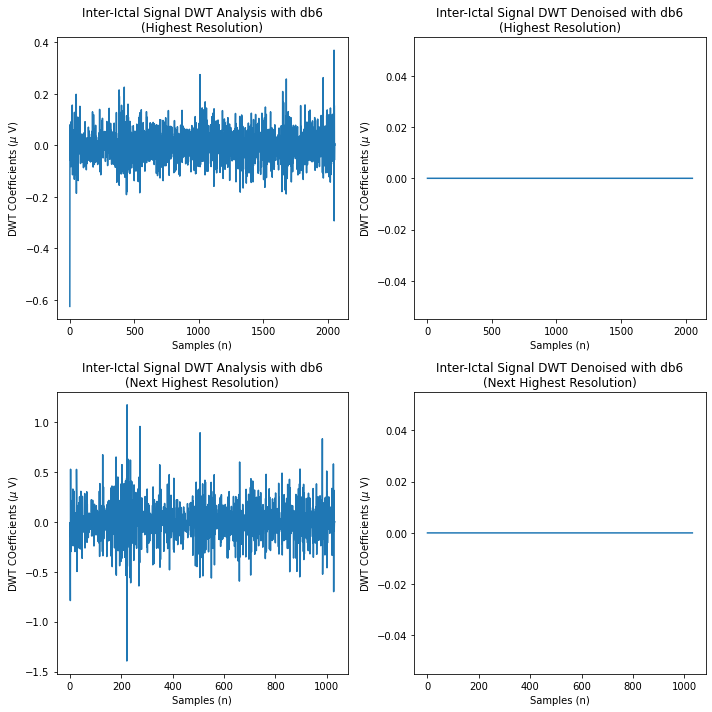

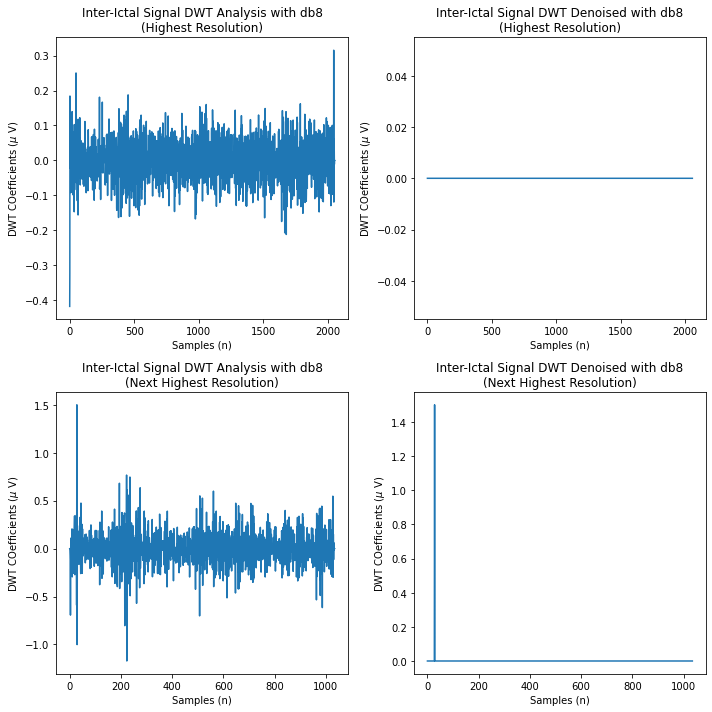

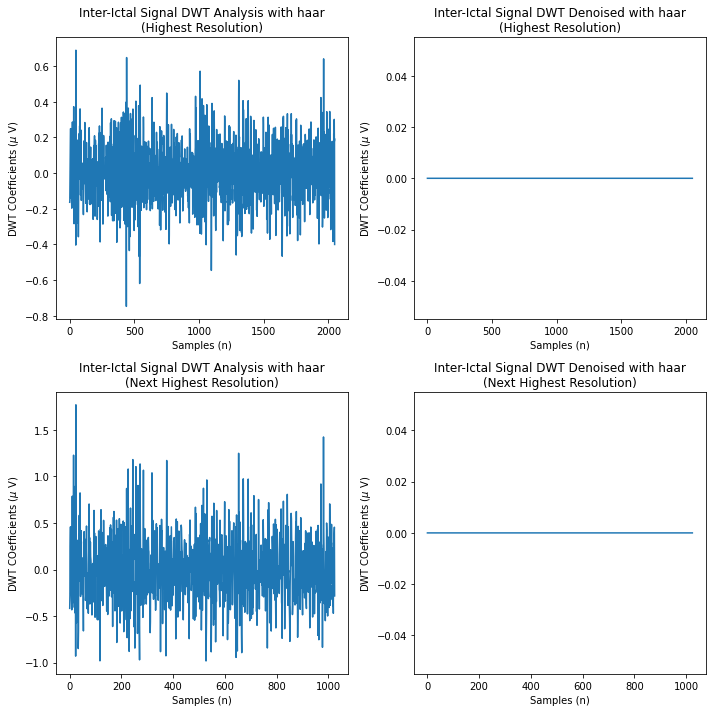

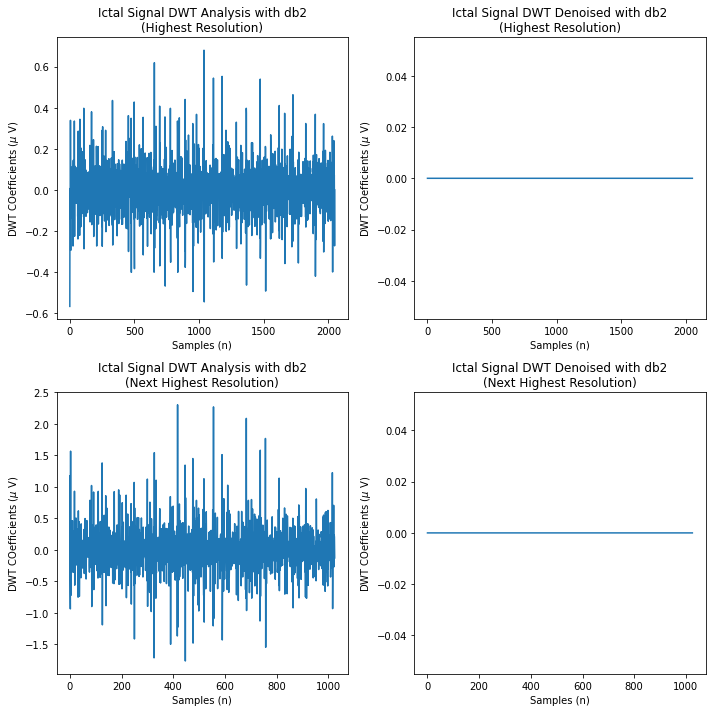

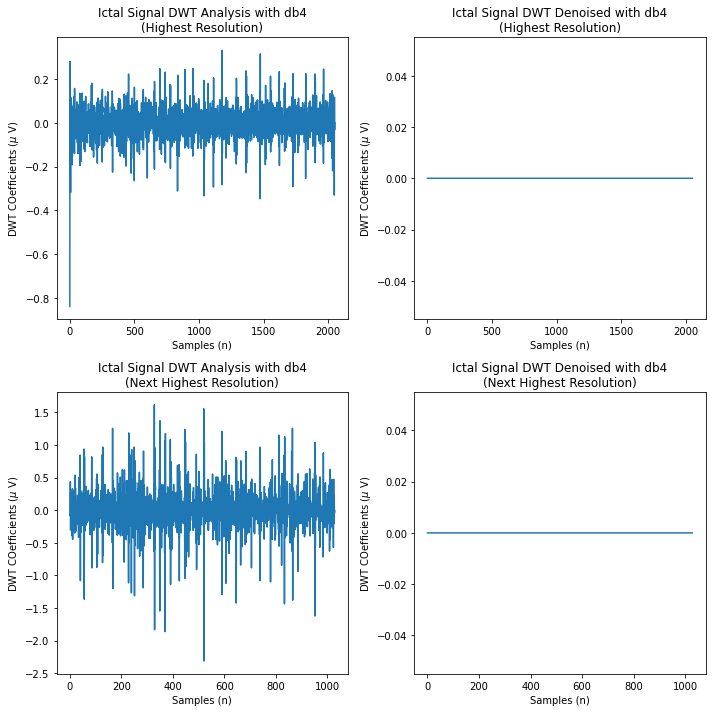

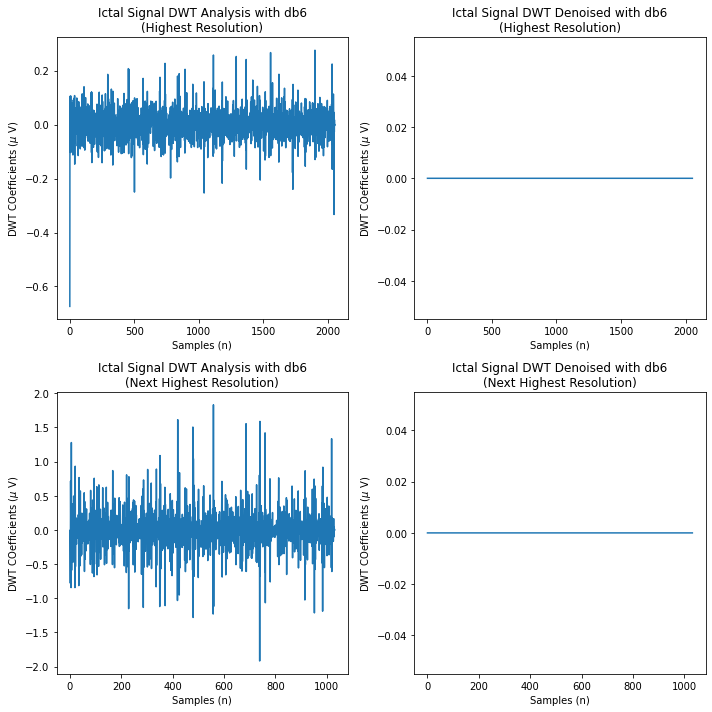

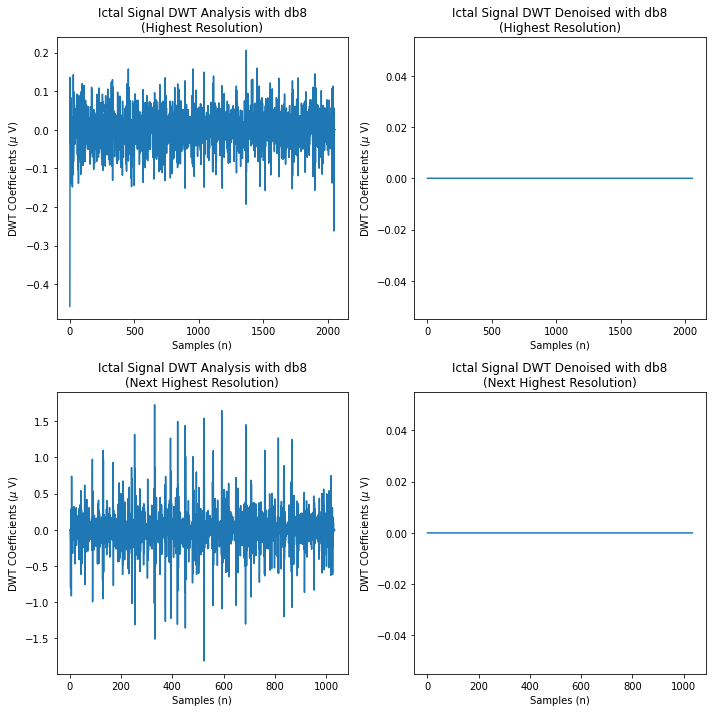

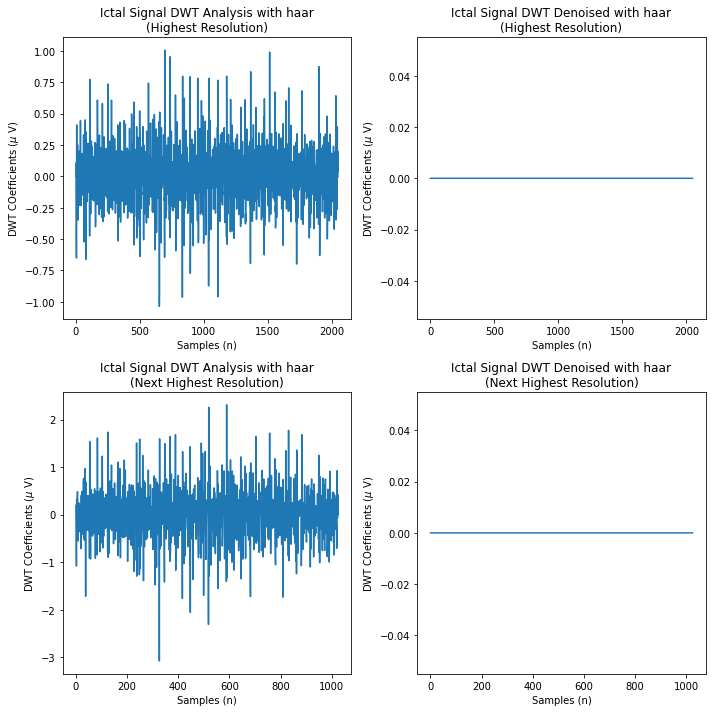

In [ ]:
dwt_synth_pca_test = dwt_denoising_synthesis(Sub_Dir, pca_test, wavelets, sample_no = 10, level = 6)

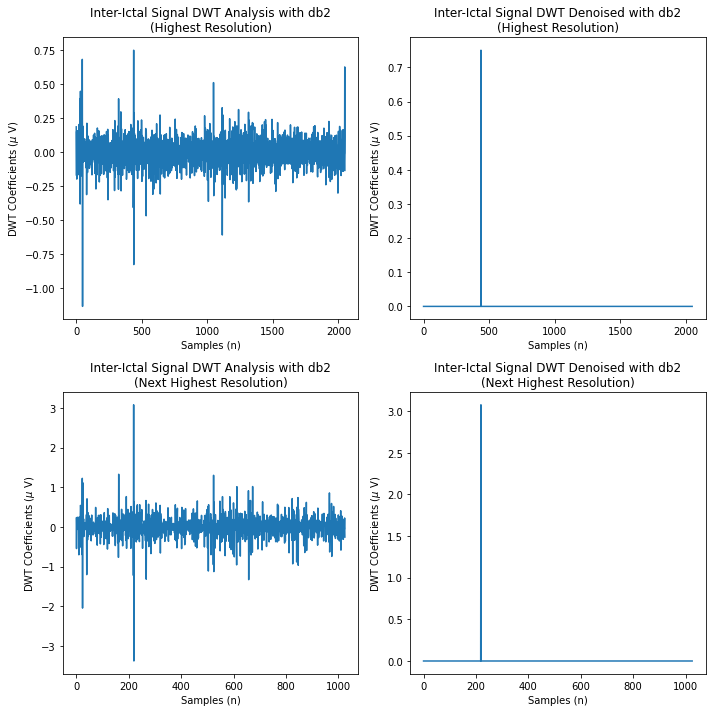

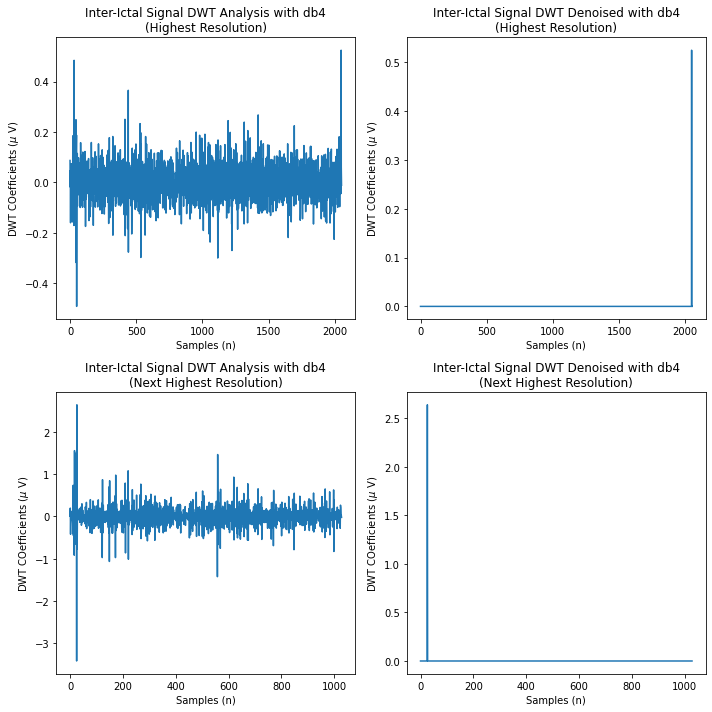

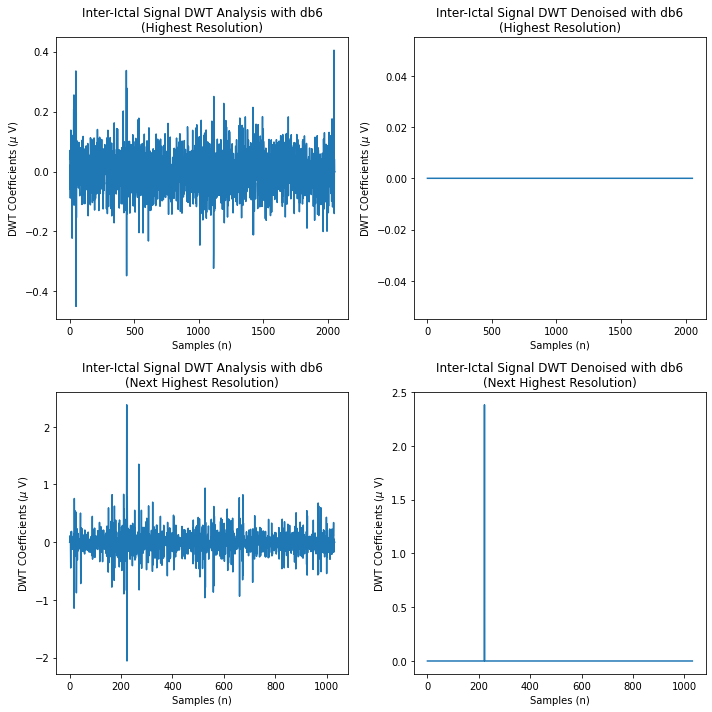

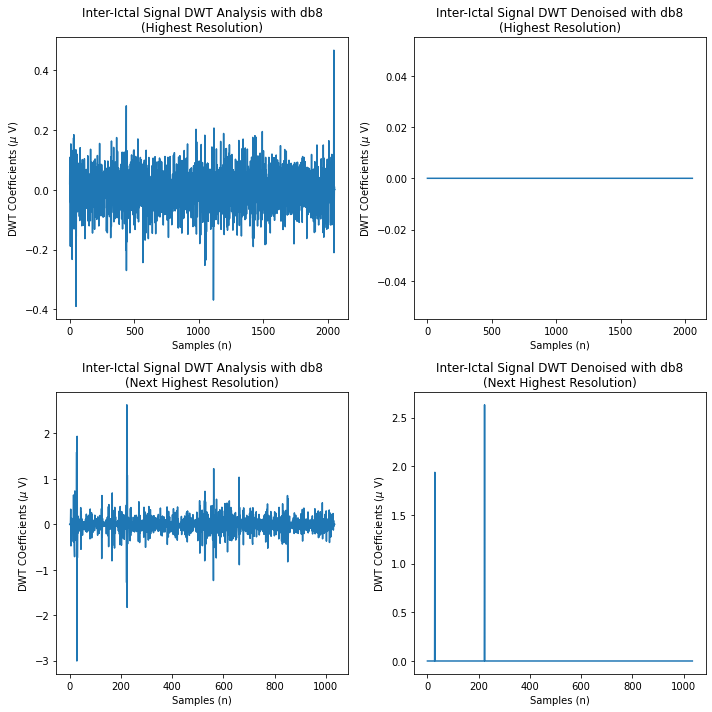

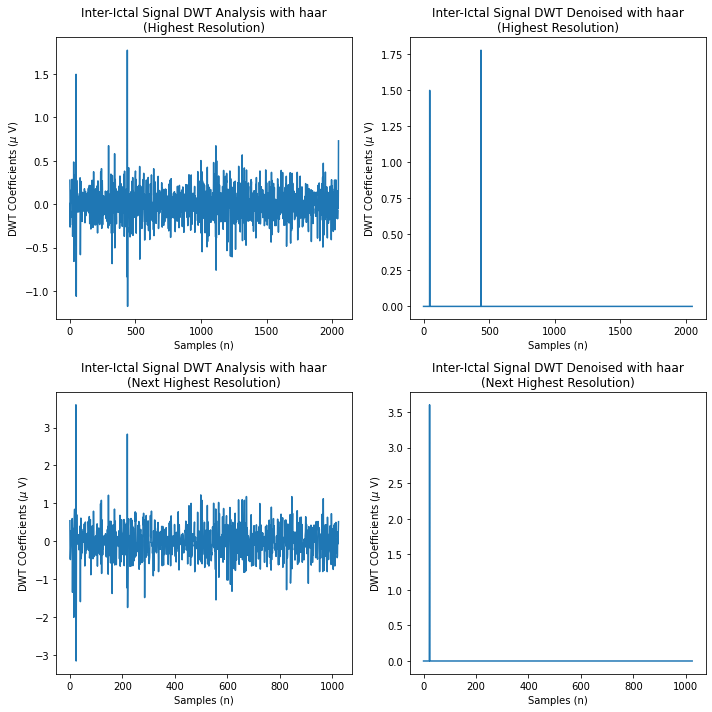

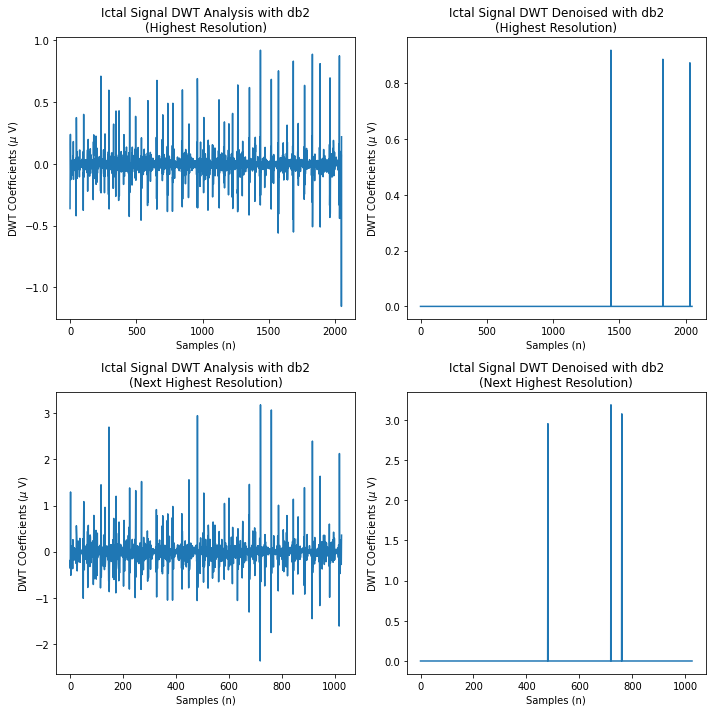

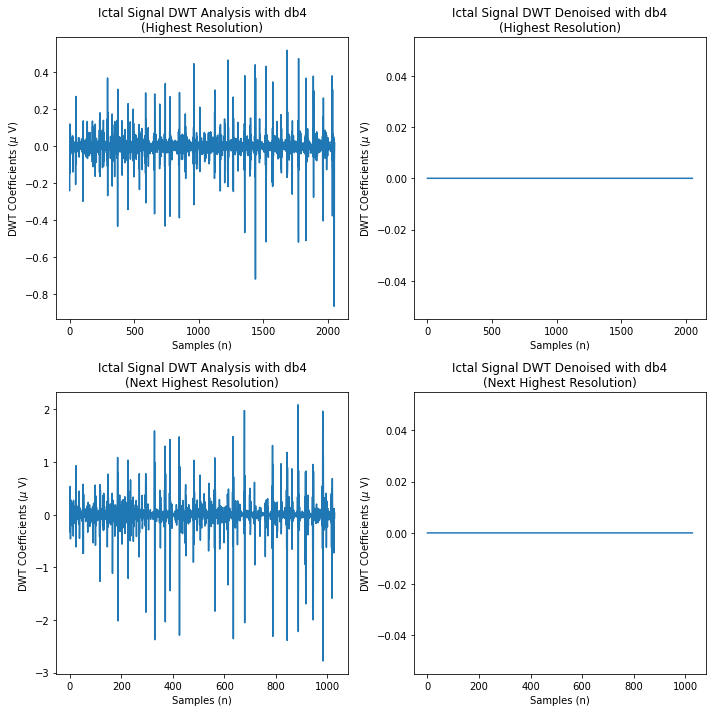

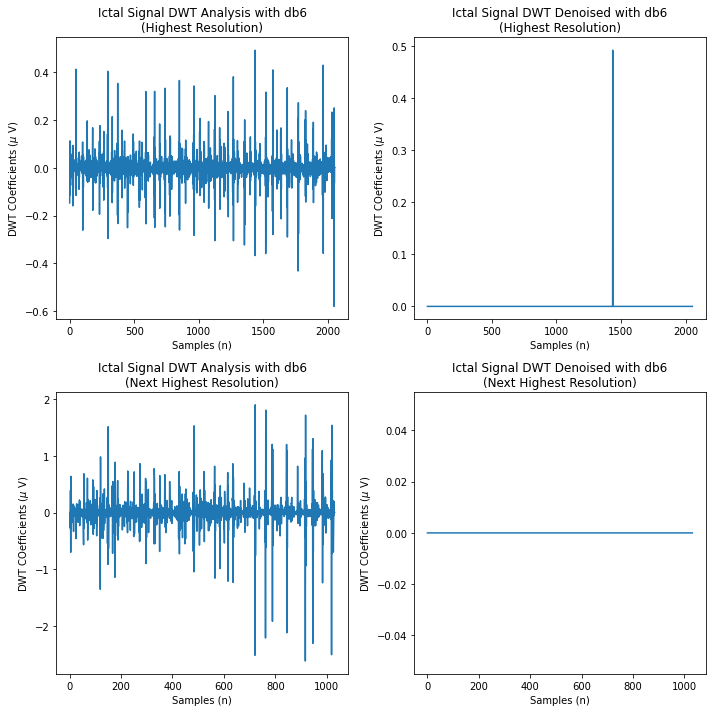

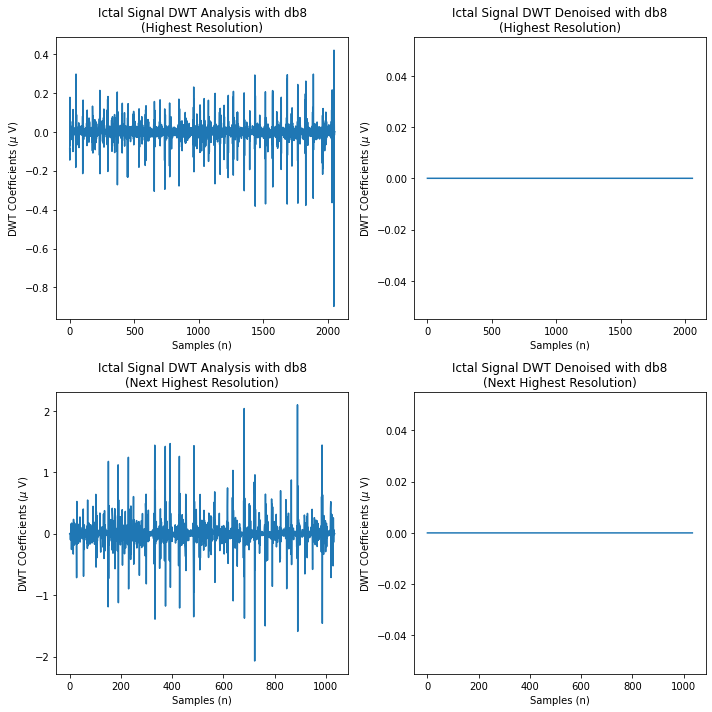

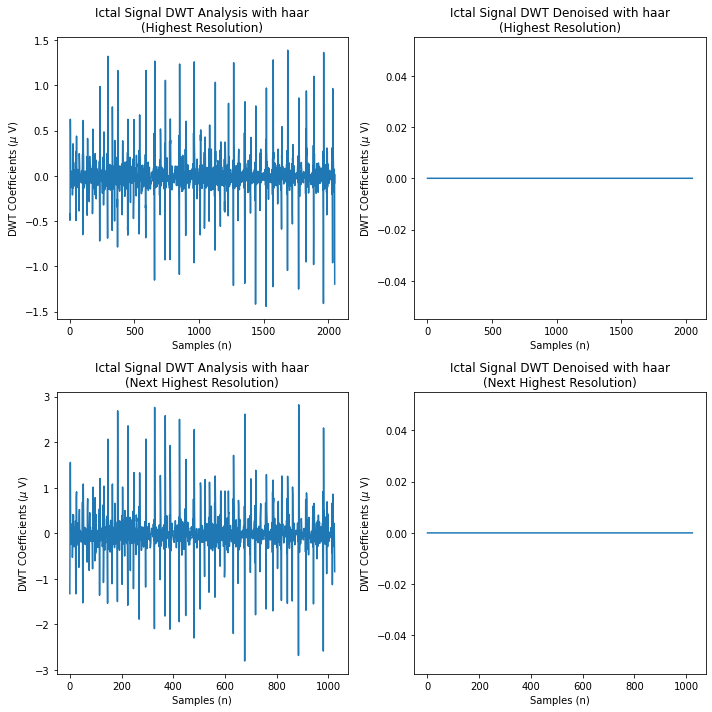

In [ ]:
dwt_synth_zca_test = dwt_denoising_synthesis(Sub_Dir, zca_test, wavelets, sample_no = 10, level = 6) 

In [ ]:
# dump_results(dwt_synth_original_train, 'dwt_synth_original_train', RESULTS_DIR, 'dwt_filtering')
# dump_results(dwt_synth_detrend_train, 'dwt_synth_detrend_train', RESULTS_DIR, 'dwt_filtering')
# dump_results(dwt_synth_pca_train, 'dwt_synth_pca_train', RESULTS_DIR, 'dwt_filtering')
# dump_results(dwt_synth_zca_train, 'dwt_synth_zca_train', RESULTS_DIR, 'dwt_filtering')

# dump_results(dwt_synth_original_test, 'dwt_synth_original_test', RESULTS_DIR, 'dwt_filtering')
# dump_results(dwt_synth_detrend_test, 'dwt_synth_detrend_test', RESULTS_DIR, 'dwt_filtering')
# dump_results(dwt_synth_pca_test, 'dwt_synth_pca_test', RESULTS_DIR, 'dwt_filtering')
# dump_results(dwt_synth_zca_test, 'dwt_synth_zca_test', RESULTS_DIR, 'dwt_filtering')

In [ ]:
dwt_synth_zca_train['S']['db4'].shape

(80, 4097)

In [ ]:
t_vect = np.arange(0, nSamples) / sampling_freq
f_vect = np.fft.fftshift(np.fft.fftfreq(nSamples)) * sampling_freq

def plot_filteeg_samples(dataset, wavelet, sample_no, nSamples, dataset_name = 'Train'):
  figure(figsize=(20, 10))
  subplot(2, 2, 1) 
  plot(t_vect, dataset['S'][wavelet][sample_no])
  xlabel('Time (s)'); ylabel(r'Sigal Value ($\mu$ V)')
  title(f'Ictal Signal Sample - {dataset_name} Set - Wavelet = {wavelet}')

  subplot(2, 2, 2) 
  plot(f_vect, np.abs(np.fft.fftshift(np.fft.fft(dataset['S'][wavelet][sample_no])) / nSamples))
  xlabel('Freq (Hz)'); ylabel('Magnitude')
  title(f'Ictal Signal Sample - {dataset_name} Set - Wavelet = {wavelet}')

  subplot(2, 2, 3) 
  plot(t_vect, dataset['F'][wavelet][sample_no])
  xlabel('Time (s)'); ylabel(r'Sigal Value ($\mu$ V)')
  title(f'Inter-Ictal Signal Sample - {dataset_name} Set - Wavelet = {wavelet}')

  subplot(2, 2, 4) 
  plot(f_vect, np.abs(np.fft.fftshift(np.fft.fft(dataset['F'][wavelet][sample_no])) / nSamples))
  xlabel('Freq (Hz)'); ylabel('Magnitude')
  title(f'Inter-Ictal Signal Sample - {dataset_name} Set - Wavelet = {wavelet}')
  plt.tight_layout()
  return

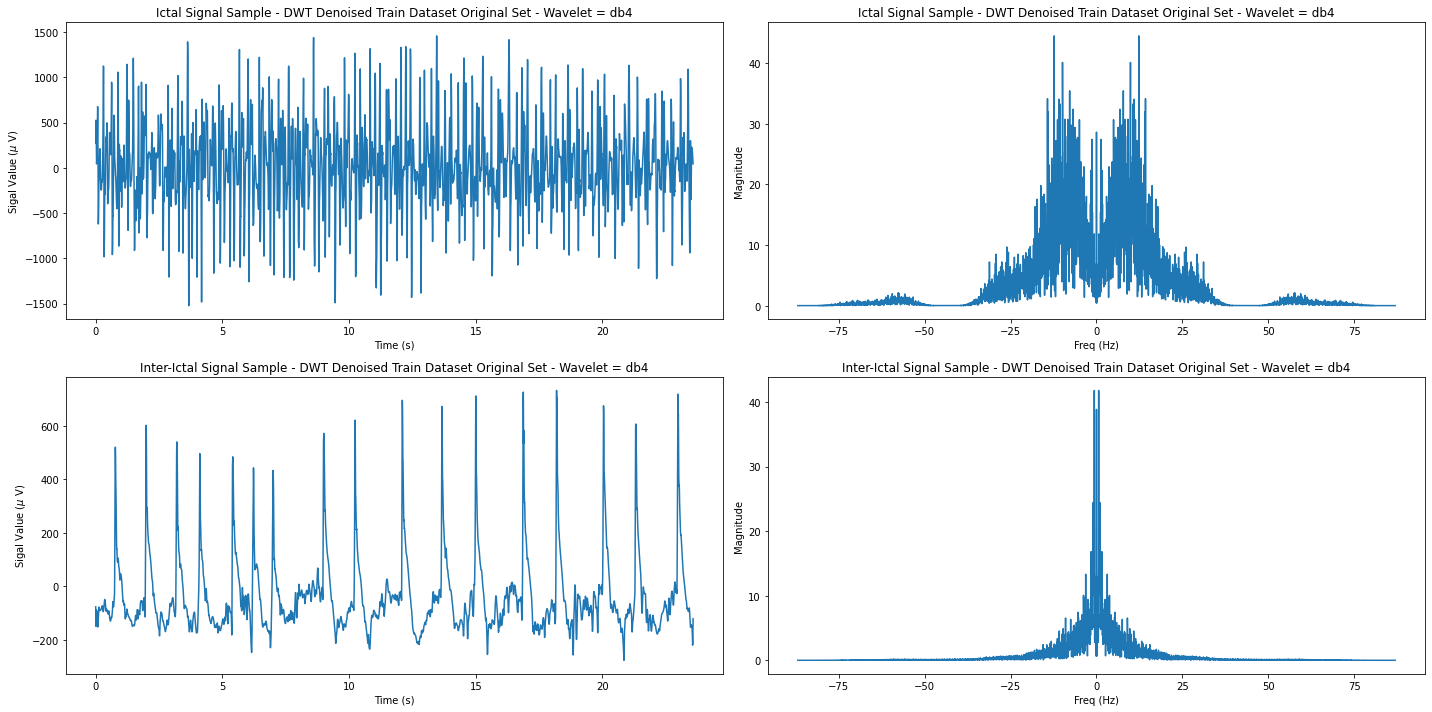

In [ ]:
plot_filteeg_samples(dwt_synth_original_train, 'db4', 20, nSamples, dataset_name = 'DWT Denoised Train Dataset Original')

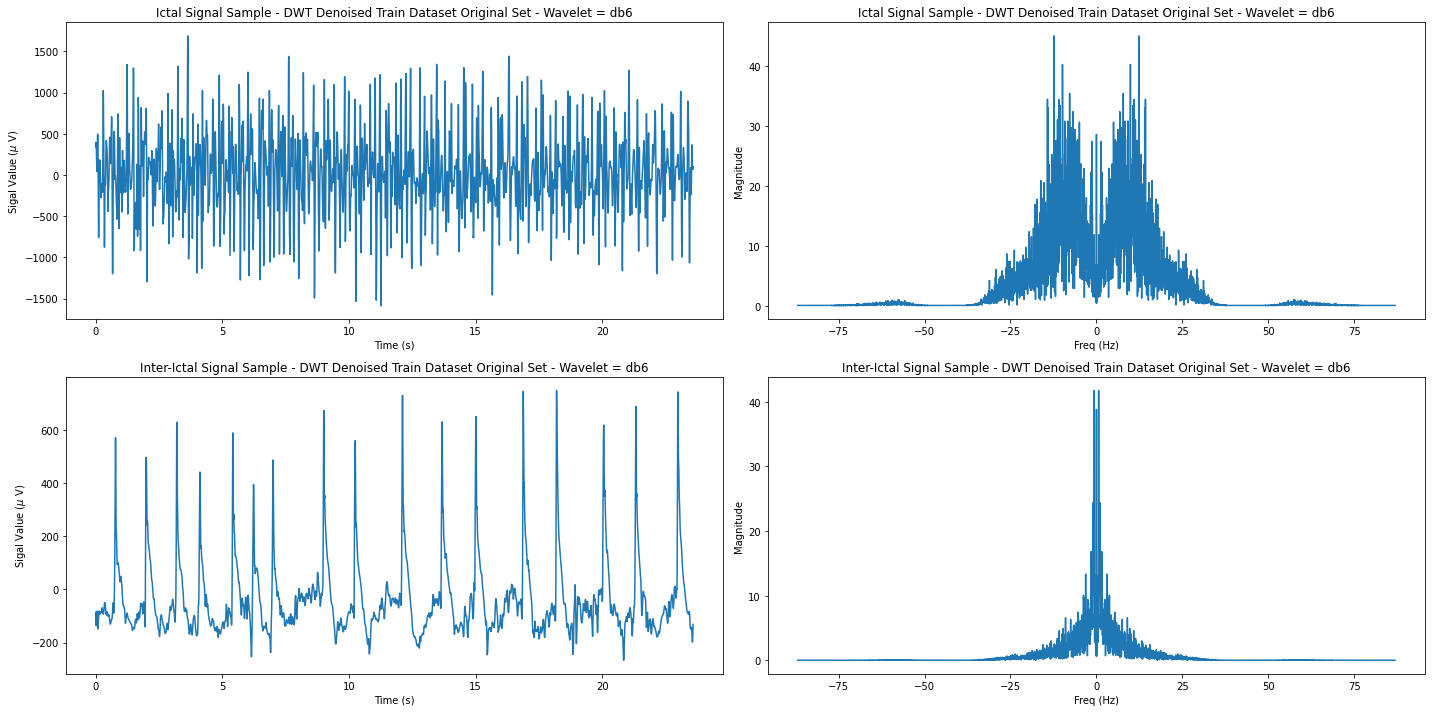

In [ ]:
plot_filteeg_samples(dwt_synth_original_train, 'db6', 20, nSamples, dataset_name = 'DWT Denoised Train Dataset Original')

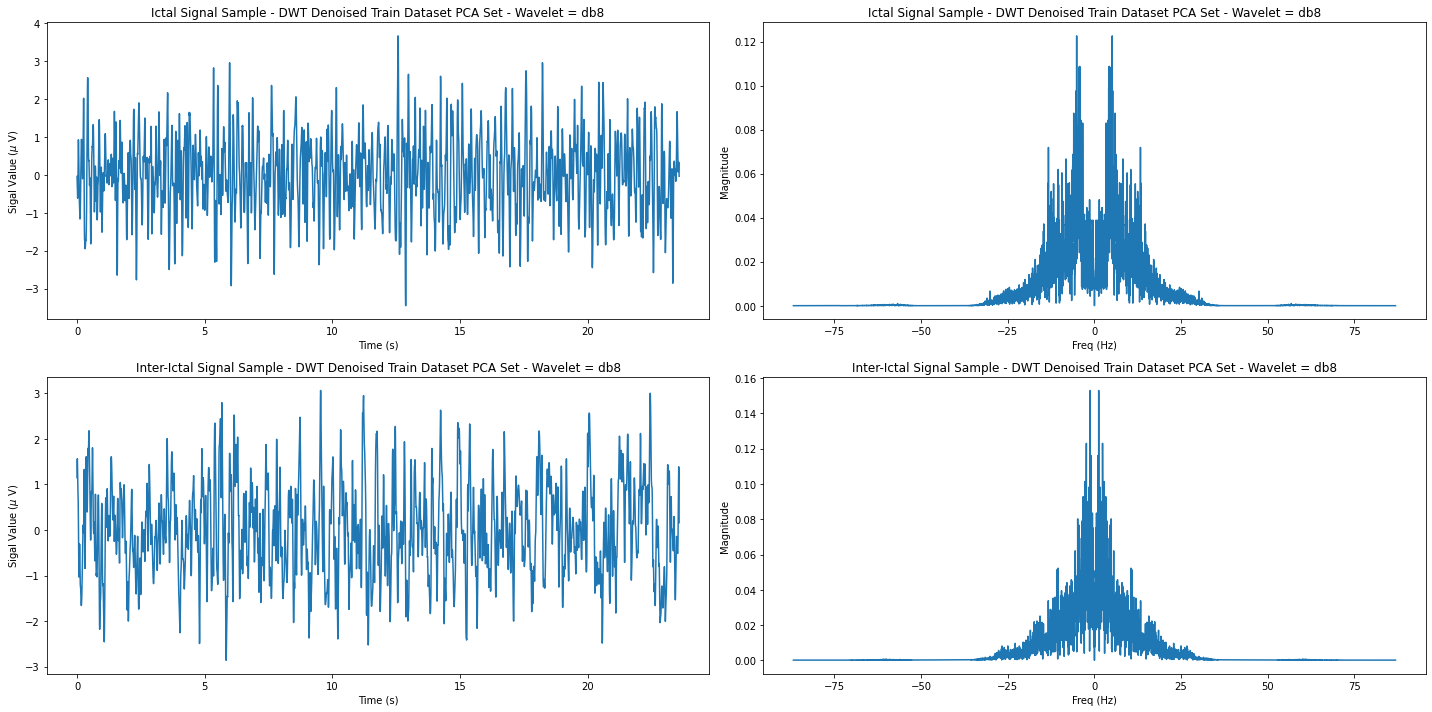

In [ ]:
plot_filteeg_samples(dwt_synth_pca_train, 'db8', 20, nSamples, dataset_name = 'DWT Denoised Train Dataset PCA')

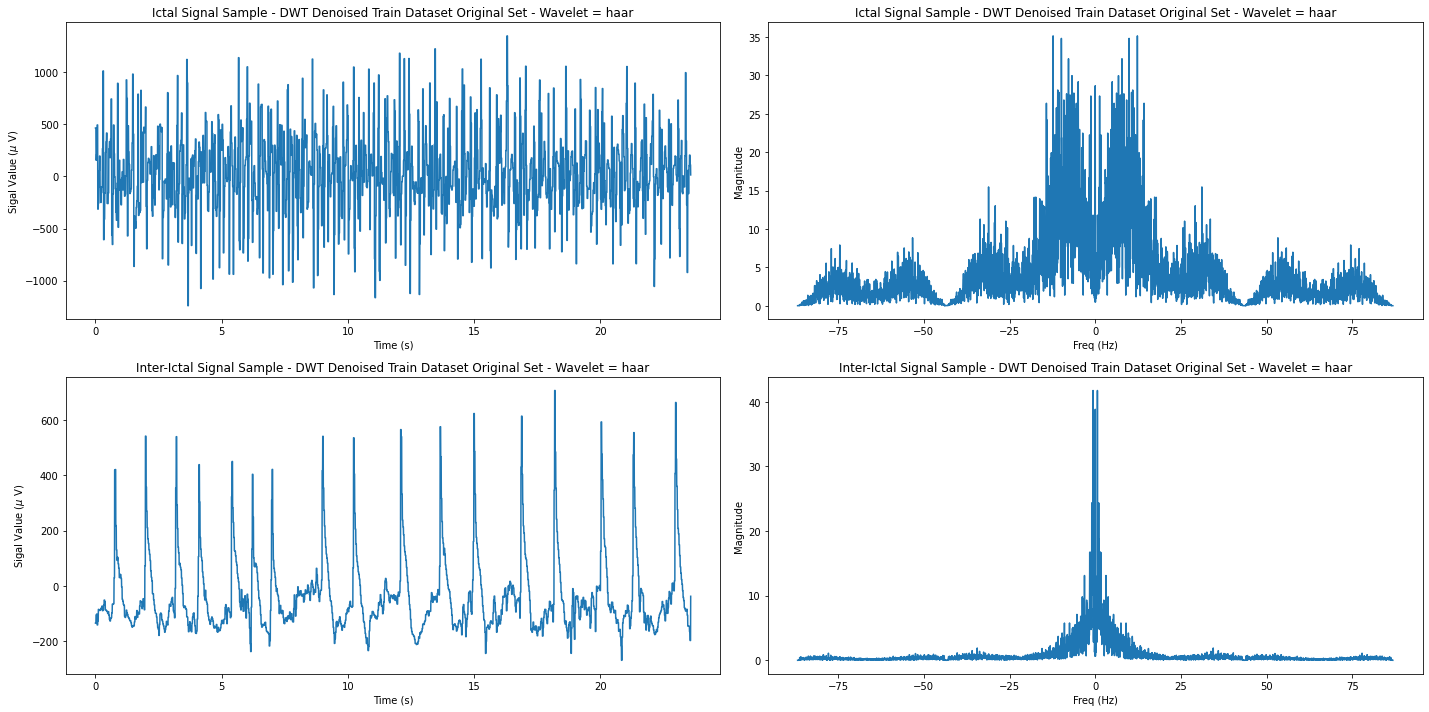

In [ ]:
plot_filteeg_samples(dwt_synth_original_train, 'haar', 20, nSamples, dataset_name = 'DWT Denoised Train Dataset Original')

In [ ]:
def eval_dict_dwt_create(orig_filt, filt_dict, Sub_Dir, wavelets, nSamples, f_vect):
  results_dict = {}
  for i, data_dir in enumerate(Sub_Dir):
    results_dict[data_dir] = {}

    for wavelet in wavelets:
      results_dict[data_dir][wavelet] = {}

      filt_signal_set = filt_dict[data_dir][wavelet]
      sig_dist, noise_red = eval_filtering(orig_filt[data_dir], filt_signal_set, nSamples, f_vect, cutoff = 40)

      results_dict[data_dir][wavelet]['SD'] = sig_dist
      results_dict[data_dir][wavelet]['NR'] = noise_red
  return results_dict

In [ ]:
dwt_filt_original_train_eval = eval_dict_dwt_create(train_dict, dwt_synth_original_train, Sub_Dir, wavelets, nSamples, f_vect)
dwt_filt_detrend_train_eval = eval_dict_dwt_create(detrend_train, dwt_synth_detrend_train, Sub_Dir, wavelets, nSamples, f_vect)
dwt_filt_pca_train_eval = eval_dict_dwt_create(pca_train, dwt_synth_pca_train, Sub_Dir, wavelets, nSamples, f_vect)
dwt_filt_zca_train_eval = eval_dict_dwt_create(zca_train, dwt_synth_zca_train, Sub_Dir, wavelets, nSamples, f_vect)

In [ ]:
dwt_filt_original_test_eval = eval_dict_dwt_create(test_dict, dwt_synth_original_train, Sub_Dir, wavelets, nSamples, f_vect)
dwt_filt_detrend_test_eval = eval_dict_dwt_create(detrend_test, dwt_synth_detrend_train, Sub_Dir, wavelets, nSamples, f_vect)
dwt_filt_pca_test_eval = eval_dict_dwt_create(pca_test, dwt_synth_pca_train, Sub_Dir, wavelets, nSamples, f_vect)
dwt_filt_zca_test_eval = eval_dict_dwt_create(zca_test, dwt_synth_zca_train, Sub_Dir, wavelets, nSamples, f_vect)

In [ ]:
def graph_dwt(eval_dict, dataset, wavelets):
  eval_s = []
  eval_n = []

  for wavelet in wavelets:
    values = eval_dict[dataset][wavelet]
    eval_s.append(values['SD'])
    eval_n.append(values['NR'])
  
  fig = plt.figure(figsize = (5, 5))
  ax = fig.add_subplot(111)

  ax.scatter(eval_n, eval_s)
  ax.set_ylabel('Signal Distortion')
  ax.set_xlabel('Noise Reduction')
  if dataset == 'S':
    ax.set_title(f'DWT Wavelets Evaluation for Ictal dataset')
  else:
    ax.set_title(f'DWT Wavelets Evaluation for Inter-Ictal dataset')
    
  for n, x, y in zip(wavelets, eval_n, eval_s):                                       
      ax.annotate('%s' % n, xy=(x+0.5, y), textcoords = 'data')
  ax.grid()
  plt.show()
  return

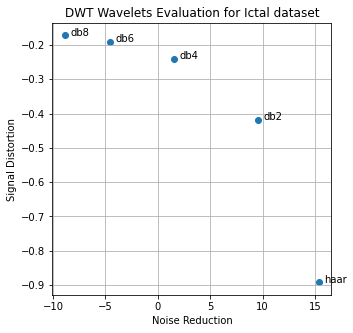

In [ ]:
graph_dwt(dwt_filt_original_train_eval, 'S', wavelets)

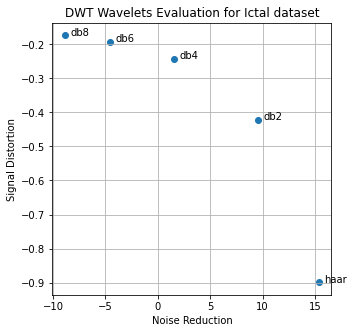

In [ ]:
graph_dwt(dwt_filt_detrend_train_eval, 'S', wavelets)

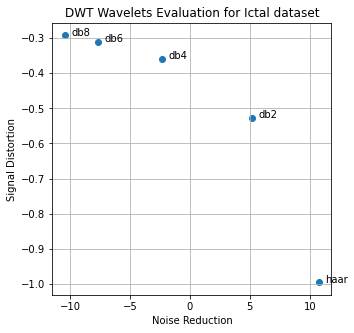

In [ ]:
graph_dwt(dwt_filt_pca_train_eval, 'S', wavelets)

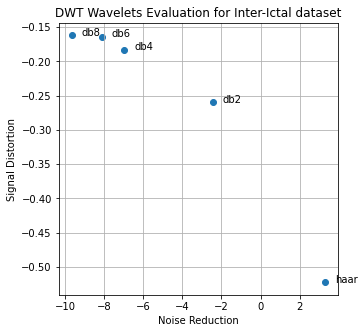

In [ ]:
graph_dwt(dwt_filt_pca_train_eval, 'F', wavelets)

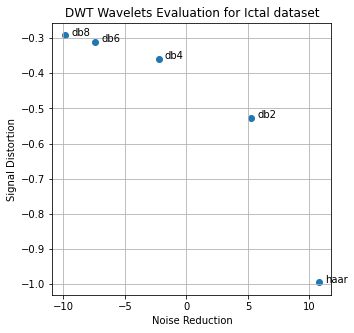

In [ ]:
graph_dwt(dwt_filt_zca_train_eval, 'S', wavelets)

In [ ]:
dump_results(dwt_filt_original_train_eval, 'dwt_filt_original_train_eval', RESULTS_DIR, 'dwt_filtering')
dump_results(dwt_filt_detrend_train_eval, 'dwt_filt_detrend_train_eval', RESULTS_DIR, 'dwt_filtering')
dump_results(dwt_filt_pca_train_eval, 'dwt_filt_pca_train_eval', RESULTS_DIR, 'dwt_filtering')
dump_results(dwt_filt_zca_train_eval, 'dwt_filt_zca_train_eval', RESULTS_DIR, 'dwt_filtering')

dump_results(dwt_filt_original_test_eval, 'dwt_filt_original_test_eval', RESULTS_DIR, 'dwt_filtering')
dump_results(dwt_filt_detrend_test_eval, 'dwt_filt_original_test_eval', RESULTS_DIR, 'dwt_filtering')
dump_results(dwt_filt_pca_test_eval, 'dwt_filt_pca_test_eval', RESULTS_DIR, 'dwt_filtering')
dump_results(dwt_filt_zca_test_eval, 'dwt_filt_zca_test_eval', RESULTS_DIR, 'dwt_filtering')